In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline


In [2]:
import sys
sys.path.append('/home/courtney/voxelmorph/src')
import os
import glob
import sys
import random
from argparse import ArgumentParser

# third-party imports
import tensorflow as tf
import numpy as np
from keras.backend.tensorflow_backend import set_session
from keras.optimizers import Adam
from keras.models import load_model, Model
from keras.losses import mean_squared_error
import keras.backend as K
from neuron.plot import slices

# project imports
import datagenerators
import networks
import losses
from restrict import restrict_GPU_tf, restrict_GPU_keras


Using TensorFlow backend.


In [3]:
def restrict_GPU_tf(gpuid, memfrac=0, use_cpu=False):
    """
        gpuid: str, comma separated list "0" or "0,1" or even "0,1,3"
        memfrac: float, fraction of memory. By default grows dynamically
    """
    if not use_cpu:
        os.environ["CUDA_VISIBLE_DEVICES"] = gpuid

        config = tf.ConfigProto()
        if memfrac == 0:
            config.gpu_options.allow_growth = True
        else:
            config.gpu_options.per_process_gpu_memory_fraction = memfrac
        tf.Session(config=config)
        print("Using GPU:{} with {:.0f}% of the memory".format(gpuid, memfrac*100))
    else:
        os.environ["CUDA_VISIBLE_DEVICES"] = ""
        print("Using CPU")

In [4]:
# Keras 
def restrict_GPU_keras(gpuid, memfrac=0, use_cpu=False):
    """
        gpuid: str, comma separated list "0" or "0,1" or even "0,1,3"
        memfrac: float, fraction of memory. By default grows dynamically
    """
    if not use_cpu:
        os.environ["CUDA_VISIBLE_DEVICES"] = gpuid

        config = tf.ConfigProto()
        if memfrac == 0:
            config.gpu_options.allow_growth = True
        else:
            config.gpu_options.per_process_gpu_memory_fraction = memfrac
        set_session(tf.Session(config=config))
        print("Using GPU:{} with {:.0f}% of the memory".format(gpuid, memfrac*100))
    else:
        os.environ["CUDA_VISIBLE_DEVICES"] = ""
        print("Using CPU")

In [5]:
base_data_dir = '/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32-adnisel/'
train_vol_names = glob.glob(base_data_dir + 'train/vols/*.npz')
train_seg_dir = base_data_dir + 'train/asegs/'

# load atlas from provided files. This atlas is 160x192x224.
atlas = np.load('../data/atlas_norm.npz')
atlas_vol = atlas['vol'][np.newaxis,...,np.newaxis]
vol_size = (160, 192, 224)  

gpu_id = 3

In [6]:
def mutualInformation(bin_centers,
                      sigma=None,    # sigma for soft MI. If not provided, it will be half of a bin length
                      weights=None,  # optional weights, size [1, nb_labels]
                      vox_weights=None):
    """
    Mutual Information for image-image pairs

    This function assumes that y_true and y_pred are both (batch_sizexheightxwidthxdepthxchan)
        
    """

    """ prepare MI. """
    vol_bin_centers = K.variable(bin_centers)
    weights = None if weights is None else K.variable(weights)
    vox_weights = None if vox_weights is None else K.variable(vox_weights)
    sigma = sigma
    
    if sigma is None:
        sigma = np.mean(np.diff(bin_centers)/2)
    preterm = K.variable(1 / (2 * np.square(sigma)))

    def mi(y_true, y_pred):
        """ soft mutual info """
        y_pred = K.clip(y_pred, 0, 0.6)
        # reshape: flatten images into shape (batch_size, heightxwidthxdepthxchan, 1)
        y_true = K.reshape(y_true, (-1, K.prod(K.shape(y_true)[1:])))
        y_true = K.expand_dims(y_true, 2)
        y_pred = K.reshape(y_pred, (-1, K.prod(K.shape(y_pred)[1:])))
        y_pred = K.expand_dims(y_pred, 2)
        
        nb_voxels = tf.cast(K.shape(y_pred)[1], tf.float32)

        # reshape bin centers to be (1, 1, B)
        o = [1, 1, np.prod(vol_bin_centers.get_shape().as_list())]
        vbc = K.reshape(vol_bin_centers, o)
        
        # compute image terms
        I_a = K.exp(- preterm * K.square(y_true  - vbc))
        I_a /= K.sum(I_a, -1, keepdims=True)

        I_b = K.exp(- preterm * K.square(y_pred  - vbc))
        I_b /= K.sum(I_b, -1, keepdims=True)

        # compute probabilities
        I_a_permute = K.permute_dimensions(I_a, (0,2,1))
        pab = K.batch_dot(I_a_permute, I_b)  # should be the right size now, nb_labels x nb_bins
        pab /= nb_voxels
        pa = tf.reduce_mean(I_a, 1, keep_dims=True)
        pb = tf.reduce_mean(I_b, 1, keep_dims=True)
        
        papb = K.batch_dot(K.permute_dimensions(pa, (0,2,1)), pb) + K.epsilon()
        
        if weights != None:
            weight_matrix = np.dot(np.transpose(weights), weights)
            mi = pab * K.log(pab/papb + K.epsilon()) * weight_matrix
        else:
            mi = K.sum(K.sum(pab * K.log(pab/papb + K.epsilon()), 1), 1)

        print('mi', mi)
        return mi

    def loss(y_true, y_pred):
        return -mi(y_true, y_pred)

    return loss

In [10]:
num_bins = 16
bin_centers = np.linspace(0, 0.7, num_bins*2+1)[1::2]
vol_bin_centers = bin_centers
sigma = np.mean(np.diff(bin_centers)/2)
preterm = 1 / (2 * np.square(sigma))
crop_background = True

def mi_test(y_true, y_pred):
    """ soft mutual info """
    y_pred = np.clip(y_pred, 0, 0.7)

    if crop_background:
        # does not support variable batch size
        thresh = 0.001
        mask = np.any(np.stack([y_true > thresh, y_pred > thresh], axis=0), axis=0)
        y_pred = y_pred[mask]
        y_true = y_true[mask]
        y_pred = np.expand_dims(np.expand_dims(y_pred, 0), 2)
        y_true = np.expand_dims(np.expand_dims(y_true, 0), 2)
        print(y_pred.shape)
    
    # reshape: flatten images into shape (batch_size, heightxwidthxdepthxchan, 1)
    y_true = np.reshape(y_true, (-1, np.prod(np.shape(y_true)[1:])))
    y_true = np.expand_dims(y_true, 2)
    y_pred = np.reshape(y_pred, (-1, np.prod(np.shape(y_pred)[1:])))
    y_pred = np.expand_dims(y_pred, 2)

    nb_voxels = np.shape(y_pred)[1]

    # reshape bin centers to be (1, 1, B)
    o = [1, 1, np.prod(vol_bin_centers.shape)]
    vbc = np.reshape(vol_bin_centers, o)

    # compute image terms
    I_a = np.exp(- preterm * np.square(y_true  - vbc))
    I_a /= np.sum(I_a, -1, keepdims=True)
    print('I_a max', np.max(I_a))

    I_b = np.exp(- preterm * np.square(y_pred  - vbc))
    I_b /= np.sum(I_b, -1, keepdims=True)
    print('I_b max', np.max(I_b))

    # compute probabilities
    I_a_permute = np.transpose(I_a, (0,2,1))
    pab = np.dot(I_a_permute[0,:,:], I_b[0,:,:])  # should be the right size now, nb_labels x nb_bins
    pab /= nb_voxels

#     print(pab_val[0,:,:])
#     print(np.max(pab_val[0,:,:]))

    pa = np.mean(I_a, axis=1, keepdims=True)
    pb = np.mean(I_b, axis=1, keepdims=True)
    epsilon = 10**(-7)
    papb = np.dot(np.transpose(pa, (0,2,1)), pb)[0,:,:] + epsilon
    mi = np.sum(pab * np.log(pab/papb + epsilon))

#     print('mi', mi)
    return mi, pab

In [8]:
def print_loss(step, training, train_loss):
    """
    Prints training progress to std. out
    :param step: iteration number
    :param training: a 0/1 indicating training/testing
    :param train_loss: model loss at current iteration
    """
    s = str(step) + "," + str(training)

    if isinstance(train_loss, list) or isinstance(train_loss, np.ndarray):
        for i in range(len(train_loss)):
            s += "," + str(train_loss[i])
    else:
        s += "," + str(train_loss)

    print(s)
    sys.stdout.flush()

In [ ]:
# prepare data for training
train_example_gen = datagenerators.example_gen(train_vol_names)
maximum = 0
max_clip = 0.7
for step in range(0, len(train_vol_names)):
    # get data
    X = next(train_example_gen)[0]
    X_inverted = max_clip-X
    print(len(X[X!=0]))
    slices([X[0,80,:,:,0], X[0,100,:,:,0],])
    slices([X_inverted[0,80,:,:,0], X_inverted[0,100,:,:,0],])
    if step > 5:
        break
#     img_max = np.max(X)
#     mask = X!=0
#     ten_percent = np.percentile(X[mask], 90)
#     one_percent = np.percentile(X[mask], 99)
#     median = np.percentile(X[mask], 50)
#     point_one_percent = np.percentile(X[mask], 99.9)
#     print(step, img_max, median, ten_percent, one_percent, point_one_percent)
#     if maximum < img_max:
#         maximum = img_max

Using GPU:3 with 0% of the memory
Using GPU:3 with 0% of the memory
src Tensor("input_3:0", shape=(?, 160, 192, 224, 1), dtype=float32)
flow Tensor("flow_1/add:0", shape=(?, 160, 192, 224, 3), dtype=float32)
mi Tensor("loss_1/spatial_transformer_2_loss/Sum_3:0", shape=(?,), dtype=float32)
inputs [<tf.Tensor 'input_3:0' shape=(?, 160, 192, 224, 1) dtype=float32>, <tf.Tensor 'input_4:0' shape=(?, 160, 192, 224, 1) dtype=float32>]
--------------step 0---------------


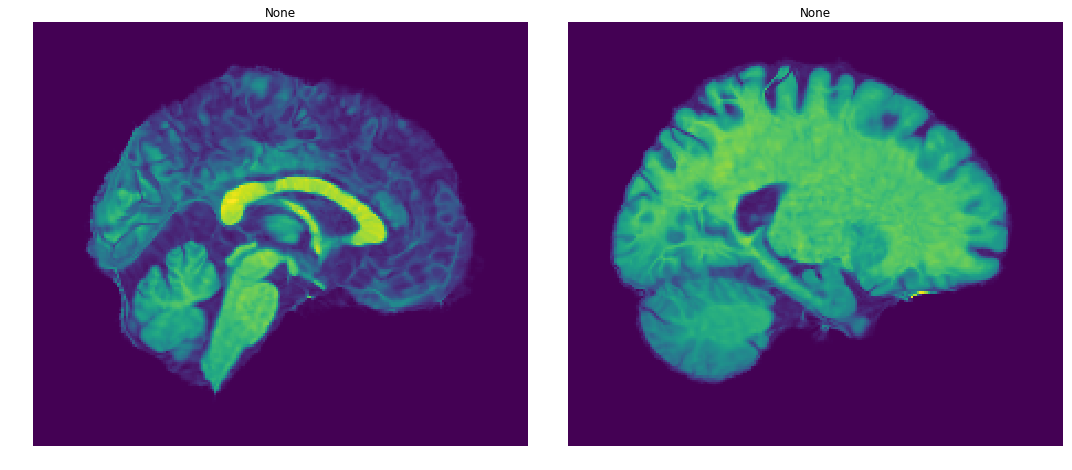

img shape (1, 160, 192, 224, 1)
atlas shape (1, 160, 192, 224, 1)
(1, 2076007, 1)
I_a max 0.9985304905622919
I_b max 0.9820078648594118
(1, 2427791, 1)
I_a max 0.9985304905622919
I_b max 0.9820078648594118
original image min max 0.8 0.0
img min max 0.61028993 0.0
flow min max 14.626733 -10.71601


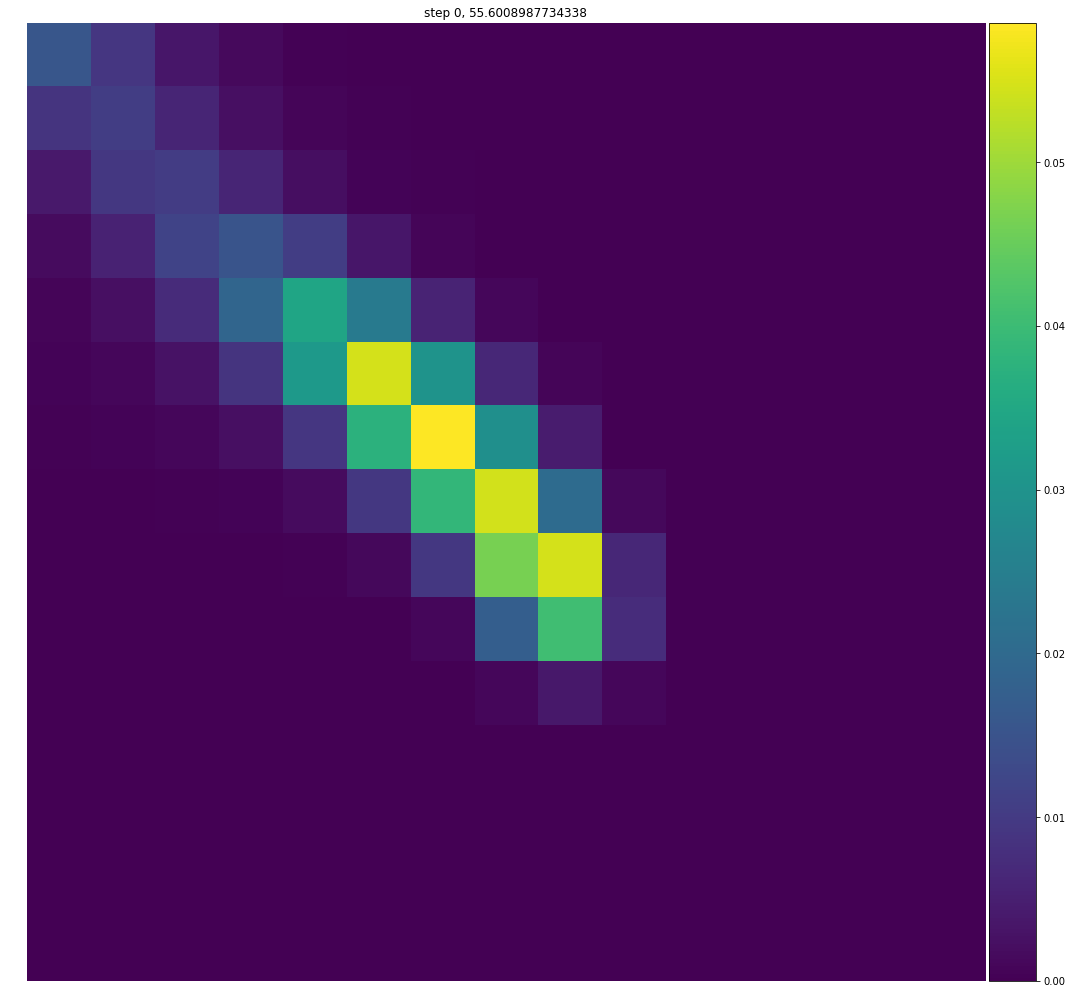

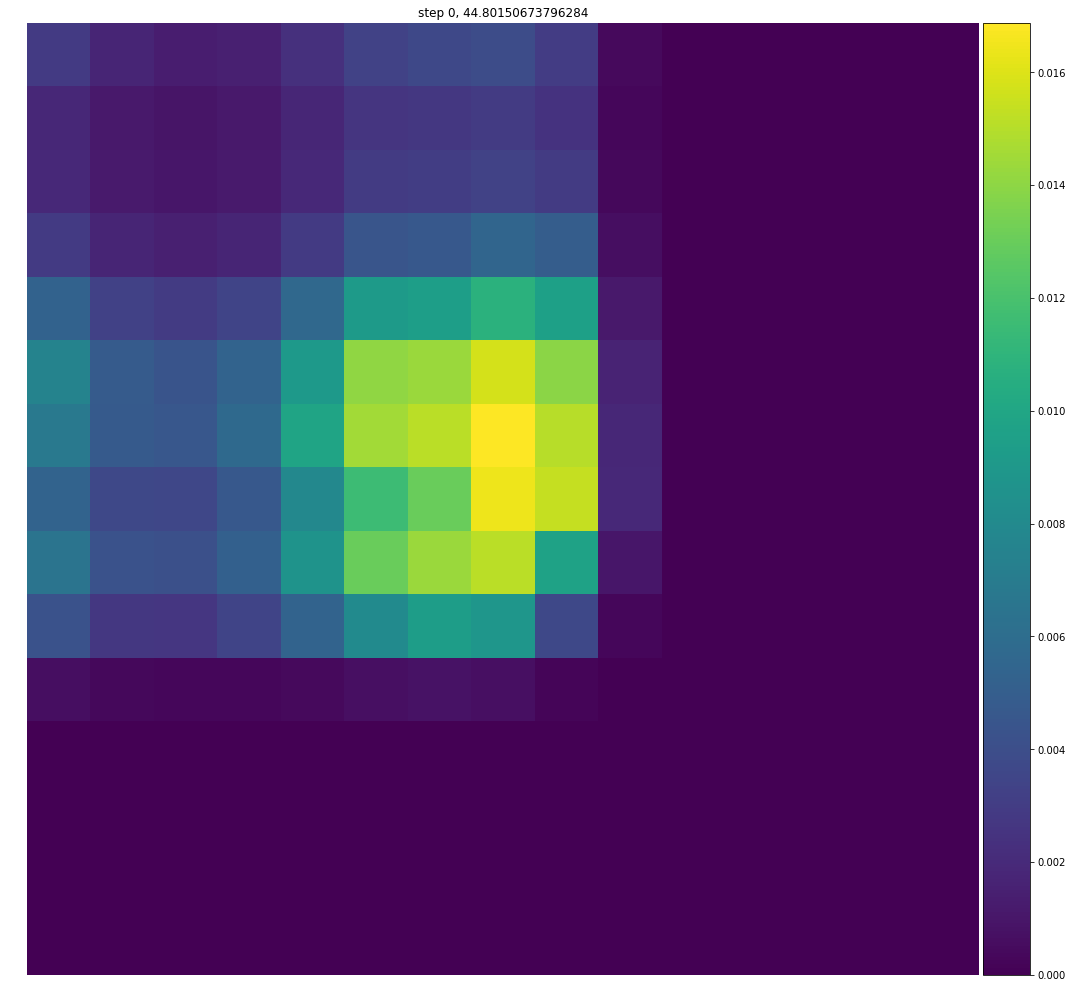

pab min max 0.07526434606897148 5.761794448616605e-38
0,1,-0.0064590815,-0.68416643,0.038258247
1,1,-0.005809488,-0.6451748,0.06422602
2,1,-0.0063788043,-0.67458194,0.036701515
3,1,-0.005922434,-0.6417265,0.04948306
4,1,-0.0063555804,-0.6730008,0.037442766
5,1,-0.006396791,-0.67453444,0.03485532
6,1,-0.006413049,-0.67816,0.036855076
7,1,-0.0064740092,-0.68408716,0.036686227
8,1,-0.006254109,-0.66474897,0.039338034
9,1,-0.006243698,-0.6644234,0.04005362
10,1,-0.006417203,-0.67712843,0.035408106
11,1,-0.006370382,-0.67798185,0.040943637
12,1,-0.006022648,-0.64545184,0.043186992
13,1,-0.0059519503,-0.649742,0.05454695
14,1,-0.00655757,-0.6919625,0.036205493
15,1,-0.006457573,-0.6837301,0.037972834
16,1,-0.0065718647,-0.69040513,0.033218652
17,1,-0.0065036956,-0.68897396,0.038604375
18,1,-0.006499741,-0.6866302,0.03665606
19,1,-0.006502832,-0.6869733,0.03669007
20,1,-0.0064710807,-0.68209964,0.034991566
21,1,-0.005962484,-0.63856167,0.04231323
22,1,-0.00637108,-0.6783886,0.041280594
23,1,-

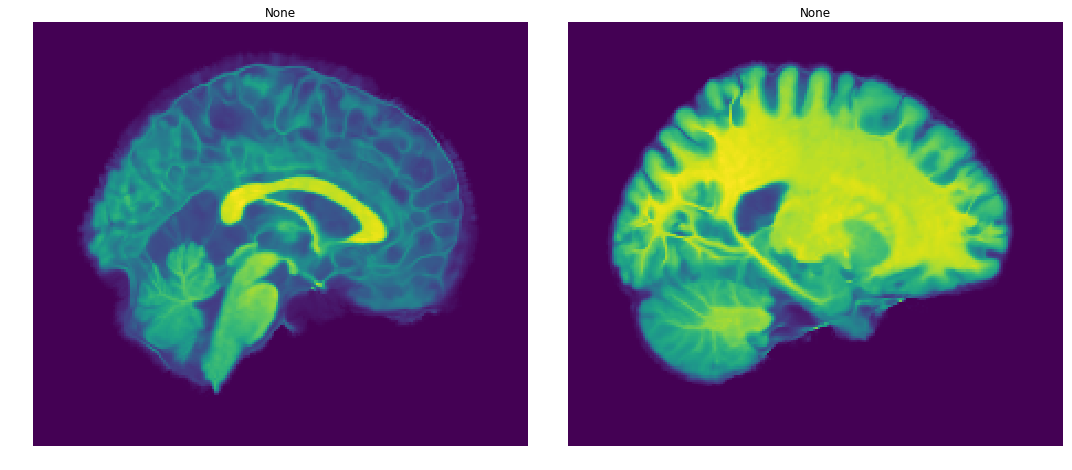

img shape (1, 160, 192, 224, 1)
atlas shape (1, 160, 192, 224, 1)
(1, 2203585, 1)
I_a max 0.9985304905622919
I_b max 0.9820078648594118
(1, 2509175, 1)
I_a max 0.9985304905622919
I_b max 0.9820078648594118
original image min max 0.5294117647058824 0.0
img min max 0.49428713 0.0
flow min max 12.918898 -10.621931


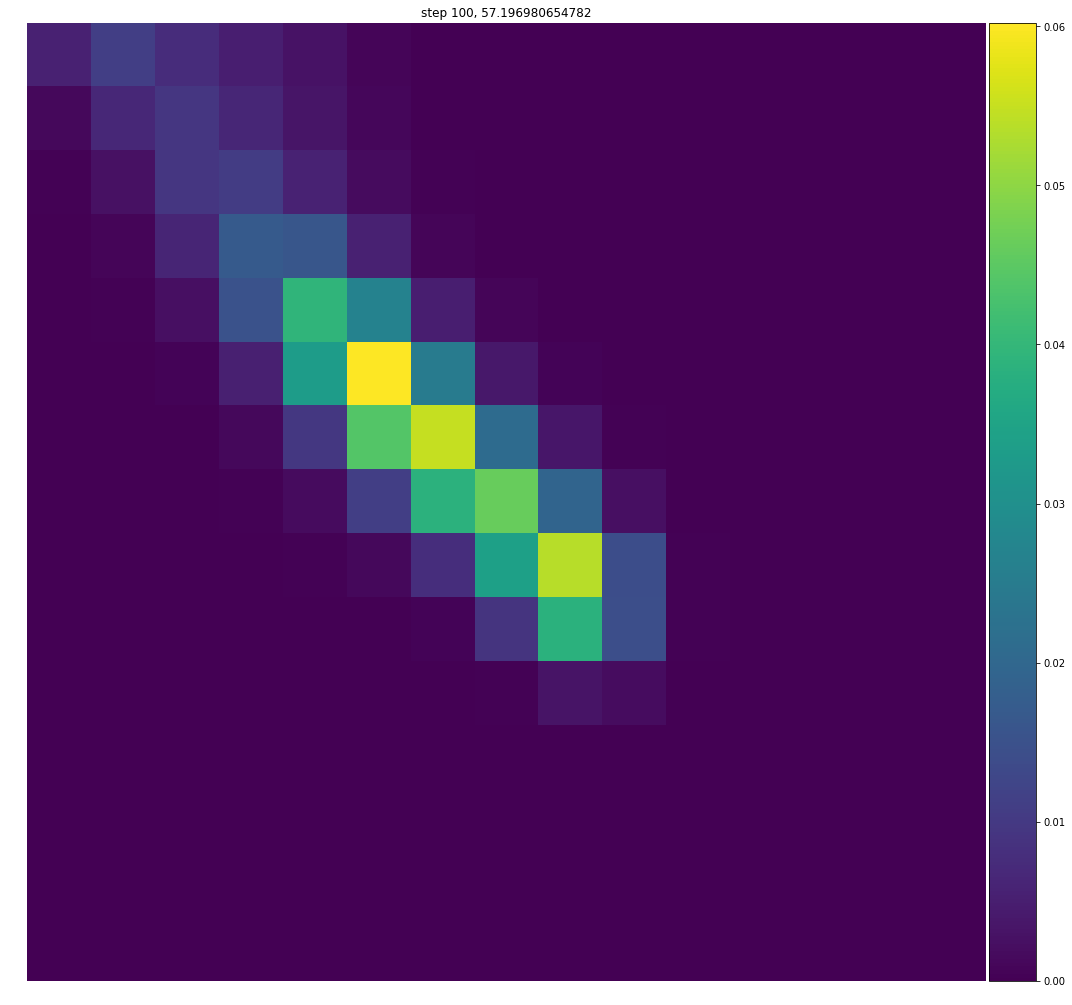

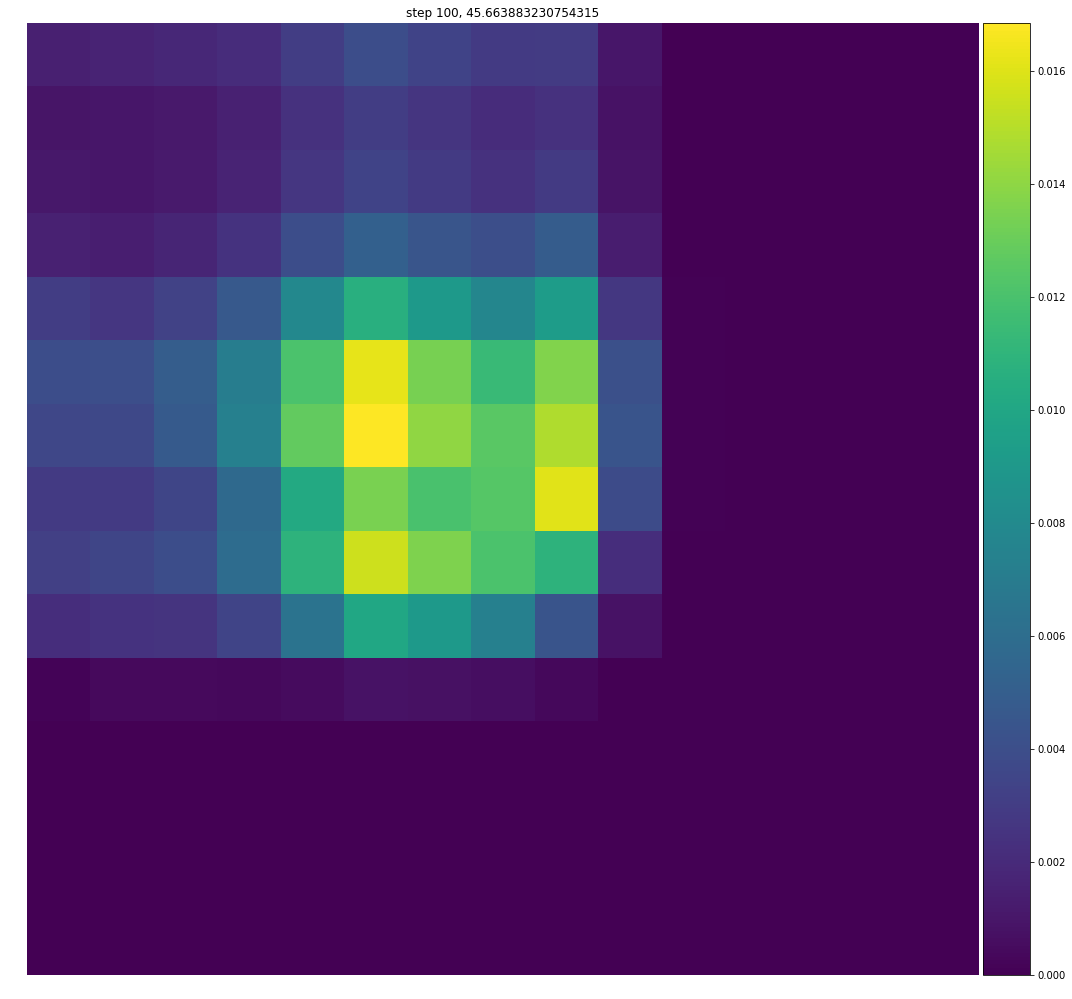

pab min max 0.09367254440264845 2.9912609183434364e-38
100,1,-0.0064822556,-0.6883496,0.04012402
101,1,-0.0064599207,-0.6868929,0.040900834
102,1,-0.006310959,-0.6812564,0.05016052
103,1,-0.0064030383,-0.68186694,0.04156313
104,1,-0.006507615,-0.6875955,0.036833942
105,1,-0.0064790803,-0.684255,0.036346972
106,1,-0.006356595,-0.6733484,0.037688926
107,1,-0.006344994,-0.6779311,0.043431662
108,1,-0.0064420747,-0.6815629,0.037355453
109,1,-0.006544032,-0.6900259,0.03562274
110,1,-0.0064774584,-0.687532,0.039786138
111,1,-0.006565862,-0.69889903,0.04231281
112,1,-0.0056367433,-0.6283702,0.06469592
113,1,-0.00642445,-0.6874496,0.045004573
114,1,-0.0064464924,-0.68188703,0.03723776
115,1,-0.0064685596,-0.6853746,0.038518652
116,1,-0.006512082,-0.6866474,0.035439212
117,1,-0.00643619,-0.68049294,0.036873892
118,1,-0.006451888,-0.6822692,0.037080415
119,1,-0.0064967815,-0.68801993,0.038341783
120,1,-0.0064379345,-0.6815448,0.037751295
121,1,-0.0063436828,-0.67548966,0.041121393
122,1,-0.00654

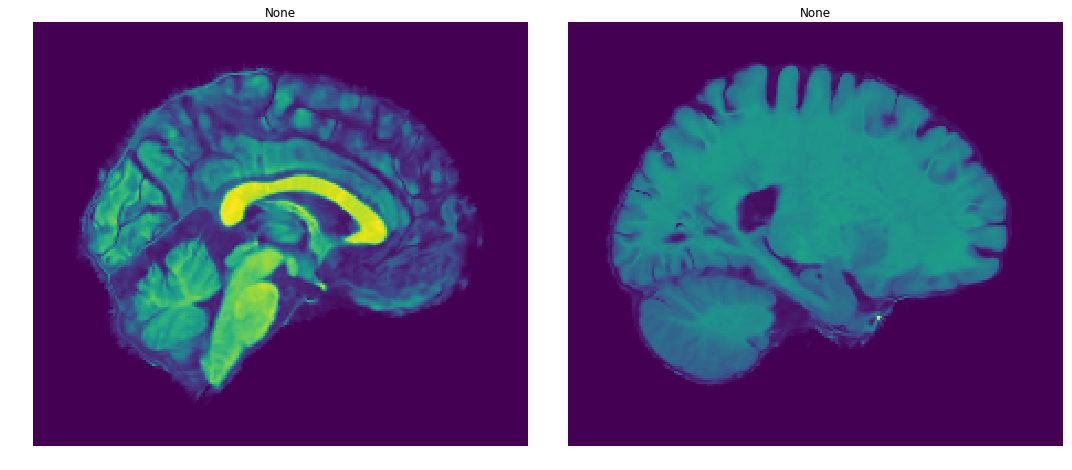

img shape (1, 160, 192, 224, 1)
atlas shape (1, 160, 192, 224, 1)
(1, 2155982, 1)
I_a max 0.9985304905622919
I_b max 0.9820078648594118
(1, 2476543, 1)
I_a max 0.9985304905622919
I_b max 0.9820078648594118
original image min max 0.8470588235294118 0.0
img min max 0.75146574 0.0
flow min max 12.71758 -15.453956


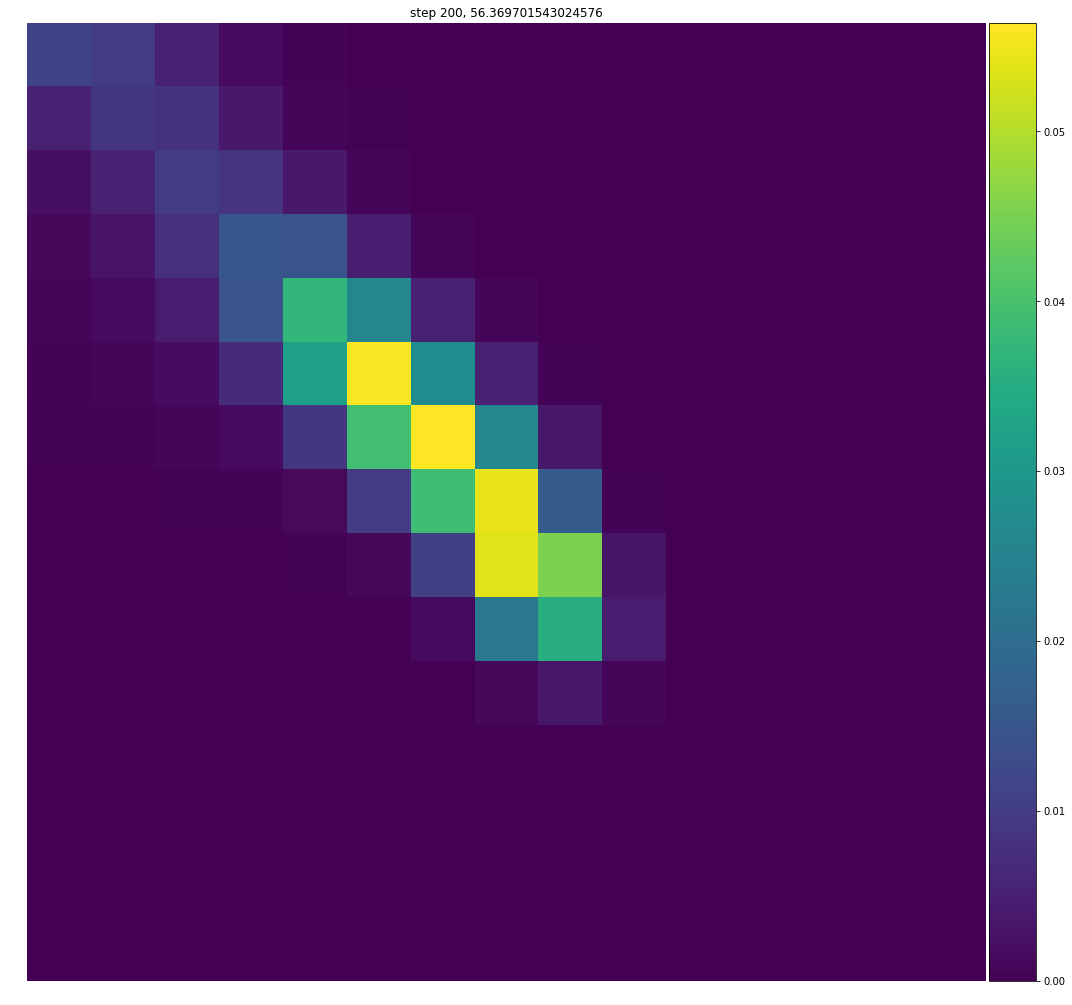

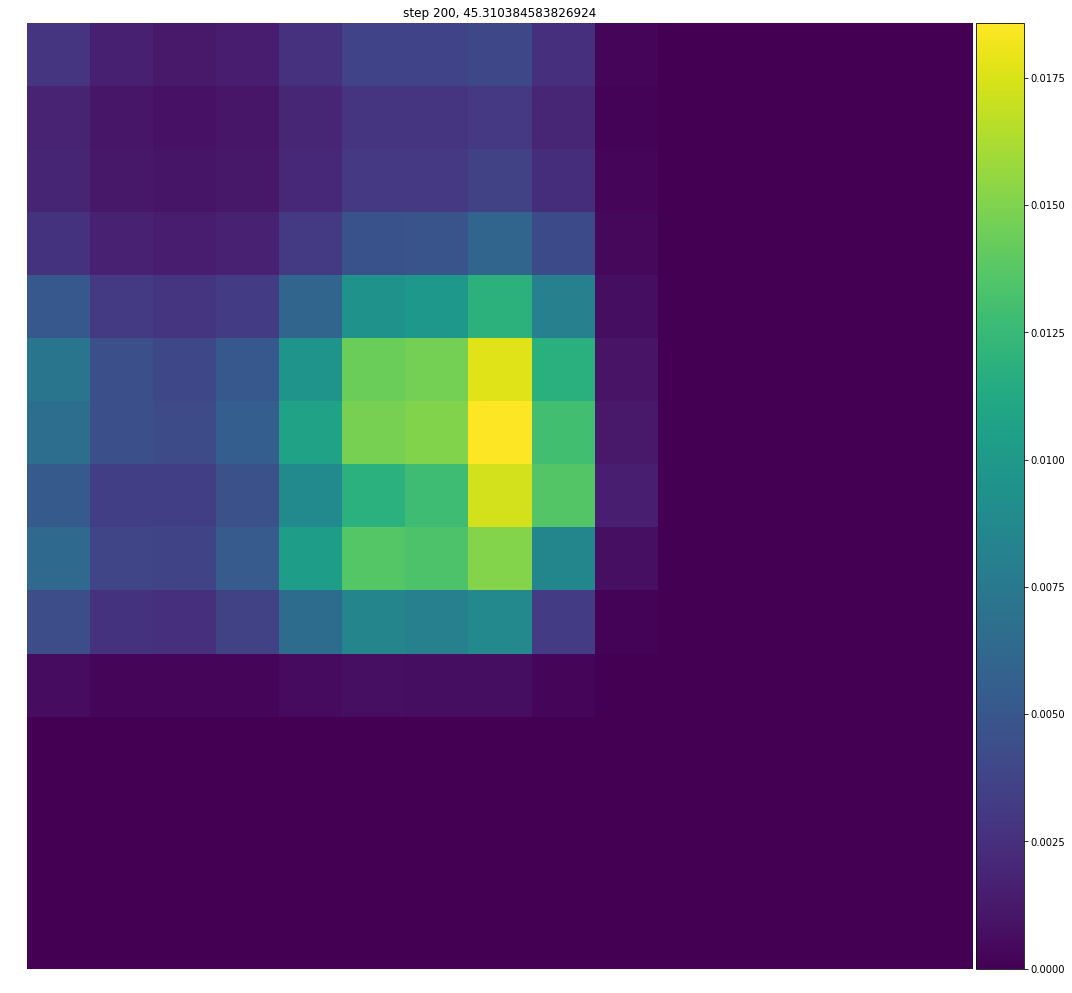

pab min max 0.0862784272001157 1.1383977016831824e-35
200,1,-0.0063570095,-0.67736,0.04165902
201,1,-0.006335256,-0.67533004,0.041804418
202,1,-0.006473943,-0.68303835,0.035644032
203,1,-0.006111961,-0.6583621,0.047166012
204,1,-0.0061895726,-0.6617944,0.04283718
205,1,-0.006519348,-0.6877397,0.035804886
206,1,-0.006491532,-0.68693006,0.03777681
207,1,-0.0063372236,-0.6745752,0.040852815
208,1,-0.006285984,-0.67418176,0.045583375
209,1,-0.0060133548,-0.6468027,0.04546721
210,1,-0.006519825,-0.6916276,0.039645117
211,1,-0.0063663768,-0.6772915,0.040653802
212,1,-0.006433589,-0.6830743,0.039715357
213,1,-0.006499692,-0.68688536,0.03691613
214,1,-0.0064261486,-0.6811594,0.0385445
215,1,-0.006445944,-0.68293935,0.038344957
216,1,-0.006518301,-0.6906608,0.038830653
217,1,-0.0066159023,-0.7011331,0.03954283
218,1,-0.006426838,-0.68258077,0.03989691
219,1,-0.006494805,-0.68816656,0.038686007
220,1,-0.0064322064,-0.6872735,0.044052877
221,1,-0.006447894,-0.6849546,0.04016516
222,1,-0.006385921

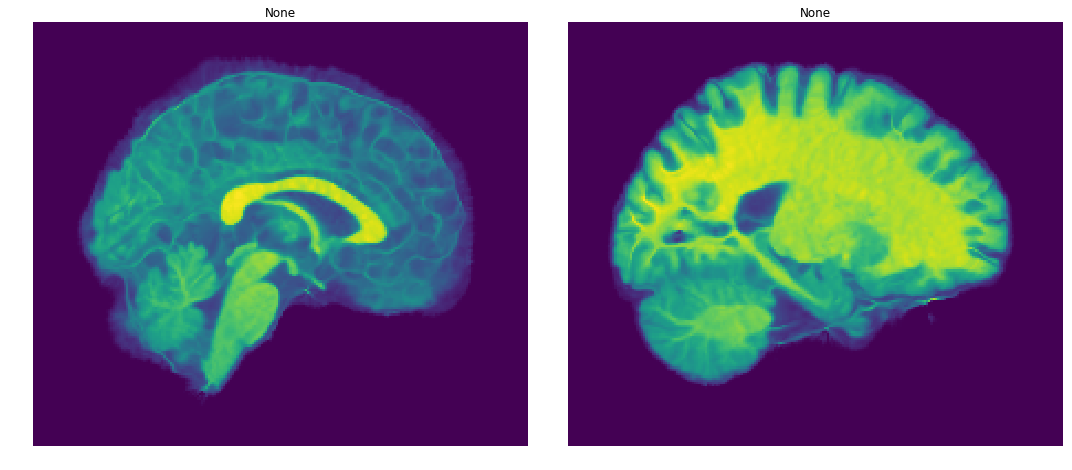

img shape (1, 160, 192, 224, 1)
atlas shape (1, 160, 192, 224, 1)
(1, 2185974, 1)
I_a max 0.9985304905622919
I_b max 0.9820078648594118
(1, 2501736, 1)
I_a max 0.9985304905622919
I_b max 0.9820078648594118
original image min max 0.5333333333333333 0.0
img min max 0.4948889 0.0
flow min max 12.535684 -11.502511


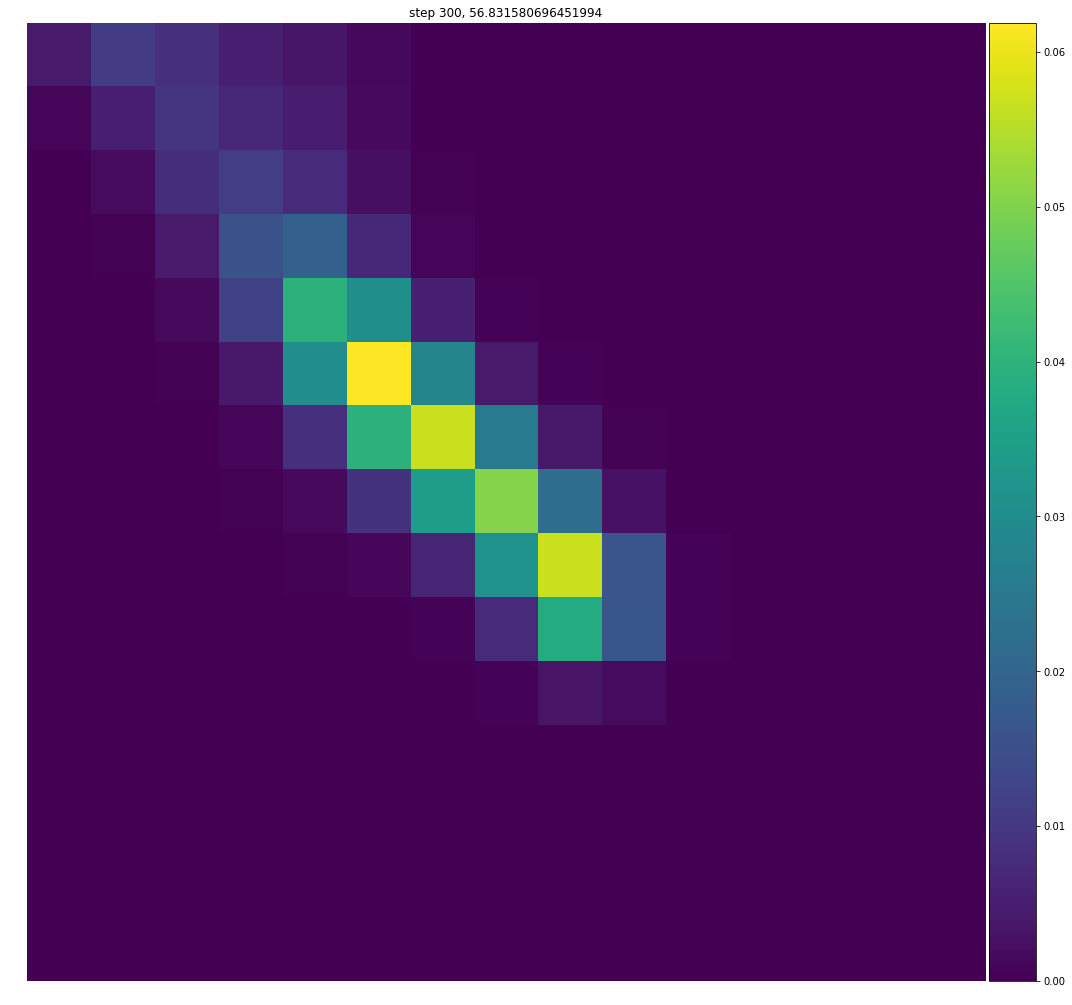

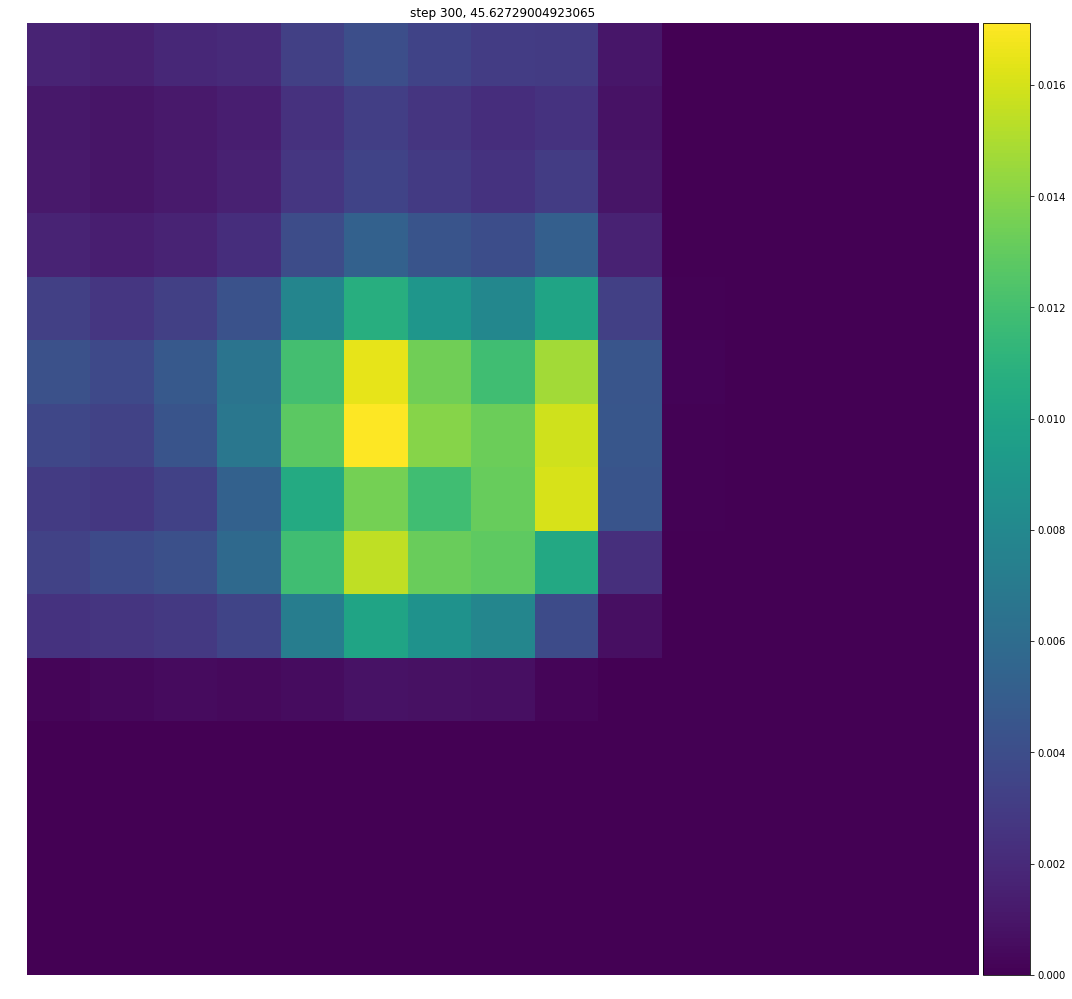

pab min max 0.06914075390927045 4.814235997246164e-38
300,1,-0.0065041455,-0.686237,0.035822436
301,1,-0.0065485616,-0.69149524,0.036639087
302,1,-0.0065229917,-0.6877581,0.035458885
303,1,-0.0064125997,-0.6804998,0.03923978
304,1,-0.0065197637,-0.69059294,0.03861656
305,1,-0.0059863525,-0.64435923,0.045723975
306,1,-0.0062871673,-0.6744283,0.04571153
307,1,-0.0062802155,-0.6794674,0.05144584
308,1,-0.006273524,-0.66735834,0.04000596
309,1,-0.006500831,-0.6874583,0.037375193
310,1,-0.006537298,-0.68940634,0.035676487
311,1,-0.006359025,-0.6750233,0.039120834
312,1,-0.006447361,-0.68131405,0.036577977
313,1,-0.0064329407,-0.6822473,0.03895318
314,1,-0.006501644,-0.68656677,0.036402382
315,1,-0.006517527,-0.69128317,0.039530434
316,1,-0.006341882,-0.6766374,0.042449184
317,1,-0.00651364,-0.6900867,0.03872274
318,1,-0.0065717637,-0.69583106,0.038654692
319,1,-0.0065964335,-0.69555235,0.035909023
320,1,-0.0064930255,-0.6880709,0.038768336
321,1,-0.006464344,-0.6837555,0.037321102
322,1,-0.

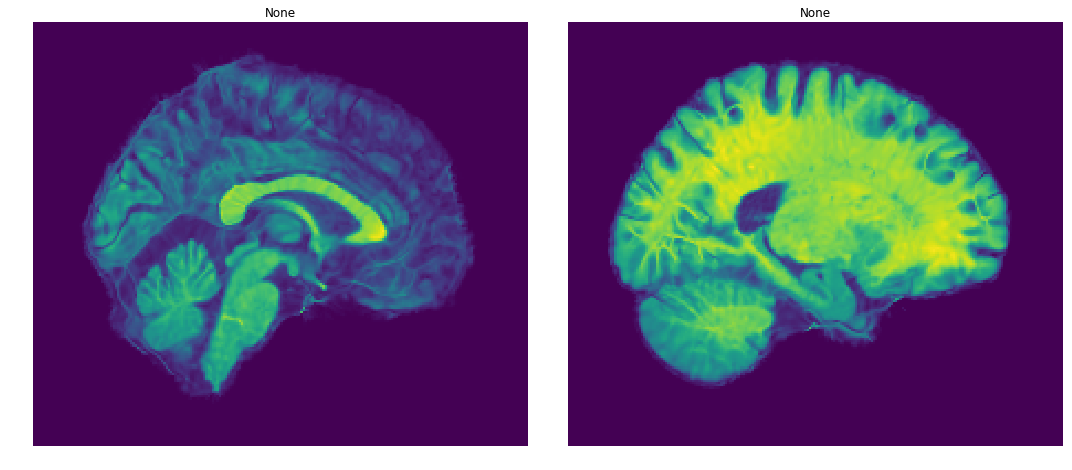

img shape (1, 160, 192, 224, 1)
atlas shape (1, 160, 192, 224, 1)
(1, 2142345, 1)
I_a max 0.9985304905622919
I_b max 0.9820078648594118
(1, 2470659, 1)
I_a max 0.9985304905622919
I_b max 0.9820078648594118
original image min max 0.6588235294117647 0.0
img min max 0.5234124 0.0
flow min max 12.446857 -13.356649


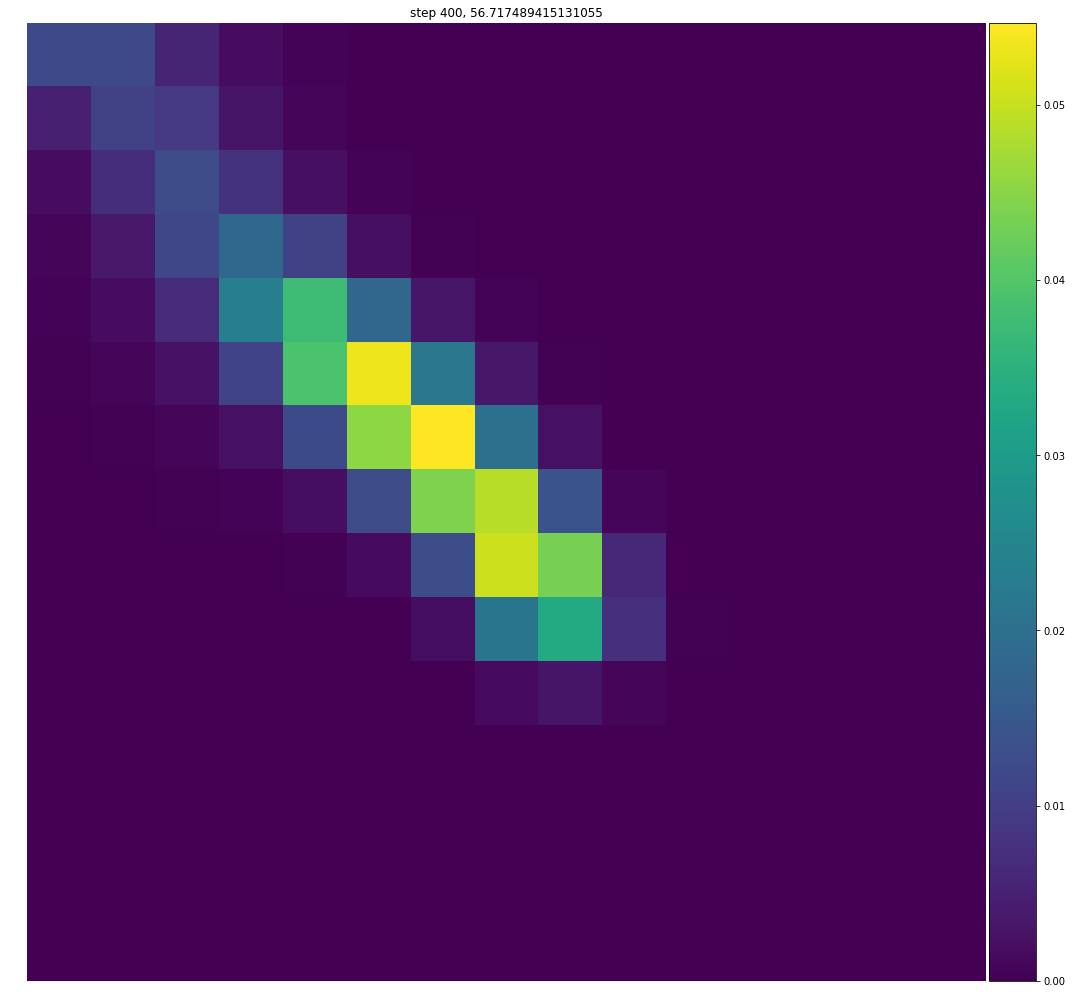

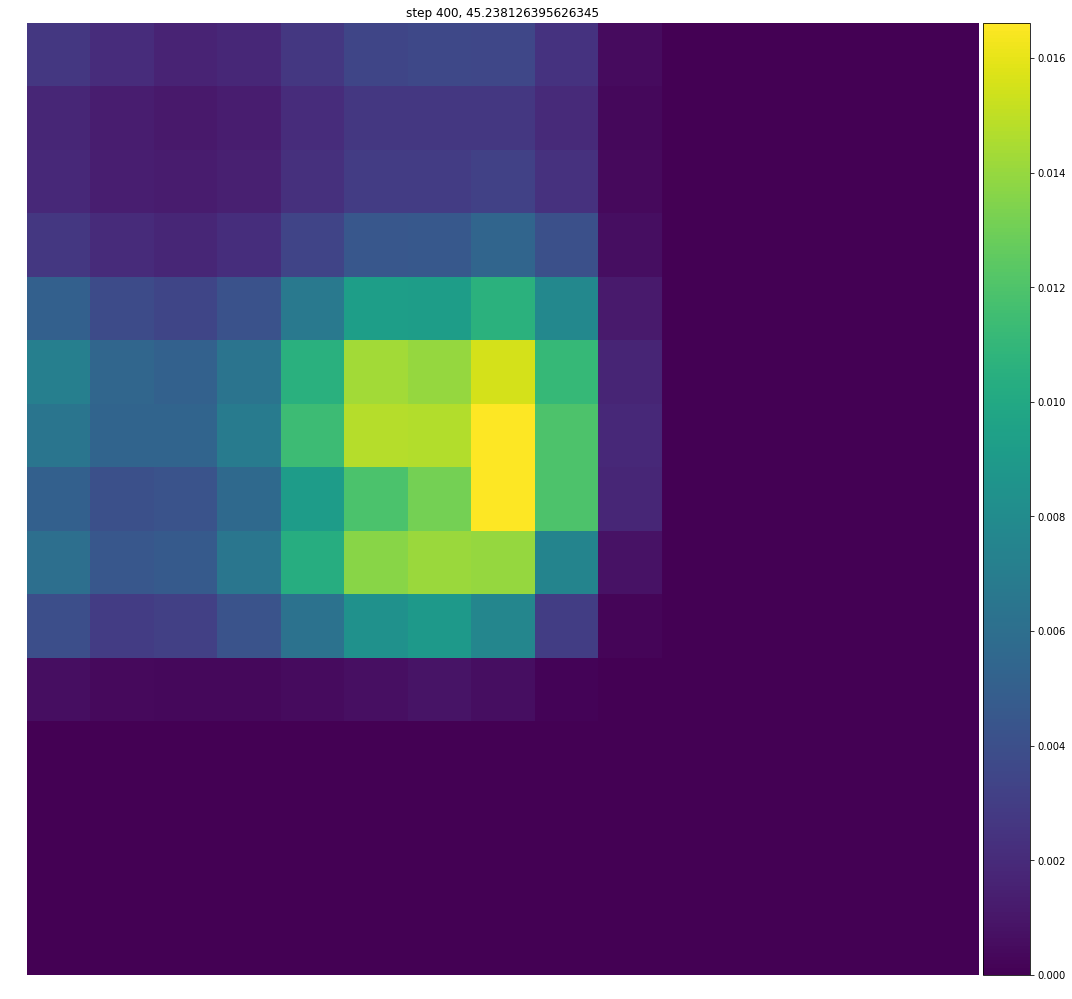

pab min max 0.0784610848479446 9.864136548459257e-34
400,1,-0.0065260385,-0.69190496,0.03930112
401,1,-0.0062590674,-0.6773089,0.051402178
402,1,-0.0064877453,-0.6882342,0.039459687
403,1,-0.0064379266,-0.6904135,0.046620797
404,1,-0.0060810186,-0.66188323,0.053781386
405,1,-0.006486513,-0.6866628,0.038011473
406,1,-0.006499558,-0.6885373,0.03858149
407,1,-0.0064662662,-0.6842127,0.037586026
408,1,-0.0064496957,-0.68422365,0.03925407
409,1,-0.0059902016,-0.6524762,0.05345599
410,1,-0.0064416314,-0.68230236,0.038139187
411,1,-0.0064309137,-0.6825583,0.039466932
412,1,-0.0065652975,-0.69181067,0.035280906
413,1,-0.006503862,-0.6867078,0.03632159
414,1,-0.006481279,-0.6868576,0.038729653
415,1,-0.0064926394,-0.68631387,0.03704992
416,1,-0.0065702028,-0.69283605,0.035815742
417,1,-0.006075463,-0.6541851,0.0466388
418,1,-0.0064313253,-0.6832004,0.04006789
419,1,-0.0065620374,-0.6915921,0.03538833
420,1,-0.0065283454,-0.6897764,0.036941897
421,1,-0.0064346115,-0.6833625,0.039901316
422,1,-0.

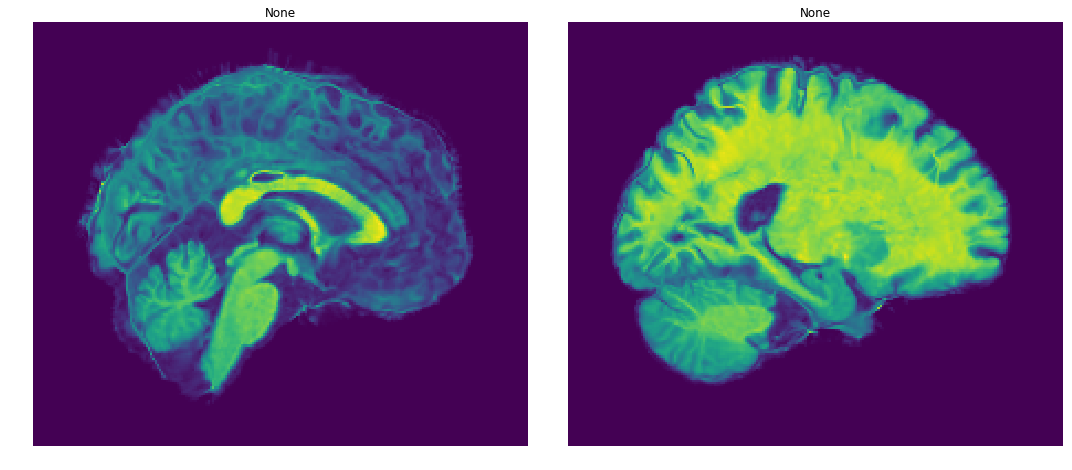

img shape (1, 160, 192, 224, 1)
atlas shape (1, 160, 192, 224, 1)
(1, 2154043, 1)
I_a max 0.9985304905622919
I_b max 0.9820078648594118
(1, 2480724, 1)
I_a max 0.9985304905622919
I_b max 0.9820078648594118
original image min max 0.7098039215686275 0.0
img min max 0.53194976 0.0
flow min max 12.213786 -19.480925


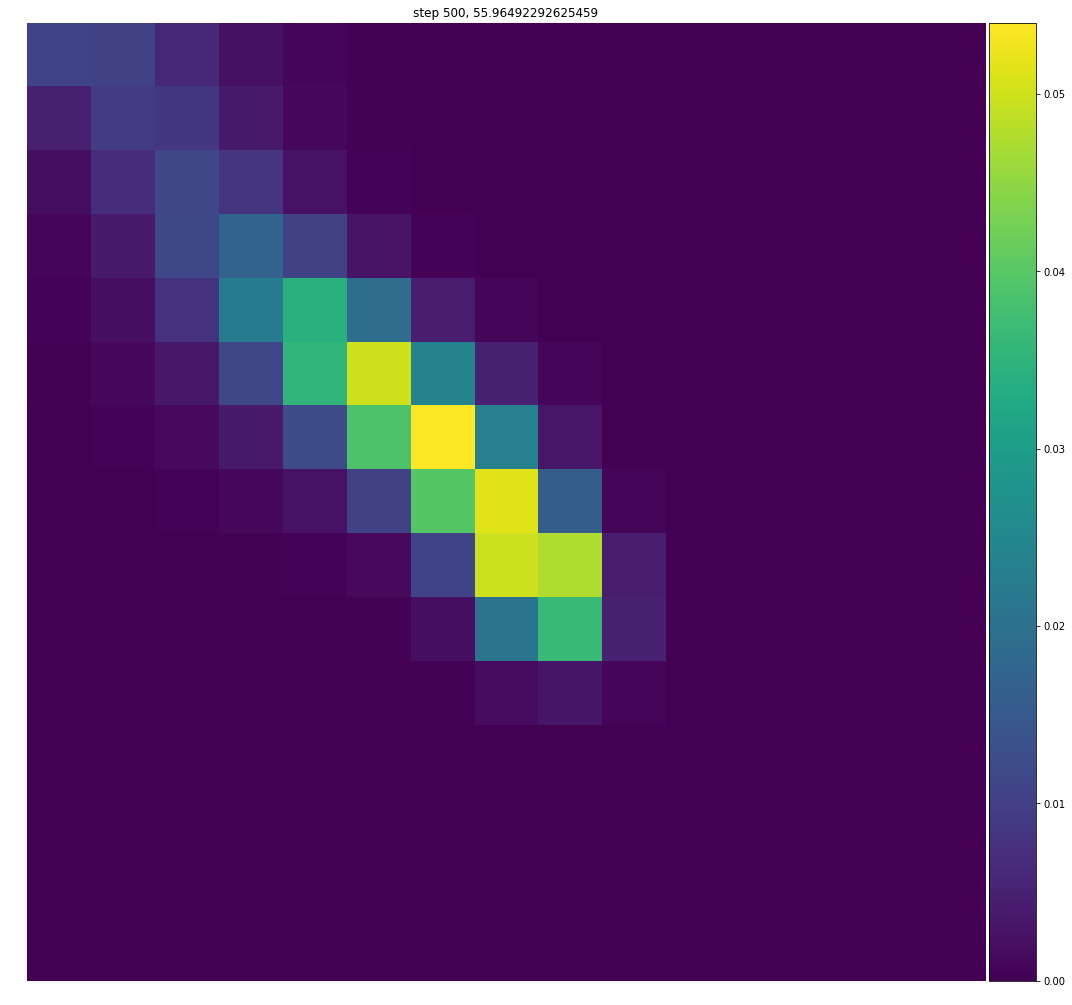

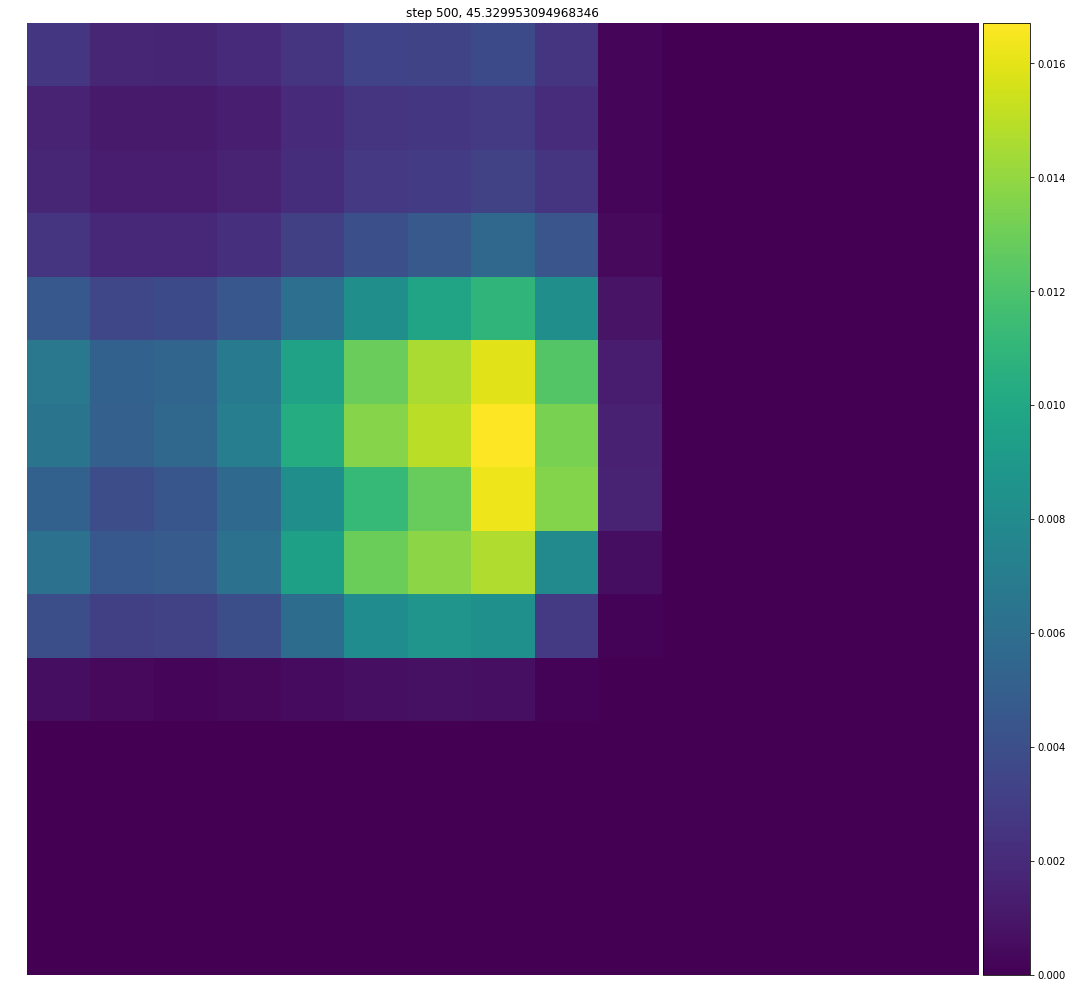

pab min max 0.08534310527221908 5.036718178331503e-38
500,1,-0.0063009337,-0.6731833,0.04308992
501,1,-0.0063388157,-0.6782644,0.04438278
502,1,-0.006523301,-0.69017094,0.03784083
503,1,-0.0064756656,-0.6873358,0.039769195
504,1,-0.006420644,-0.68342143,0.04135701
505,1,-0.0065103513,-0.68962073,0.0385856
506,1,-0.0064092996,-0.68109787,0.040167876
507,1,-0.006580901,-0.69378245,0.03569234
508,1,-0.0064787613,-0.6852899,0.037413806
509,1,-0.0065356093,-0.68792254,0.034361612
510,1,-0.0065396717,-0.6912875,0.037320327
511,1,-0.006499461,-0.69043314,0.040487044
512,1,-0.0064636013,-0.68502235,0.03866224
513,1,-0.0062786113,-0.67169815,0.043837026
514,1,-0.006510218,-0.693837,0.04281519
515,1,-0.0060914126,-0.661075,0.0519337
516,1,-0.006484442,-0.6859392,0.037495017
517,1,-0.0065075085,-0.6899652,0.039214294
518,1,-0.0063643106,-0.67586267,0.039431598
519,1,-0.0065661017,-0.6911682,0.034558035
520,1,-0.0064959666,-0.689392,0.039795335
521,1,-0.006572104,-0.6931579,0.035947453
522,1,-0.00

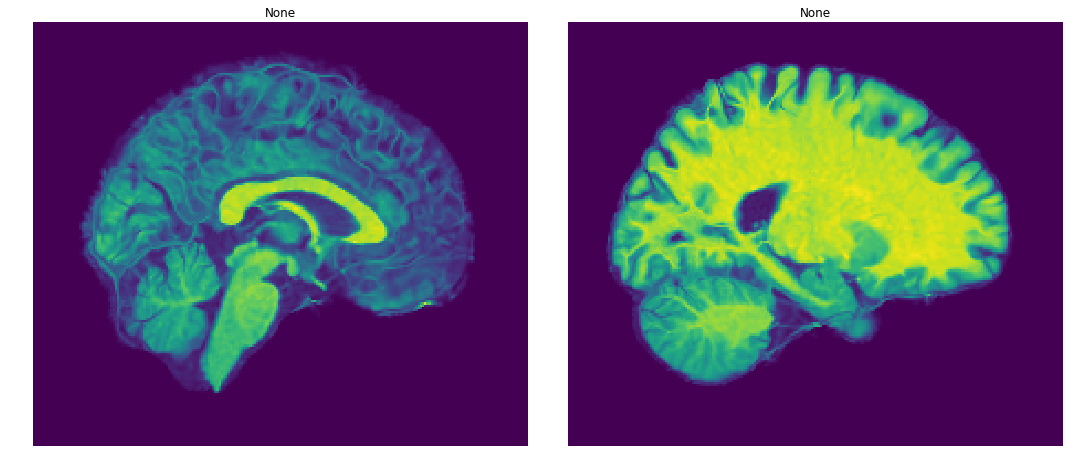

img shape (1, 160, 192, 224, 1)
atlas shape (1, 160, 192, 224, 1)
(1, 2122989, 1)
I_a max 0.9985304905622919
I_b max 0.9820078648594118
(1, 2462802, 1)
I_a max 0.9985304905622919
I_b max 0.9820078648594118
original image min max 0.7137254901960784 0.0
img min max 0.59088755 0.0
flow min max 10.688228 -11.808166


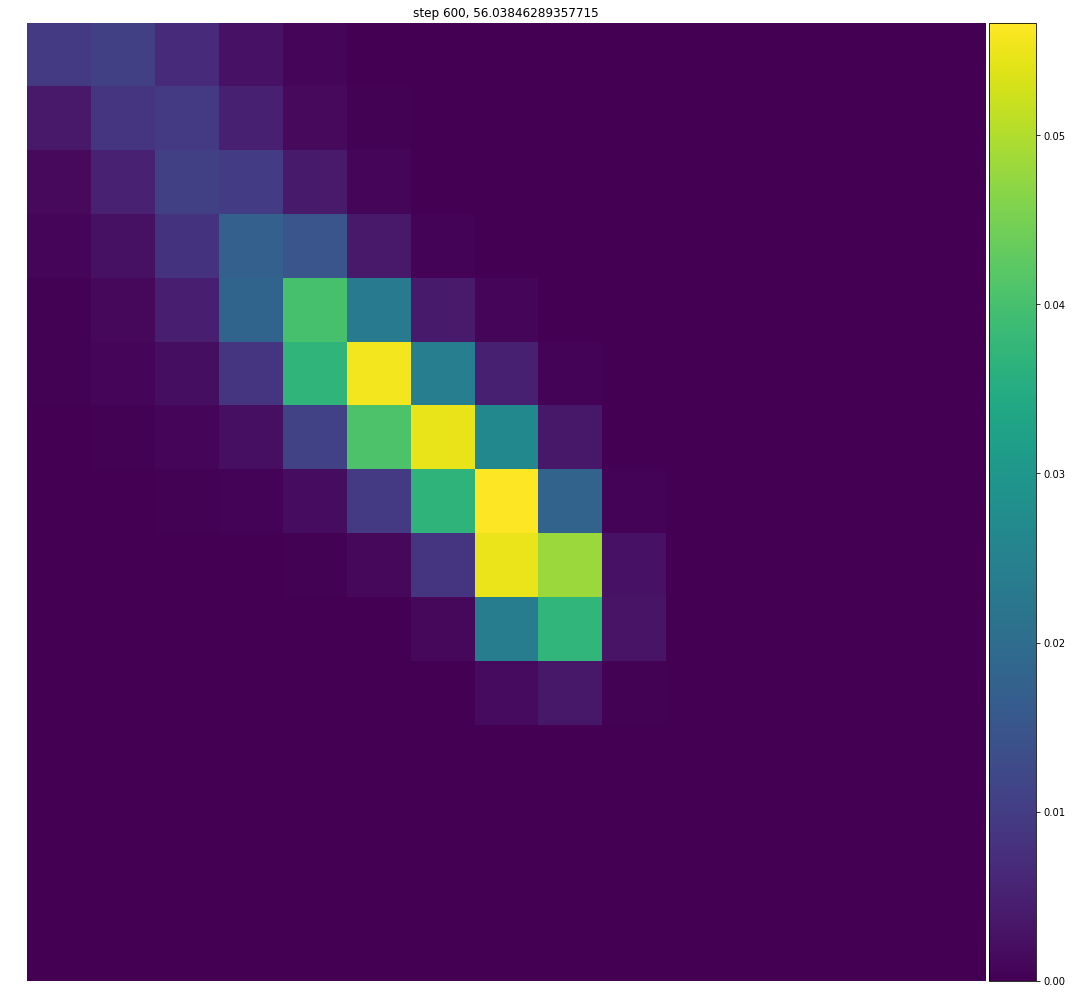

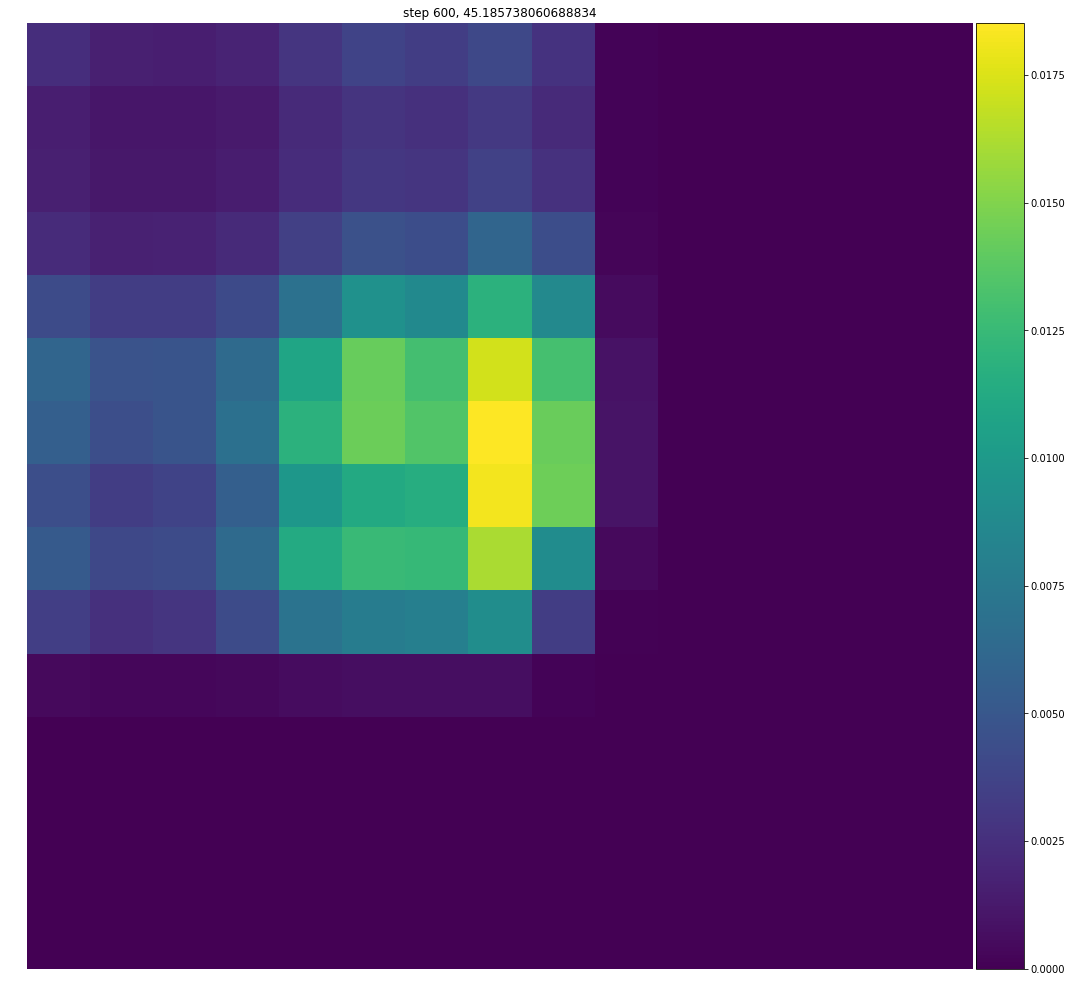

pab min max 0.07308881783143789 2.181009322287526e-40
600,1,-0.006449674,-0.68280655,0.037839163
601,1,-0.006543009,-0.69289005,0.038589116
602,1,-0.005621935,-0.63268685,0.07049336
603,1,-0.0062844222,-0.67215353,0.043711305
604,1,-0.006561247,-0.6926897,0.036564987
605,1,-0.006349545,-0.6774589,0.04250435
606,1,-0.006472013,-0.6843007,0.037099443
607,1,-0.0065822406,-0.69525075,0.037026703
608,1,-0.006541955,-0.6963764,0.042180892
609,1,-0.00660038,-0.6970867,0.037048683
610,1,-0.0065618823,-0.69492215,0.038733885
611,1,-0.006593729,-0.69624335,0.03687046
612,1,-0.0064747445,-0.68918735,0.04171285
613,1,-0.0063889204,-0.68219304,0.043301012
614,1,-0.0064306697,-0.6842398,0.04117282
615,1,-0.0065667937,-0.69575405,0.039074644
616,1,-0.0060361894,-0.64909863,0.045479715
617,1,-0.0062230607,-0.6660305,0.043724425
618,1,-0.006487336,-0.68401456,0.03528091
619,1,-0.00634534,-0.673833,0.03929898
620,1,-0.0065623475,-0.69167817,0.035443388
621,1,-0.006552024,-0.69070756,0.03550516
622,1,-0.

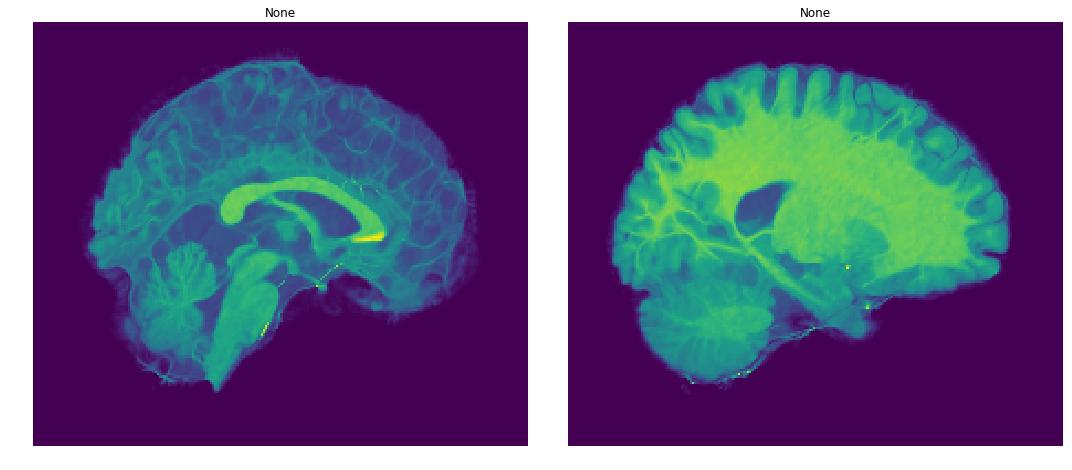

img shape (1, 160, 192, 224, 1)
atlas shape (1, 160, 192, 224, 1)
(1, 2172015, 1)
I_a max 0.9985304905622919
I_b max 0.9820078648594118
(1, 2488415, 1)
I_a max 0.9985304905622919
I_b max 0.9820078648594118
original image min max 0.7215686274509804 0.0
img min max 0.66551733 0.0
flow min max 11.313509 -11.81267


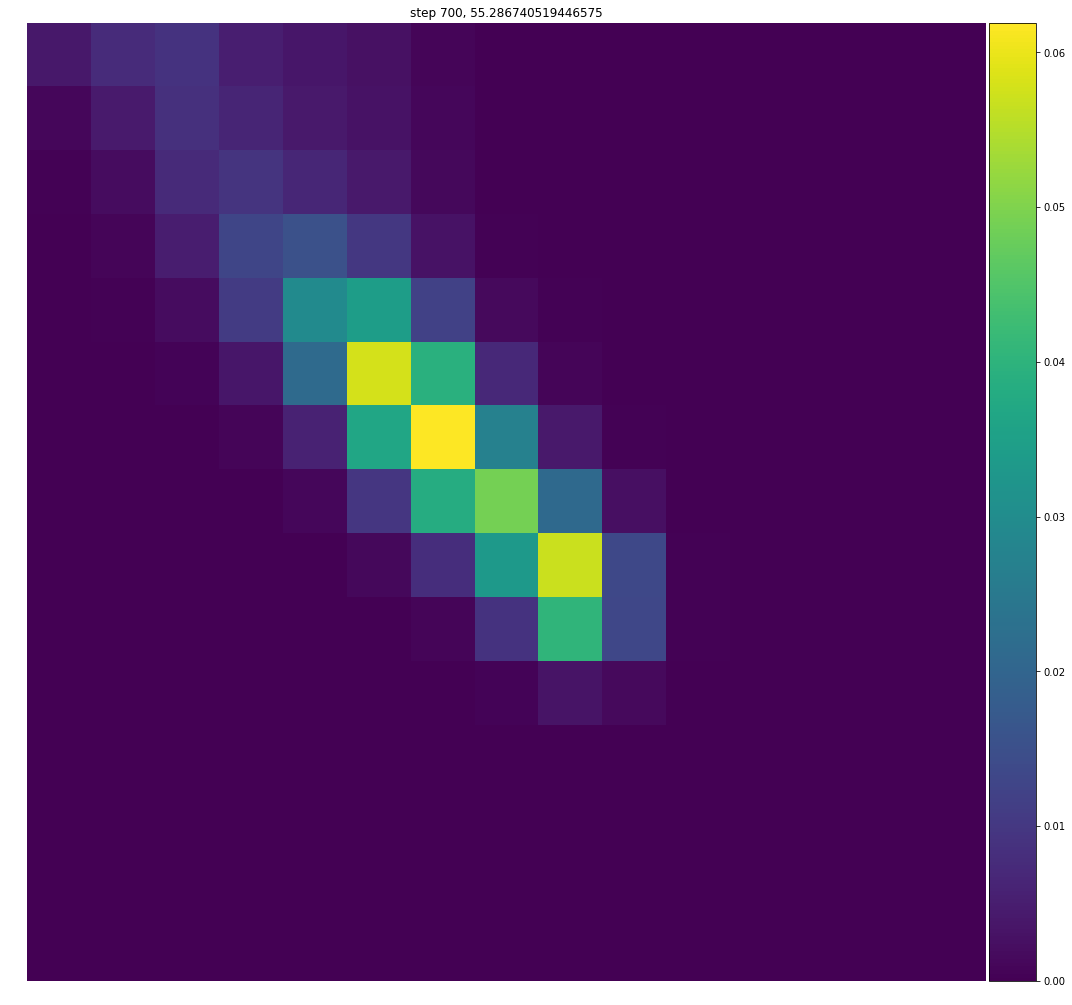

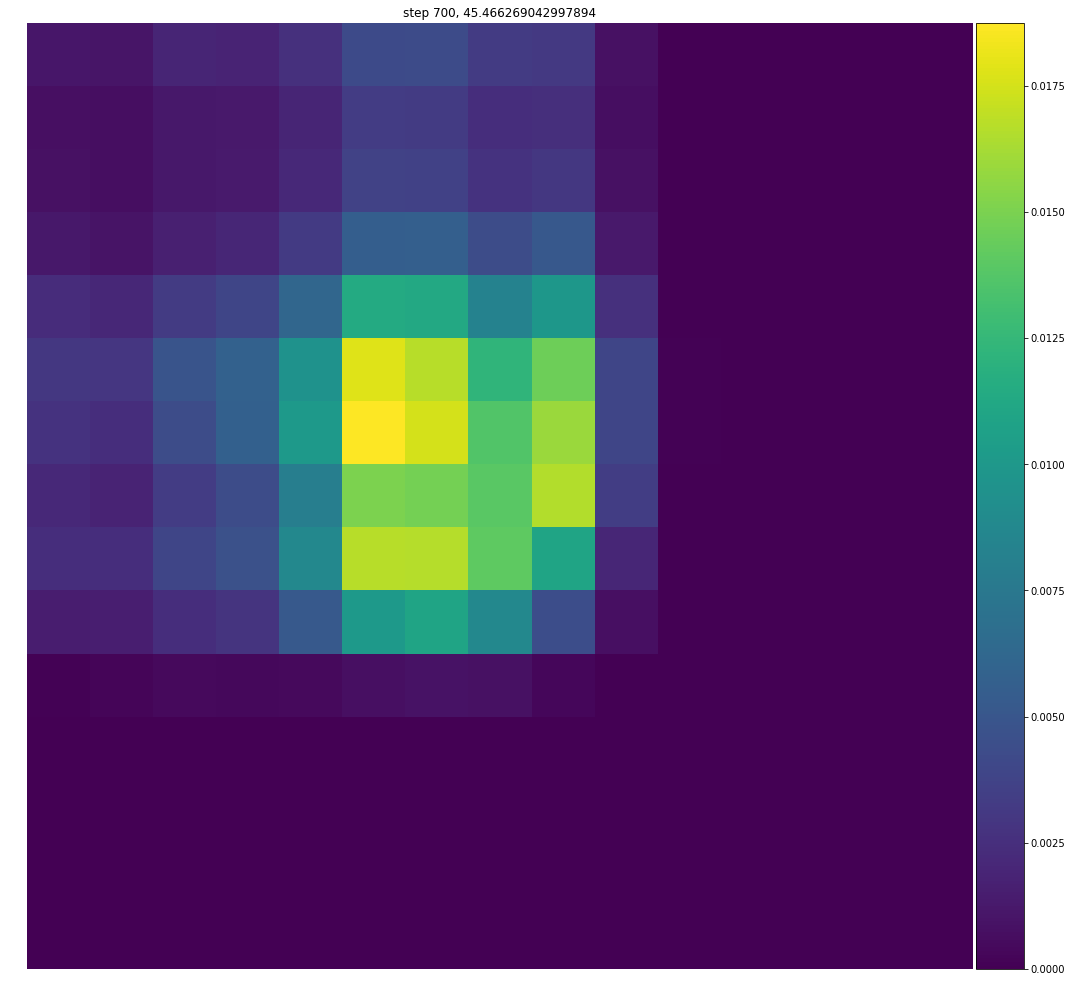

pab min max 0.0866851343052415 8.591570759419187e-39
700,1,-0.0061674397,-0.65848637,0.0417424
701,1,-0.0065002255,-0.68887943,0.038856875
702,1,-0.0061936206,-0.6609483,0.041586198
703,1,-0.006516366,-0.6890537,0.03741715
704,1,-0.00638571,-0.6833636,0.044792604
705,1,-0.006575039,-0.69194764,0.03444373
706,1,-0.006407942,-0.6811671,0.04037288
707,1,-0.0061290776,-0.6598811,0.04697333
708,1,-0.0065186615,-0.68781376,0.03594763
709,1,-0.00638049,-0.6787814,0.040732373
710,1,-0.006461036,-0.6858238,0.03972023
711,1,-0.00645777,-0.68671405,0.04093709
712,1,-0.006536364,-0.6951411,0.041504677
713,1,-0.0065194243,-0.69093764,0.038995158
714,1,-0.006584136,-0.6975649,0.039151326
715,1,-0.0064836955,-0.6893426,0.040973067
716,1,-0.0065925387,-0.696551,0.037297156
717,1,-0.006453176,-0.6863762,0.04105863
718,1,-0.0065367357,-0.6902813,0.036607668
719,1,-0.0064589726,-0.68250614,0.036608916
720,1,-0.0065033645,-0.6878133,0.03747681
721,1,-0.0065000546,-0.690537,0.040531497
722,1,-0.0065716803,

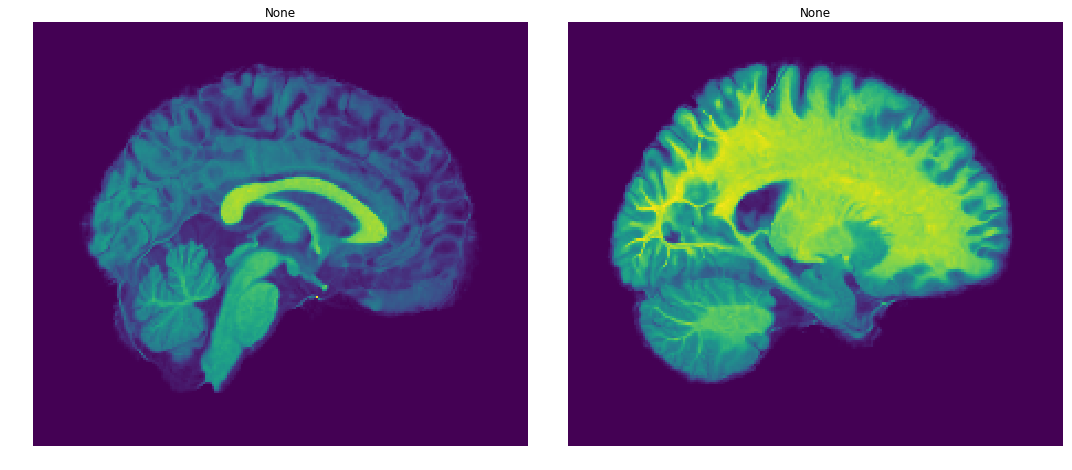

img shape (1, 160, 192, 224, 1)
atlas shape (1, 160, 192, 224, 1)
(1, 2121842, 1)
I_a max 0.9985304905622919
I_b max 0.9820078648594118
(1, 2454730, 1)
I_a max 0.9985304905622919
I_b max 0.9820078648594118
original image min max 0.7098039215686275 0.0
img min max 0.61294055 0.0
flow min max 10.742954 -11.953709


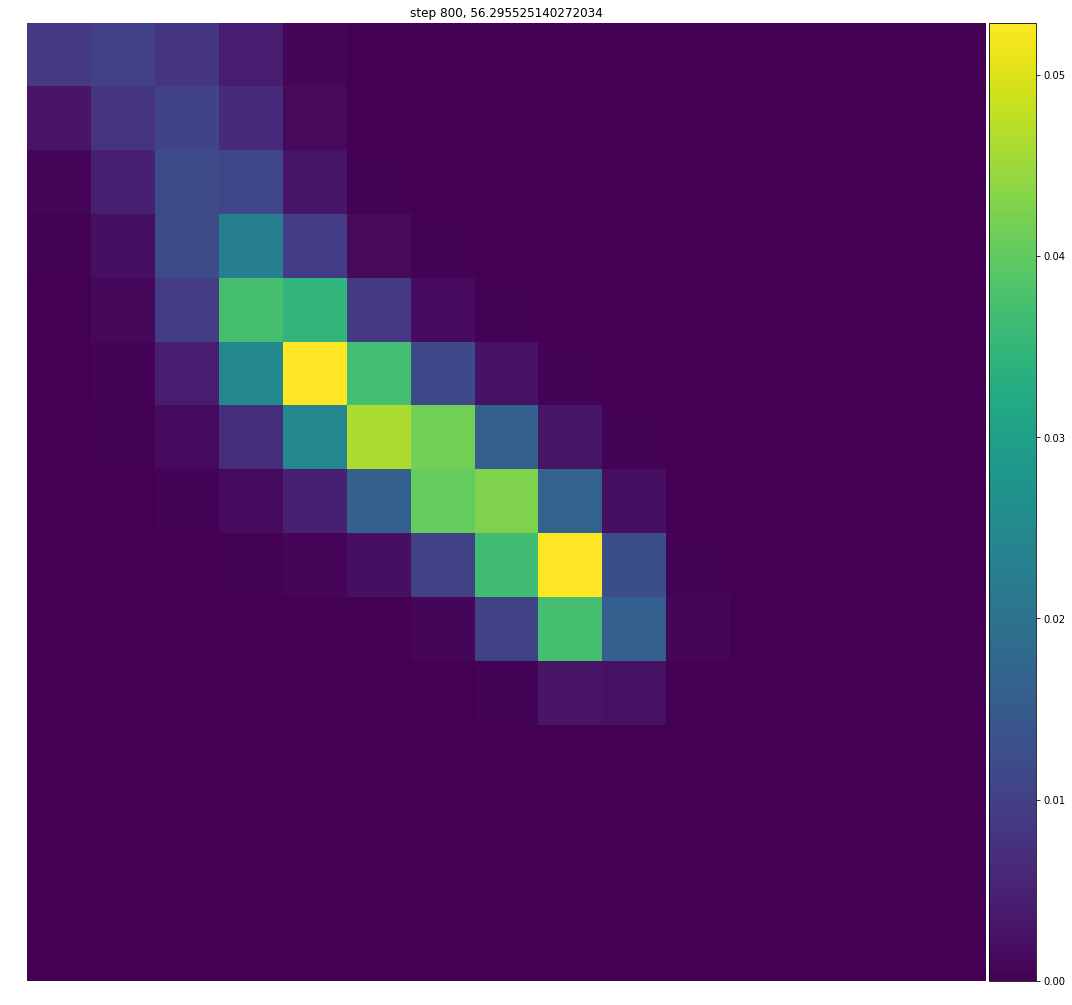

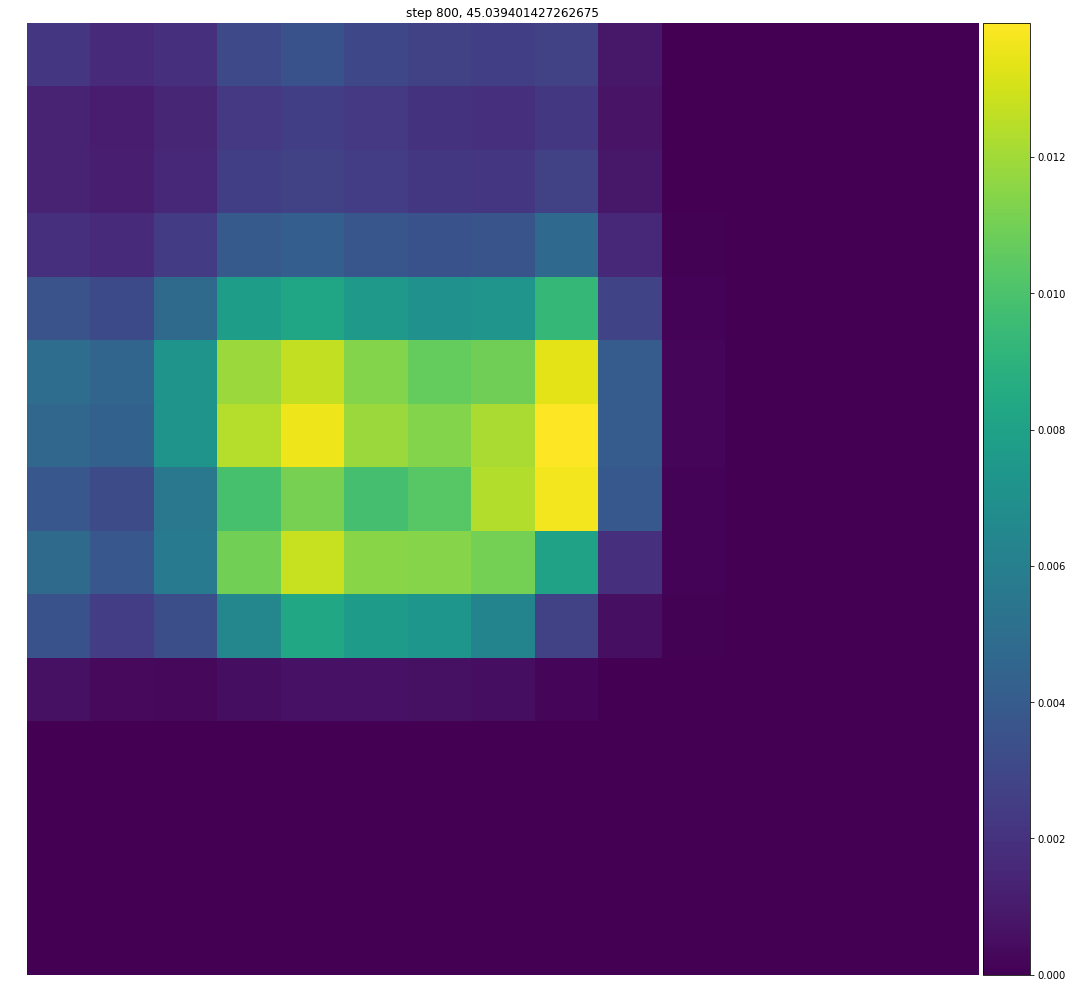

pab min max 0.07930187827647733 2.259308384165704e-36
800,1,-0.006487209,-0.69115734,0.042436462
801,1,-0.0064062215,-0.6834146,0.042792387
802,1,-0.006665327,-0.7047925,0.038259763
803,1,-0.0059674745,-0.64979213,0.053044714
804,1,-0.0064272056,-0.6816396,0.03891906
805,1,-0.0063820244,-0.6794261,0.04122364
806,1,-0.0064181937,-0.6790395,0.037220072
807,1,-0.0064376905,-0.6795677,0.03579864
808,1,-0.006547856,-0.69255656,0.037770968
809,1,-0.006478955,-0.68365955,0.035764053
810,1,-0.006498909,-0.68580824,0.035917327
811,1,-0.006442742,-0.68260175,0.038327552
812,1,-0.0063840467,-0.6798712,0.04146651
813,1,-0.0065889293,-0.6961419,0.03724895
814,1,-0.006655242,-0.7016312,0.03610699
815,1,-0.0061668763,-0.6683049,0.051617302
816,1,-0.0063915816,-0.6800228,0.04086464
817,1,-0.006547293,-0.6920327,0.0373034
818,1,-0.006625613,-0.6999533,0.037391987
819,1,-0.006507888,-0.6880251,0.037236325
820,1,-0.006349418,-0.67571616,0.04077437
821,1,-0.0064291274,-0.680847,0.03793419
822,1,-0.0065413

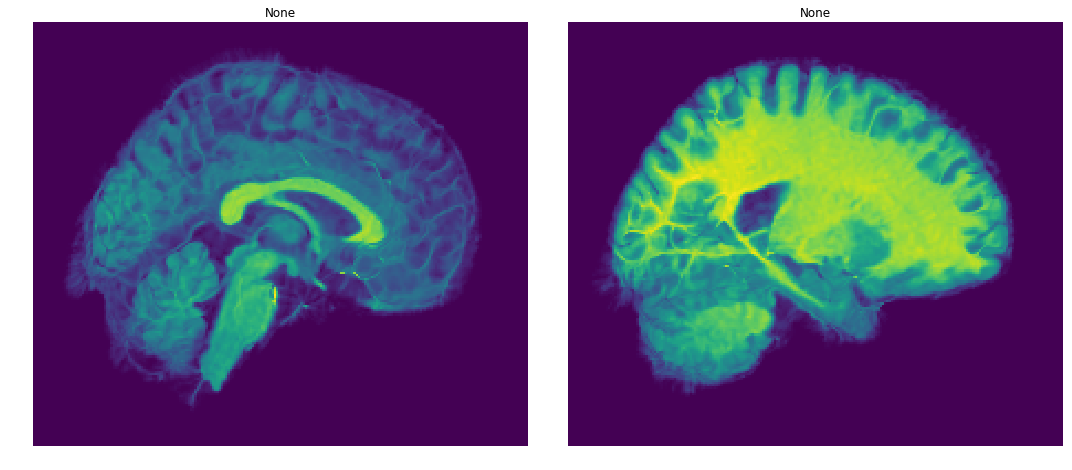

img shape (1, 160, 192, 224, 1)
atlas shape (1, 160, 192, 224, 1)
(1, 2286601, 1)
I_a max 0.9985304905622919
I_b max 0.9820078648594118
(1, 2583839, 1)
I_a max 0.9985304905622919
I_b max 0.9820078648594118
original image min max 0.6862745098039216 0.0
img min max 0.62341404 0.0
flow min max 12.349078 -13.967383


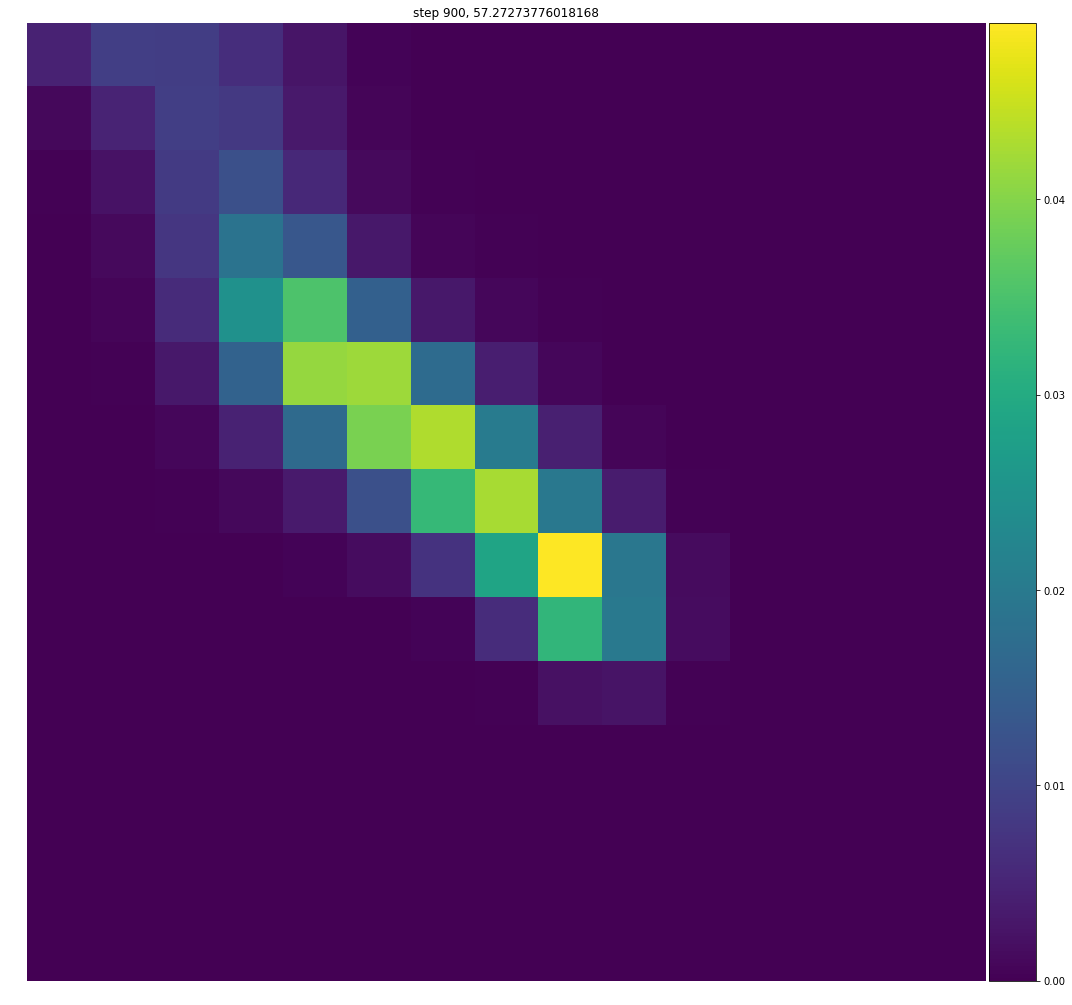

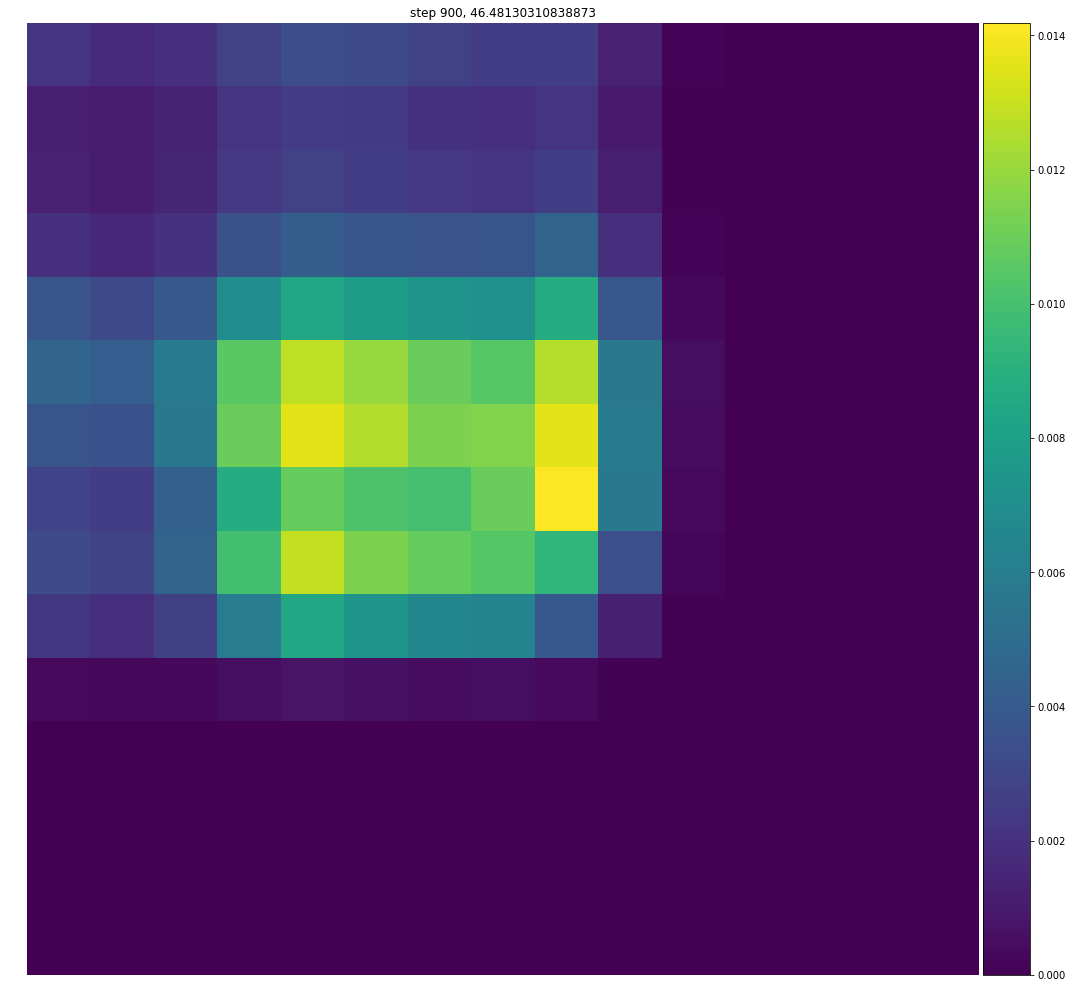

pab min max 0.09425928807653969 1.4124780080496467e-26
900,1,-0.006191552,-0.6681115,0.048956275
901,1,-0.0065652933,-0.693969,0.037439696
902,1,-0.0064920243,-0.6882405,0.03903806
903,1,-0.0064865504,-0.6864998,0.037844714
904,1,-0.006426138,-0.68300617,0.040392347
905,1,-0.0064175315,-0.68346035,0.041707188
906,1,-0.006546473,-0.6950776,0.040430233
907,1,-0.006207335,-0.66816616,0.047432672
908,1,-0.00658119,-0.6965033,0.03838428
909,1,-0.0064558564,-0.69034076,0.04475511
910,1,-0.006392928,-0.6814221,0.04212932
911,1,-0.006471584,-0.6876479,0.04048942
912,1,-0.0066650975,-0.7028253,0.036315516
913,1,-0.0065640714,-0.69417214,0.03776498
914,1,-0.006498557,-0.6877093,0.03785357
915,1,-0.0065340498,-0.69244266,0.039037652
916,1,-0.0064075035,-0.6840273,0.043276936
917,1,-0.006487145,-0.68851924,0.03980471
918,1,-0.006444941,-0.6842889,0.03979481
919,1,-0.0064942325,-0.68874645,0.03932319
920,1,-0.006429556,-0.68440413,0.04144857
921,1,-0.0064547895,-0.6850012,0.039522216
922,1,-0.00658

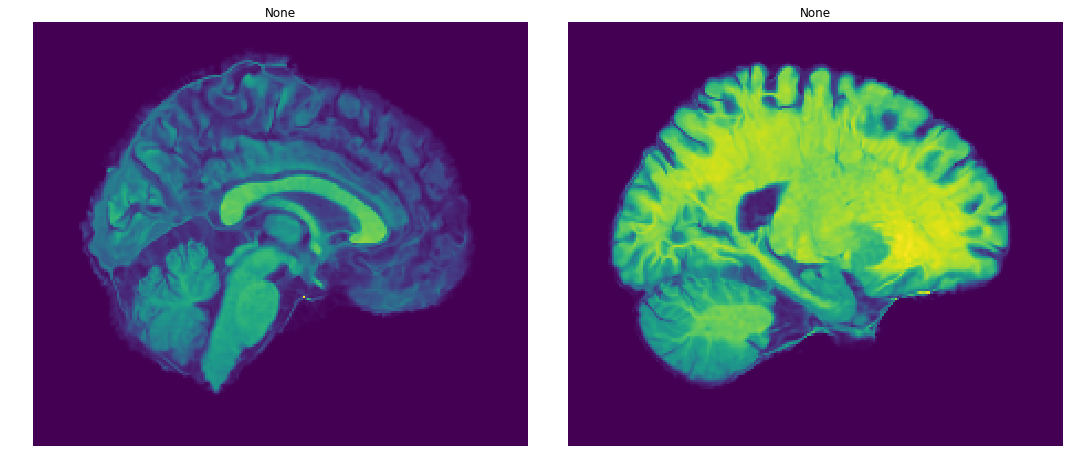

img shape (1, 160, 192, 224, 1)
atlas shape (1, 160, 192, 224, 1)
(1, 2126227, 1)
I_a max 0.9985304905622919
I_b max 0.9820078648594118
(1, 2454821, 1)
I_a max 0.9985304905622919
I_b max 0.9820078648594118
original image min max 0.7607843137254902 0.0
img min max 0.6585413 0.0
flow min max 11.980217 -11.15359


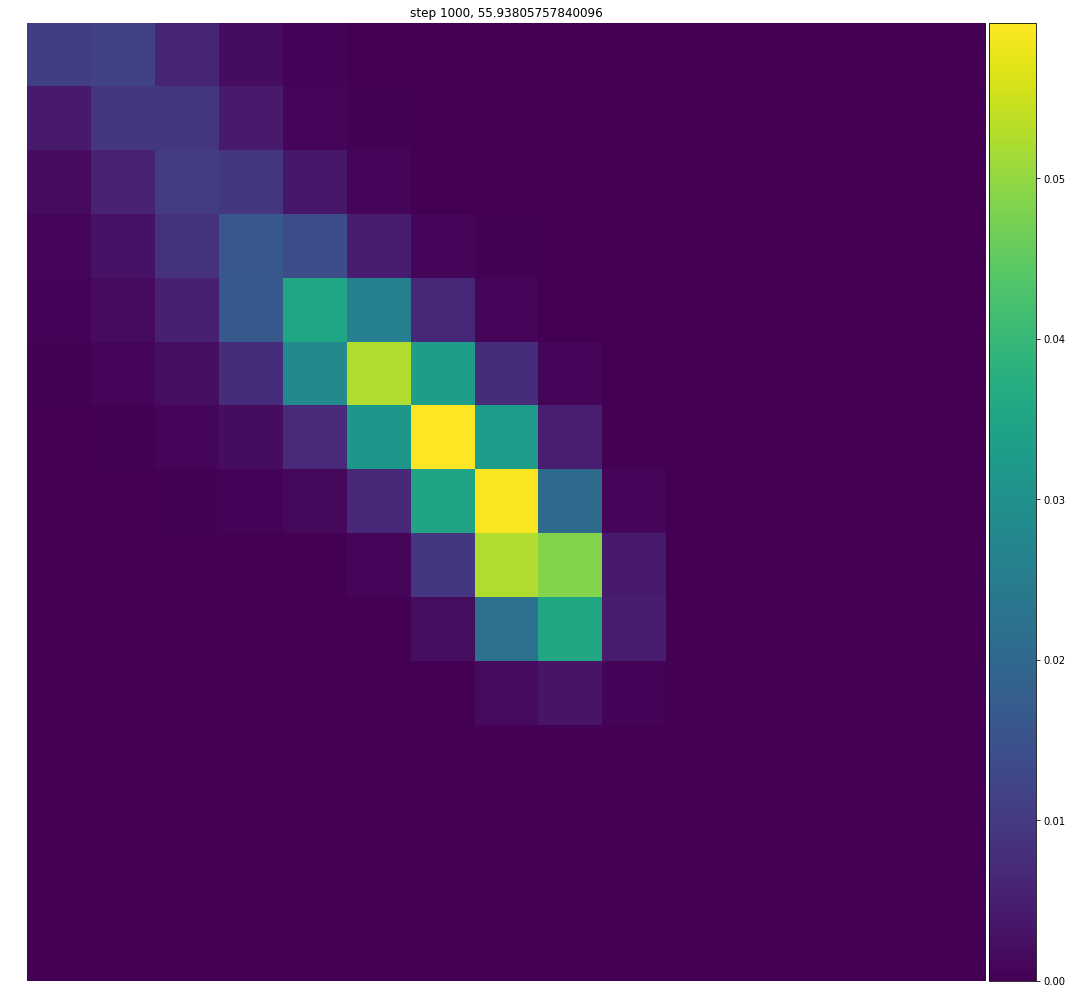

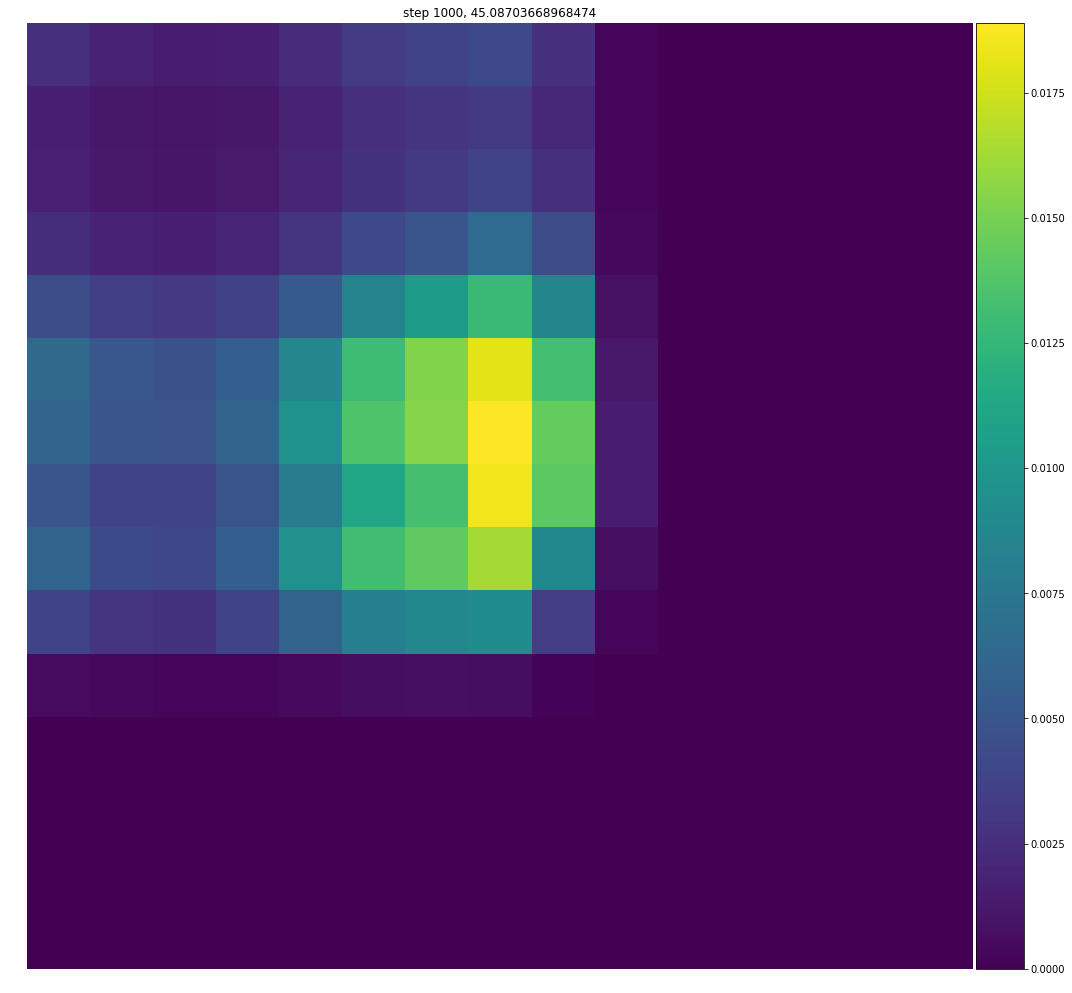

pab min max 0.07627085797589275 3.0943853766468975e-40
1000,1,-0.00640111,-0.68065536,0.040544324
1001,1,-0.0065013906,-0.6893822,0.039243117
1002,1,-0.006636572,-0.70035696,0.03669974
1003,1,-0.006594348,-0.6965168,0.037082016
1004,1,-0.0063970964,-0.6811513,0.041441627
1005,1,-0.006501941,-0.68773115,0.037537053
1006,1,-0.0065436657,-0.6909555,0.036588896
1007,1,-0.0065344176,-0.6925541,0.039112322
1008,1,-0.00636621,-0.67979074,0.04316976
1009,1,-0.0064208424,-0.68170655,0.03962227
1010,1,-0.006344268,-0.677361,0.042934194
1011,1,-0.0066605243,-0.7019074,0.035854947
1012,1,-0.0066237208,-0.70154476,0.03917268
1013,1,-0.0061840327,-0.66934854,0.050945267
1014,1,-0.0061215092,-0.6568482,0.044697262
1015,1,-0.006403119,-0.67932343,0.039011523
1016,1,-0.0064009684,-0.6801709,0.04007401
1017,1,-0.0064428276,-0.68288434,0.038601555
1018,1,-0.0064915675,-0.6877751,0.038618315
1019,1,-0.0064112567,-0.6810312,0.039905556
1020,1,-0.0063871867,-0.6821065,0.043387815
1021,1,-0.0064740838,-0.686

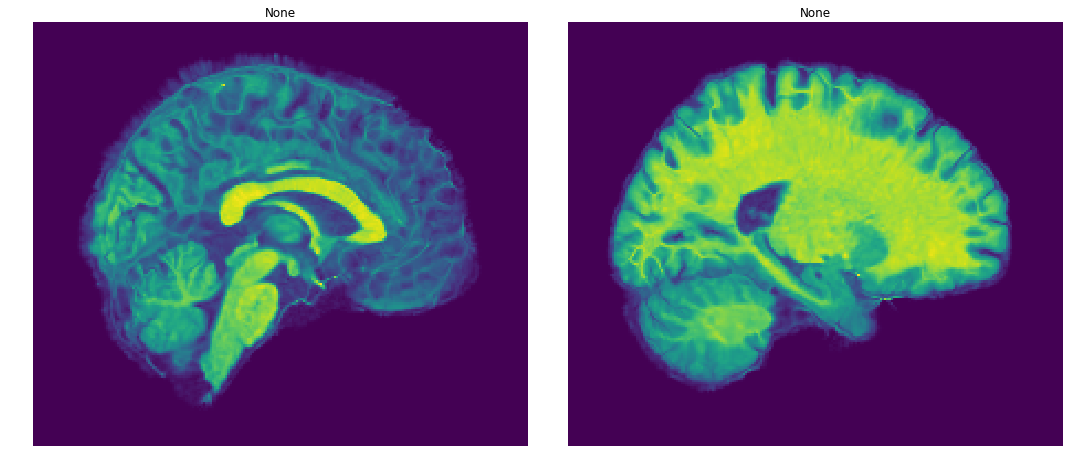

img shape (1, 160, 192, 224, 1)
atlas shape (1, 160, 192, 224, 1)
(1, 2230638, 1)
I_a max 0.9985304905622919
I_b max 0.9820078648594118
(1, 2544349, 1)
I_a max 0.9985304905622919
I_b max 0.9820078648594118
original image min max 0.9058823529411765 0.0
img min max 0.78454775 0.0
flow min max 11.103491 -11.614868


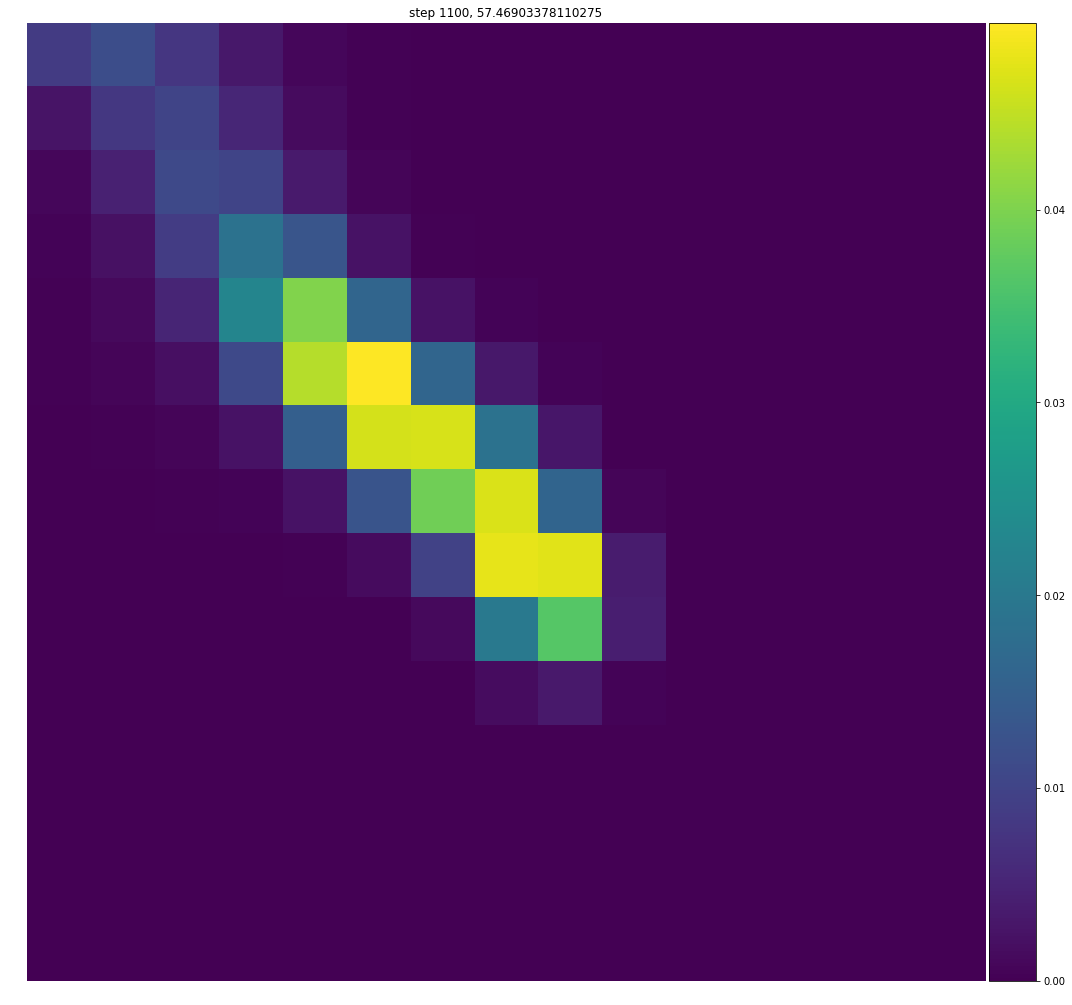

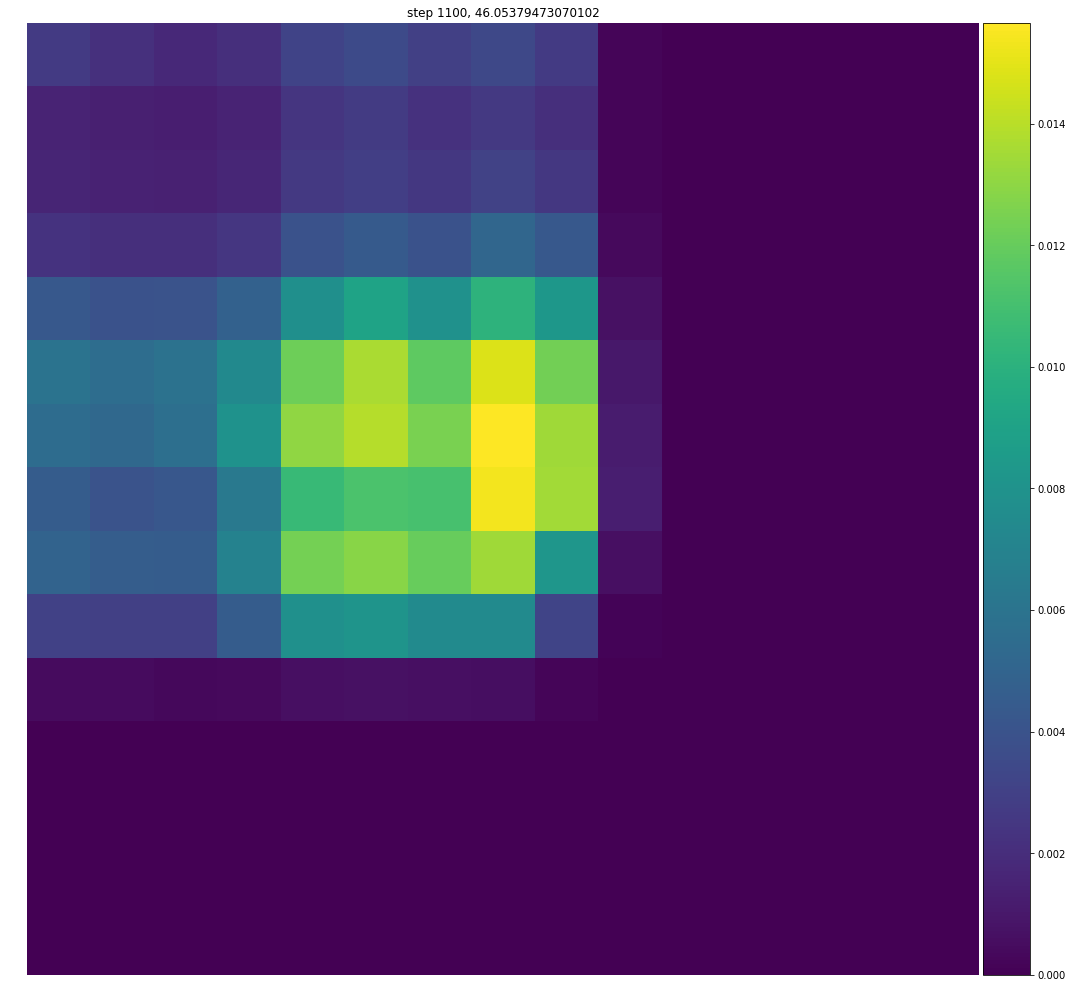

pab min max 0.08060582637413366 1.979354932819367e-34
1100,1,-0.0064561027,-0.6851279,0.03951763
1101,1,-0.0065520173,-0.69067526,0.035473537
1102,1,-0.006497658,-0.69011575,0.040349983
1103,1,-0.006515375,-0.6910342,0.039496697
1104,1,-0.006425941,-0.68372107,0.041126974
1105,1,-0.0064762714,-0.6884602,0.040832993
1106,1,-0.0064847805,-0.6893742,0.040896147
1107,1,-0.0064984034,-0.69027376,0.04043343
1108,1,-0.00638495,-0.67999756,0.041502547
1109,1,-0.006488289,-0.68869346,0.03986454
1110,1,-0.006500205,-0.6881267,0.038106196
1111,1,-0.0066123353,-0.70059276,0.039359223
1112,1,-0.0061798086,-0.6700719,0.05209103
1113,1,-0.006490844,-0.6870889,0.038004547
1114,1,-0.0066459496,-0.70334196,0.03874696
1115,1,-0.006430475,-0.6838196,0.04077211
1116,1,-0.0042387713,-0.5445006,0.12062347
1117,1,-0.006548263,-0.6929785,0.038152203
1118,1,-0.0064922306,-0.687921,0.03869788
1119,1,-0.006267083,-0.6729999,0.046291616
1120,1,-0.006424265,-0.68263096,0.04020446
1121,1,-0.0065222895,-0.6917247,0.0

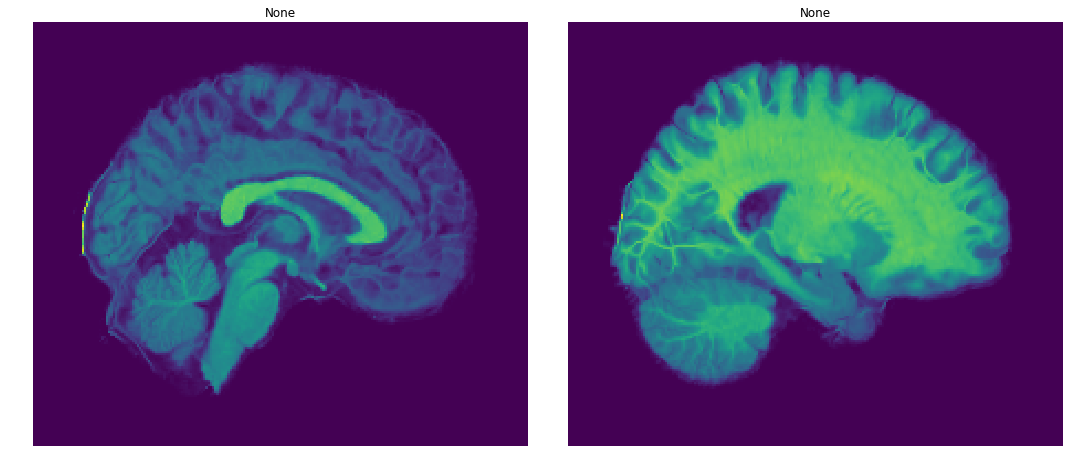

img shape (1, 160, 192, 224, 1)
atlas shape (1, 160, 192, 224, 1)
(1, 2153743, 1)
I_a max 0.9985304905622919
I_b max 0.9820078648594118
(1, 2480667, 1)
I_a max 0.9985304905622919
I_b max 0.9820078648594118
original image min max 0.8588235294117647 0.0
img min max 0.68707883 0.0
flow min max 10.357674 -12.524538


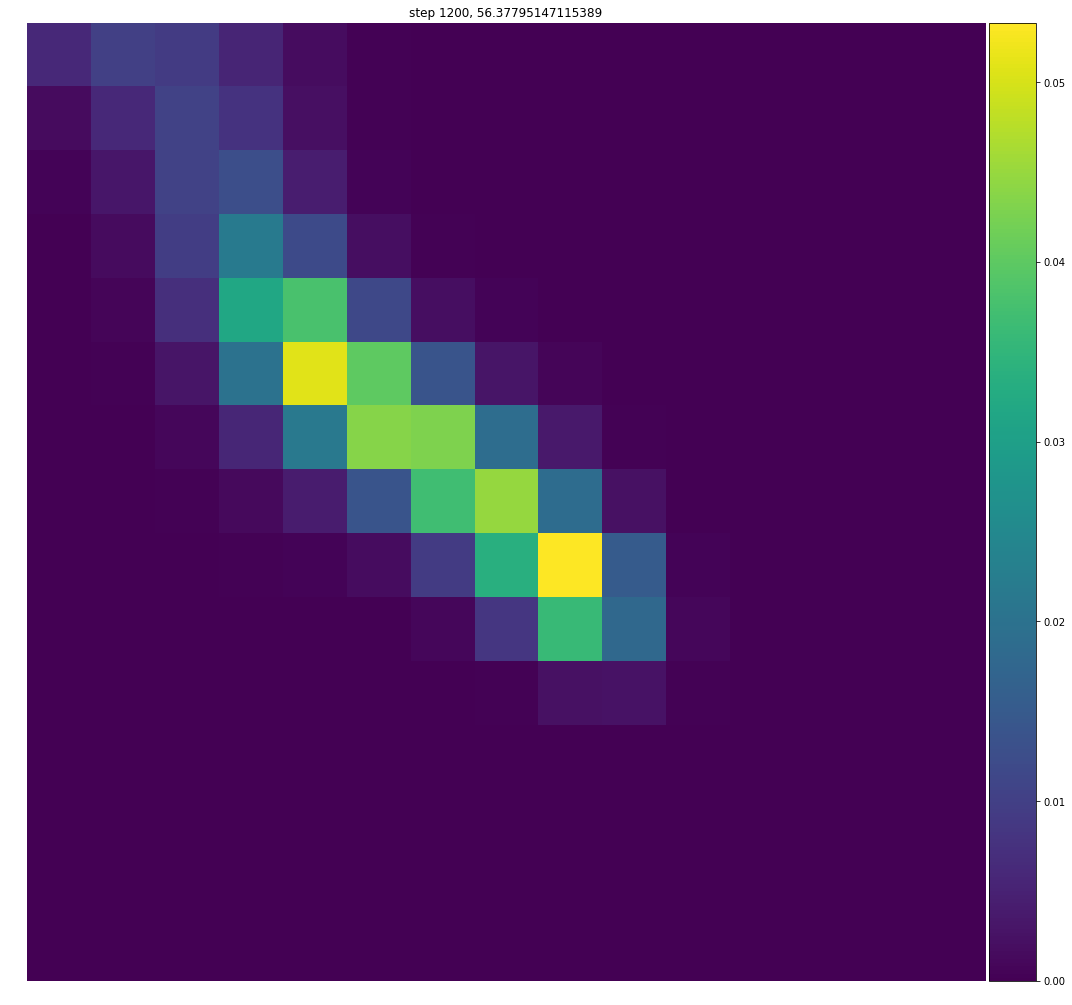

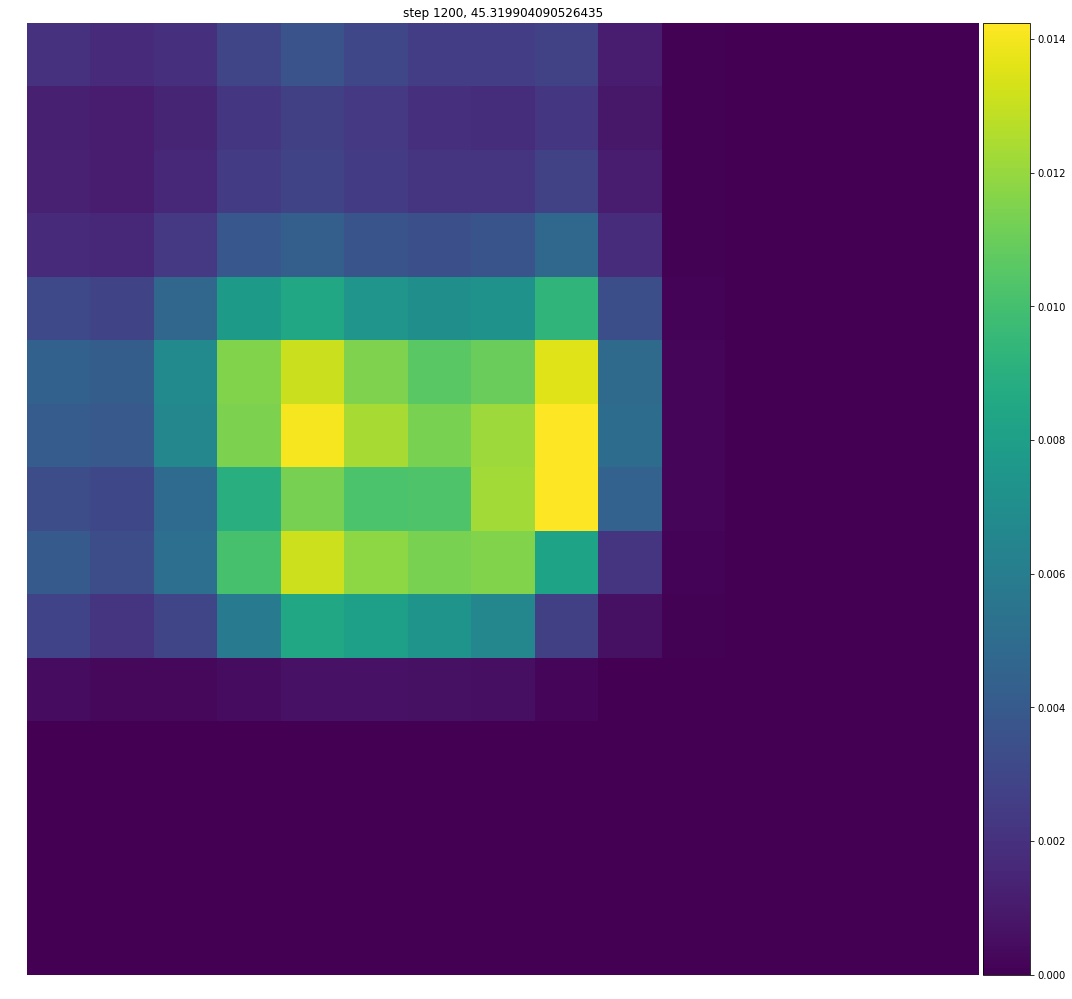

pab min max 0.0816115224569013 2.9489299602623726e-32
1200,1,-0.006418016,-0.6851236,0.043321997
1201,1,-0.006532845,-0.69053864,0.03725409
1202,1,-0.0065863356,-0.69722635,0.038592745
1203,1,-0.0065166373,-0.6921356,0.04047185
1204,1,-0.006390244,-0.67976856,0.040744167
1205,1,-0.00660268,-0.698826,0.038558003
1206,1,-0.0064600967,-0.68780935,0.041799664
1207,1,-0.006565096,-0.69551116,0.03900157
1208,1,-0.0044770297,-0.55660534,0.108902365
1209,1,-0.006507573,-0.689128,0.03837065
1210,1,-0.0065864036,-0.6941004,0.035460025
1211,1,-0.0064672427,-0.68460697,0.03788264
1212,1,-0.006456518,-0.6821228,0.03647099
1213,1,-0.006566344,-0.6953209,0.0386865
1214,1,-0.0064621936,-0.6876461,0.041426715
1215,1,-0.0064524817,-0.68589103,0.04064281
1216,1,-0.006485235,-0.68787026,0.03934676
1217,1,-0.006484221,-0.68729496,0.038872864
1218,1,-0.006540286,-0.6939862,0.039957553
1219,1,-0.0062110494,-0.67244875,0.05134383
1220,1,-0.006373016,-0.67862636,0.04132473
1221,1,-0.00660902,-0.6964451,0.03554

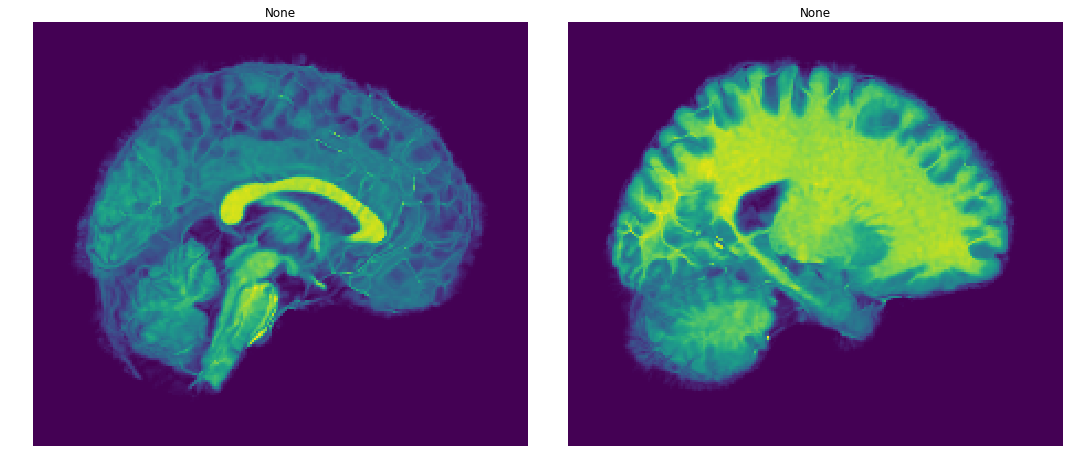

img shape (1, 160, 192, 224, 1)
atlas shape (1, 160, 192, 224, 1)
(1, 2245802, 1)
I_a max 0.9985304905622919
I_b max 0.9820078648594118
(1, 2562916, 1)
I_a max 0.9985304905622919
I_b max 0.9820078648594118
original image min max 0.796078431372549 0.0
img min max 0.7268032 0.0
flow min max 13.239686 -15.229411


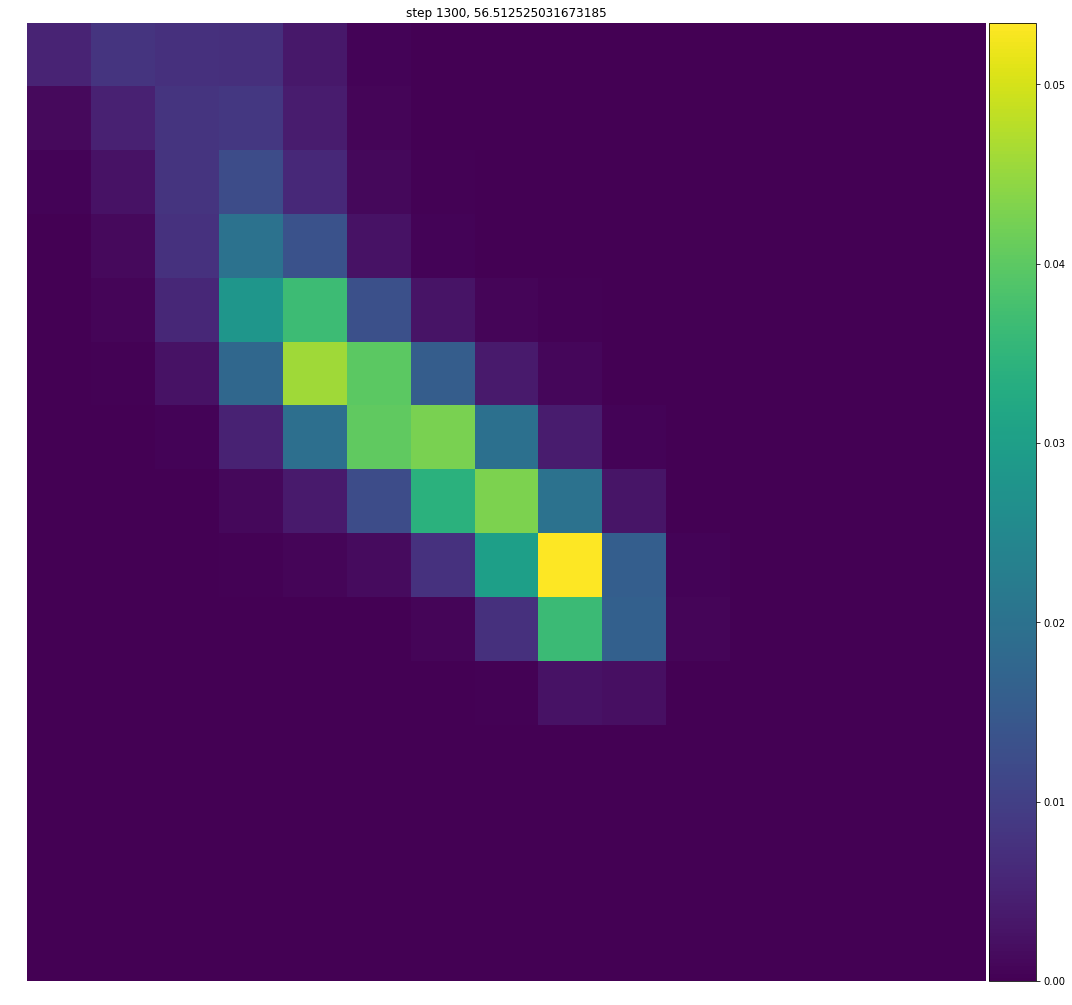

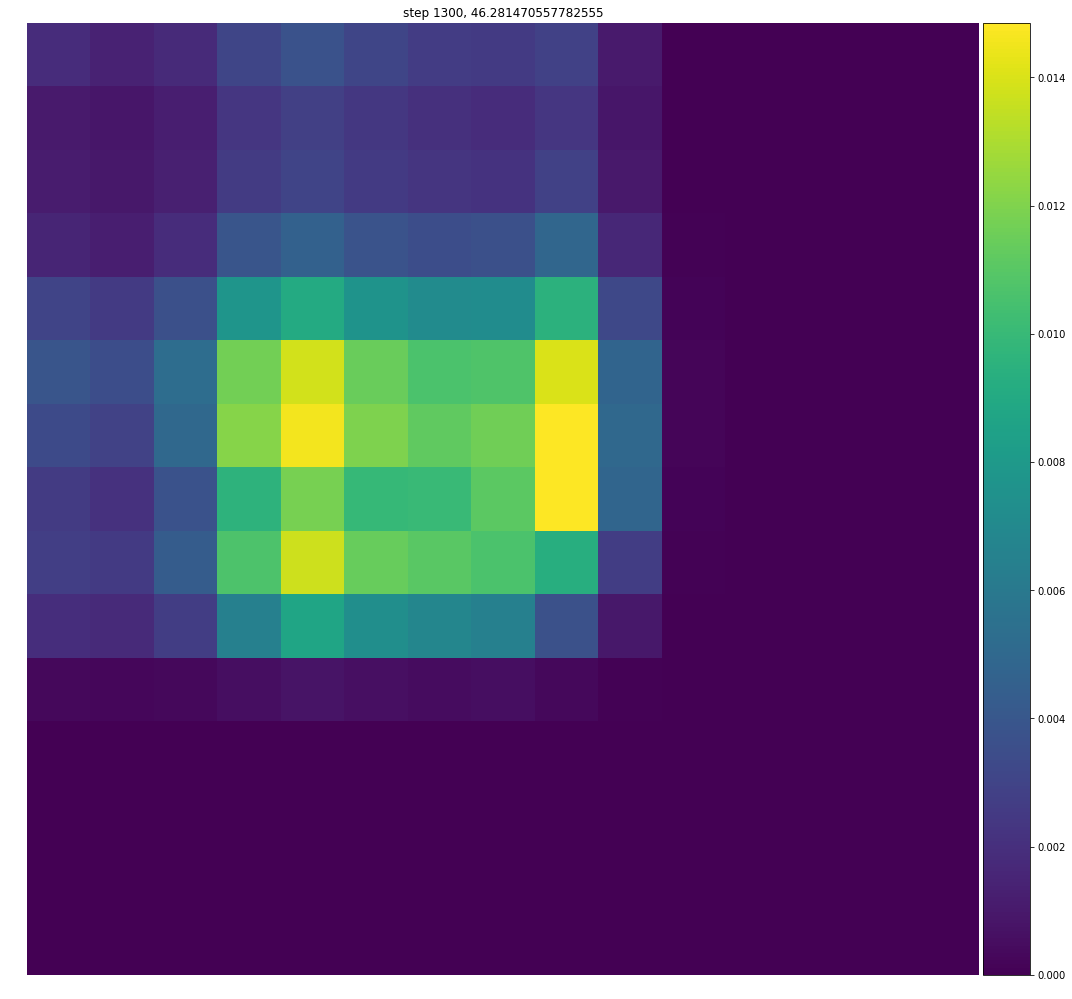

pab min max 0.09122473045653169 1.7881555038805268e-37
1300,1,-0.006157274,-0.6628659,0.04713848
1301,1,-0.006422634,-0.6812704,0.039007034
1302,1,-0.0065045184,-0.6884687,0.038016826
1303,1,-0.006477327,-0.68634003,0.038607303
1304,1,-0.0065224,-0.69157994,0.03933996
1305,1,-0.0065137423,-0.6903058,0.038931556
1306,1,-0.006194108,-0.67065614,0.051245317
1307,1,-0.0063983244,-0.68049115,0.040658686
1308,1,-0.006479753,-0.6882628,0.04028746
1309,1,-0.0063647567,-0.67742664,0.04095096
1310,1,-0.0064876014,-0.68644464,0.037684474
1311,1,-0.006371876,-0.6762841,0.03909644
1312,1,-0.0066489307,-0.7029482,0.038055144
1313,1,-0.0064784354,-0.6877904,0.03994686
1314,1,-0.00633381,-0.6781223,0.0447413
1315,1,-0.0062100445,-0.67629486,0.05529037
1316,1,-0.0062547736,-0.6706245,0.045147143
1317,1,-0.0065292236,-0.6922116,0.039289244
1318,1,-0.0065163258,-0.6902164,0.038583815
1319,1,-0.0064669745,-0.68736565,0.040668193
1320,1,-0.006448497,-0.68533397,0.040484276
1321,1,-0.006464076,-0.68826234,0

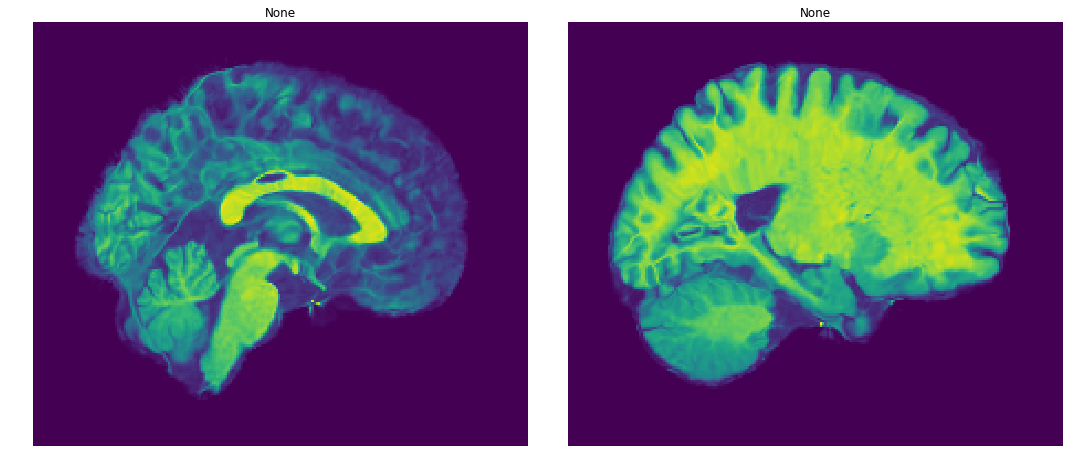

img shape (1, 160, 192, 224, 1)
atlas shape (1, 160, 192, 224, 1)
(1, 2113699, 1)
I_a max 0.9985304905622919
I_b max 0.9820078648594118
(1, 2451605, 1)
I_a max 0.9985304905622919
I_b max 0.9820078648594118
original image min max 0.7058823529411764 0.0
img min max 0.6204955 0.0
flow min max 12.649137 -14.94323


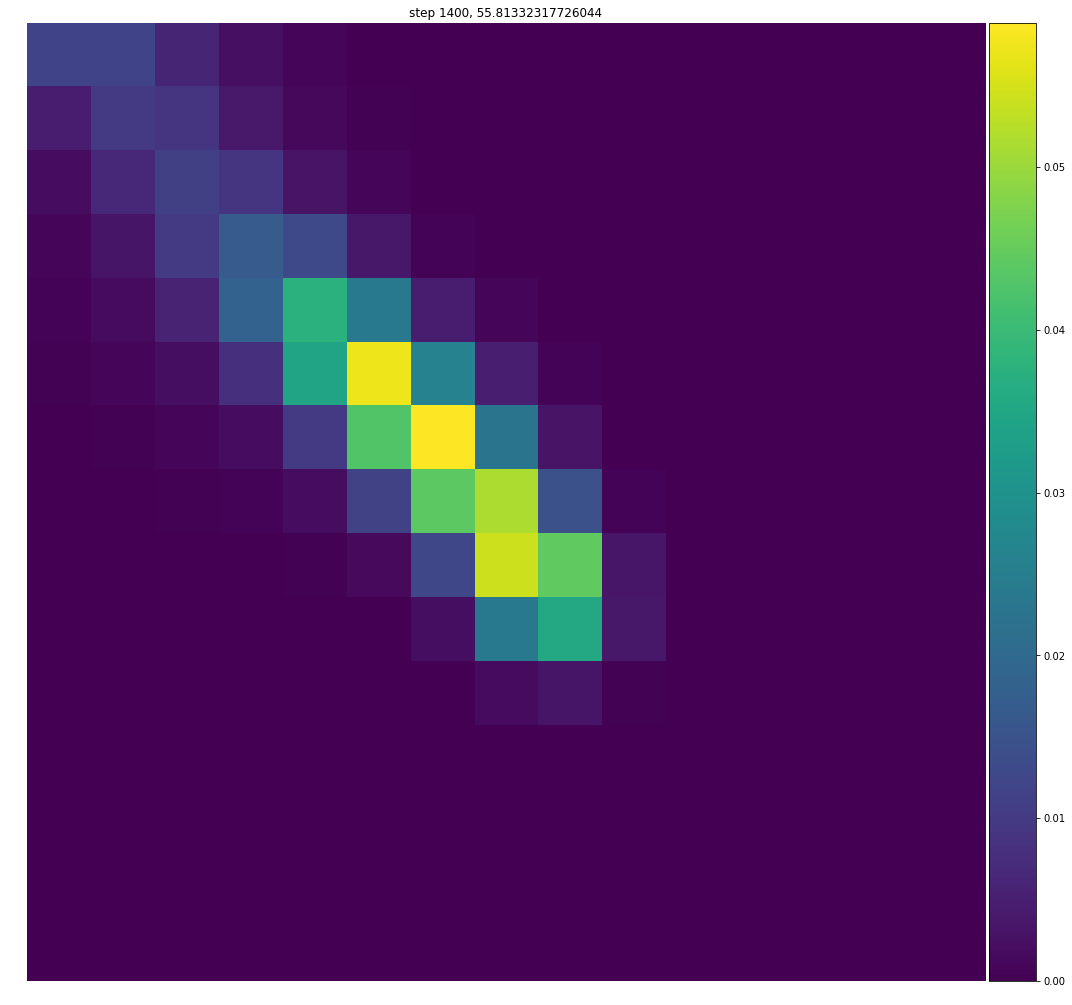

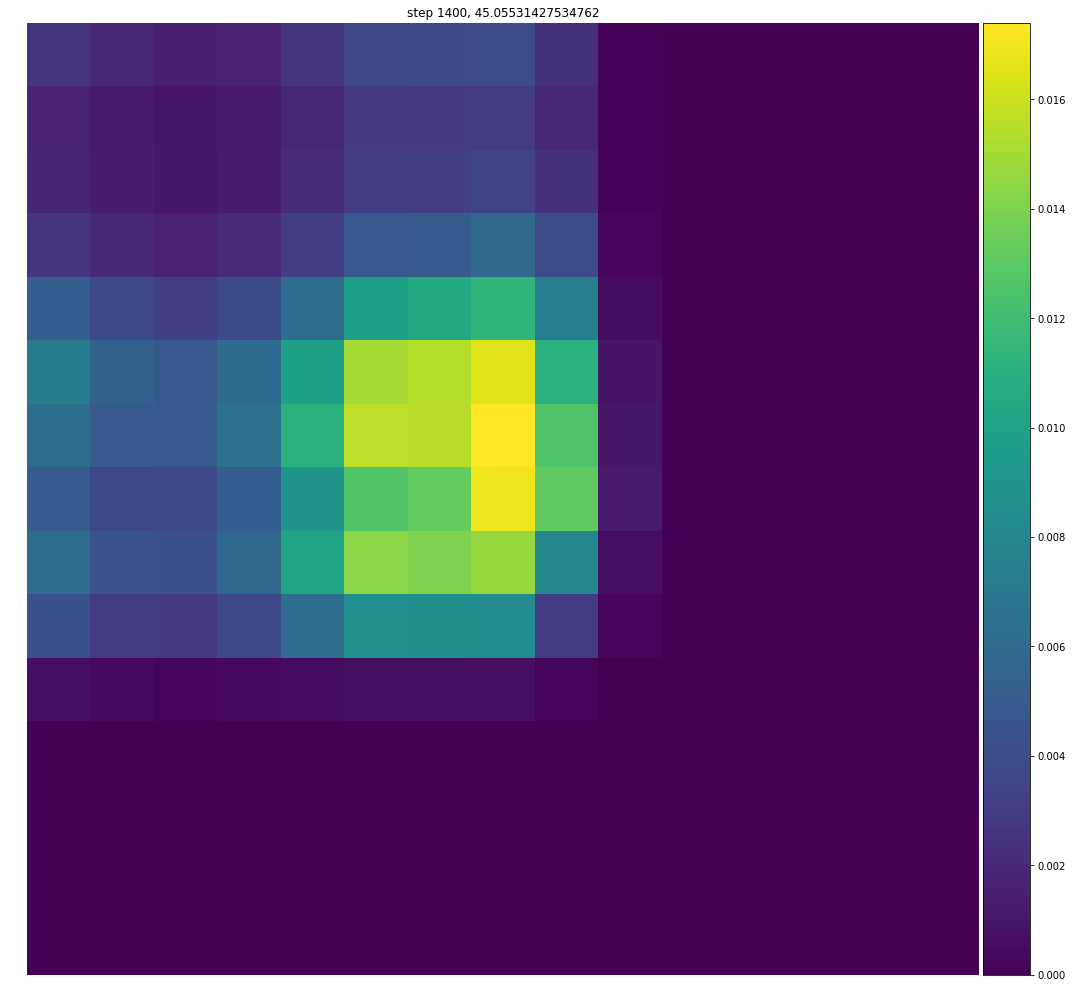

pab min max 0.06546982507951624 2.4874993279947014e-37
1400,1,-0.006401105,-0.68200344,0.041892942
1401,1,-0.0063422723,-0.6729859,0.038758658
1402,1,-0.006400911,-0.6825119,0.04242082
1403,1,-0.006526366,-0.6902902,0.037653618
1404,1,-0.006400561,-0.6820102,0.041954096
1405,1,-0.0063849036,-0.6811959,0.042705562
1406,1,-0.0064237835,-0.68295807,0.04057967
1407,1,-0.006398888,-0.6868241,0.046935312
1408,1,-0.006385392,-0.6824704,0.043931164
1409,1,-0.006297629,-0.67288196,0.043119088
1410,1,-0.006593661,-0.6957841,0.036417983
1411,1,-0.006579583,-0.6954159,0.0374576
1412,1,-0.0064288825,-0.6838853,0.040997025
1413,1,-0.0064107184,-0.6891154,0.04804355
1414,1,-0.006497179,-0.6884191,0.03870117
1415,1,-0.006335489,-0.67688715,0.04333825
1416,1,-0.0065030786,-0.6887667,0.038458847
1417,1,-0.0065295706,-0.6930541,0.040097013
1418,1,-0.0065713893,-0.69560575,0.03846682
1419,1,-0.006564629,-0.69448453,0.038021605
1420,1,-0.00603988,-0.65321296,0.0492249
1421,1,-0.006550739,-0.6941242,0.03905

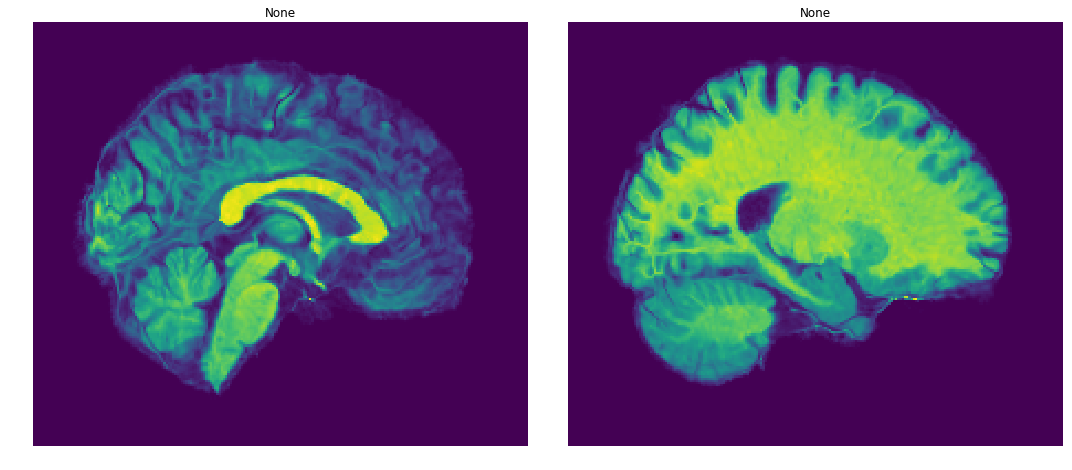

img shape (1, 160, 192, 224, 1)
atlas shape (1, 160, 192, 224, 1)
(1, 2228076, 1)
I_a max 0.9985304905622919
I_b max 0.9820078648594118
(1, 2539599, 1)
I_a max 0.9985304905622919
I_b max 0.9820078648594118
original image min max 0.7647058823529411 0.0
img min max 0.6205694 -0.0048264894
flow min max 10.268972 -12.348905


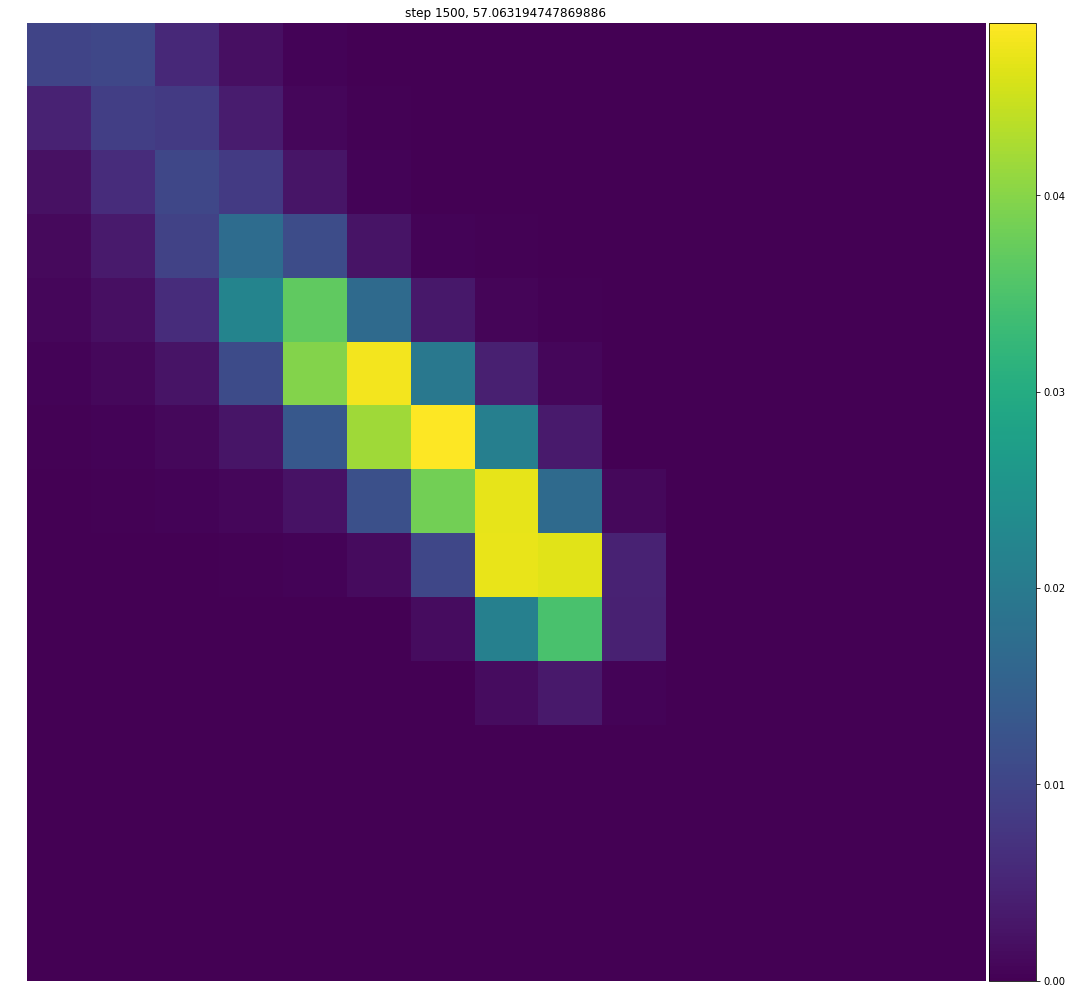

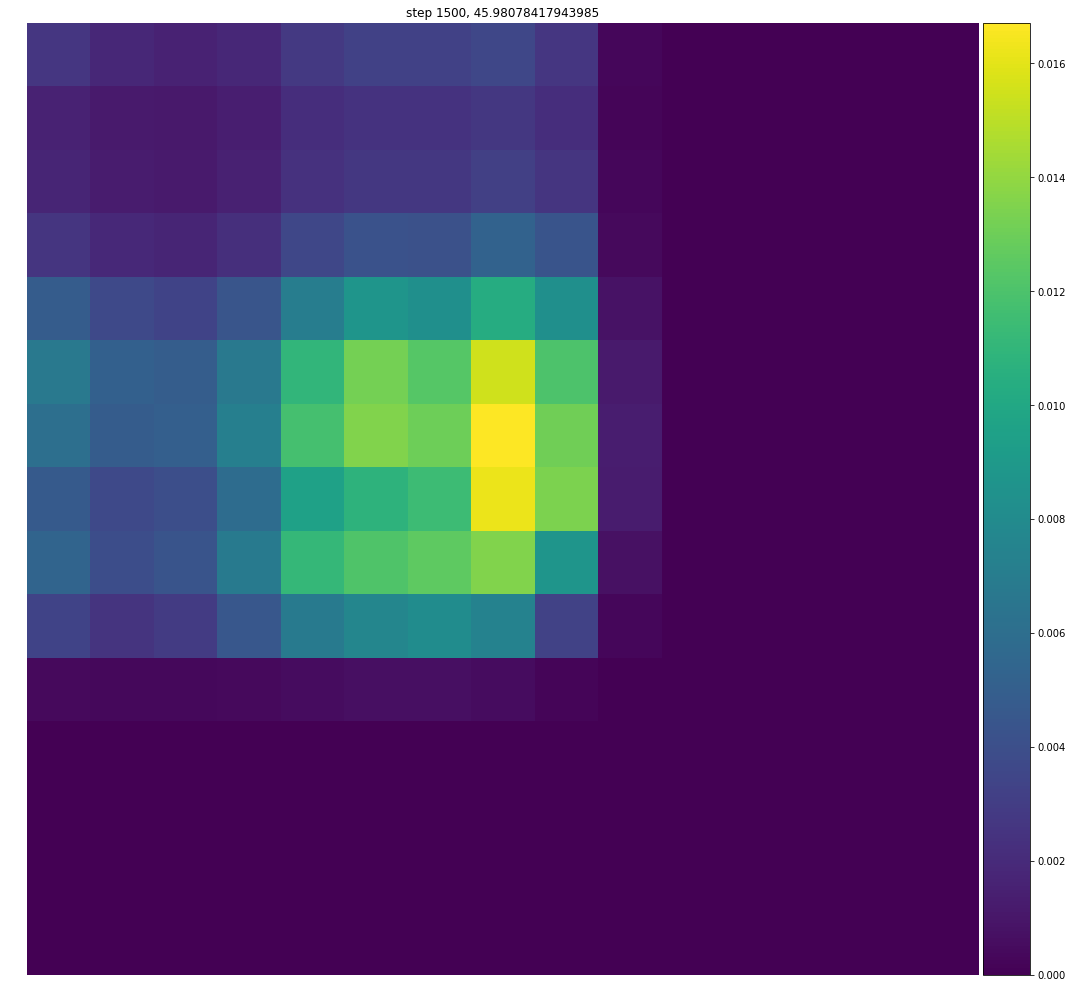

pab min max 0.10296400276540403 1.0967757843912767e-40
1500,1,-0.0063253553,-0.67380375,0.0412682
1501,1,-0.0063765263,-0.67730856,0.039655894
1502,1,-0.0065962775,-0.6946214,0.03499363
1503,1,-0.00649614,-0.68933463,0.03972062
1504,1,-0.0065494915,-0.6940299,0.03908078
1505,1,-0.006530229,-0.6932113,0.040188394
1506,1,-0.0064235446,-0.6850733,0.042718854
1507,1,-0.0065526688,-0.6953647,0.040097803
1508,1,-0.0060606194,-0.661083,0.05502104
1509,1,-0.006275037,-0.6743452,0.046841457
1510,1,-0.0059522768,-0.64674175,0.05151406
1511,1,-0.006514141,-0.68640363,0.034989506
1512,1,-0.006610313,-0.6935958,0.032564532
1513,1,-0.0065120705,-0.68759316,0.036386073
1514,1,-0.0063359784,-0.67563796,0.042040102
1515,1,-0.0065469802,-0.69271636,0.038018316
1516,1,-0.006519142,-0.6923861,0.040471867
1517,1,-0.0059999553,-0.6509817,0.0509862
1518,1,-0.0064240037,-0.68403673,0.04163634
1519,1,-0.0065175067,-0.6880295,0.03627885
1520,1,-0.0057742023,-0.6369188,0.05949852
1521,1,-0.0064217867,-0.6792134,

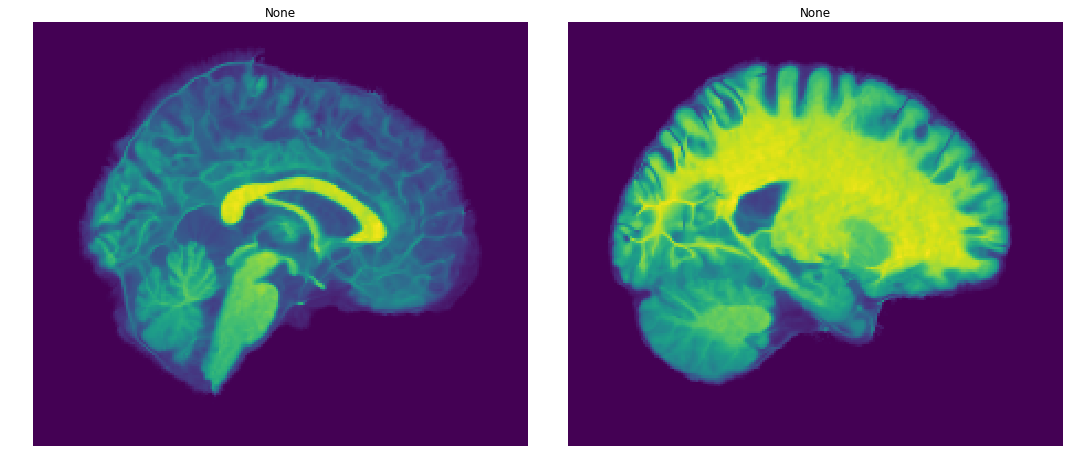

img shape (1, 160, 192, 224, 1)
atlas shape (1, 160, 192, 224, 1)
(1, 2187195, 1)
I_a max 0.9985304905622919
I_b max 0.9820078648594118
(1, 2496085, 1)
I_a max 0.9985304905622919
I_b max 0.9820078648594118
original image min max 0.49019607843137253 0.0
img min max 0.48725808 0.0
flow min max 12.616953 -12.106555


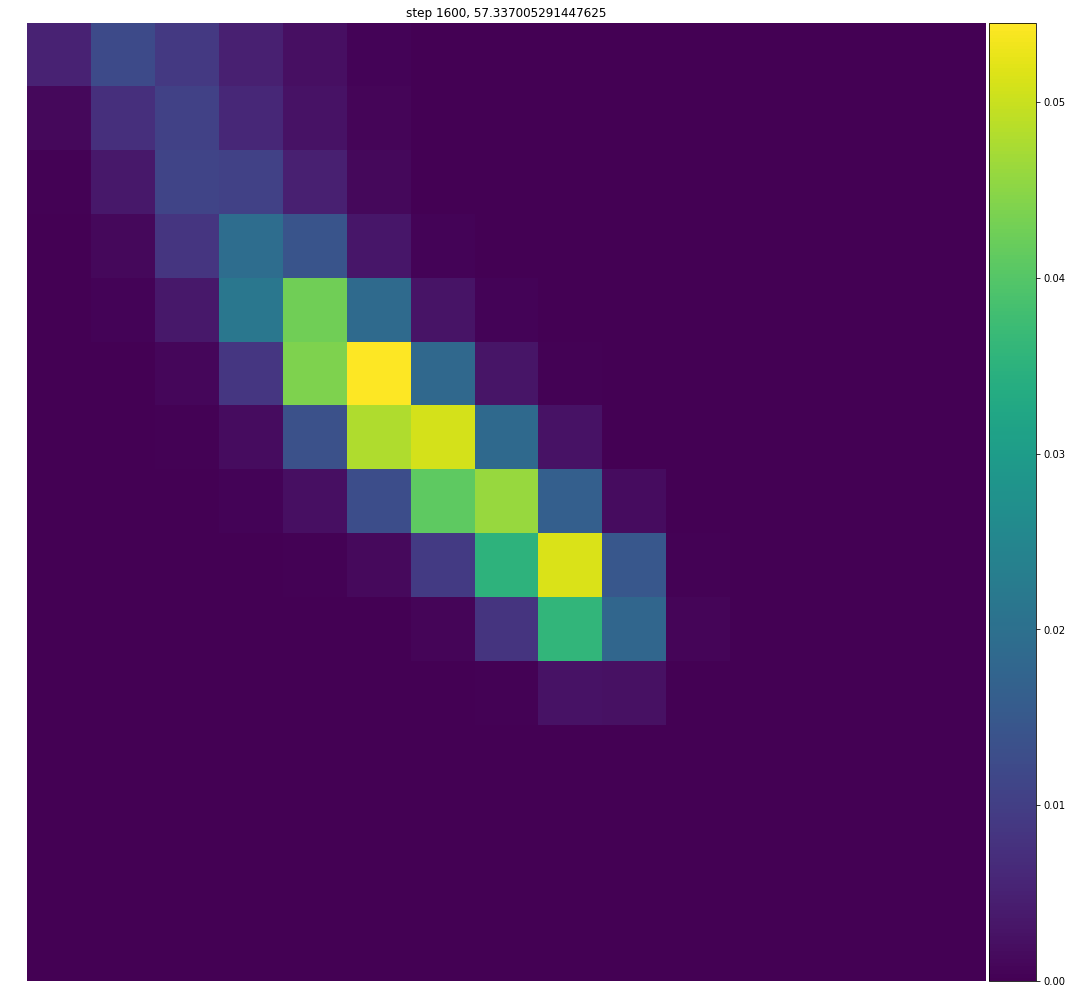

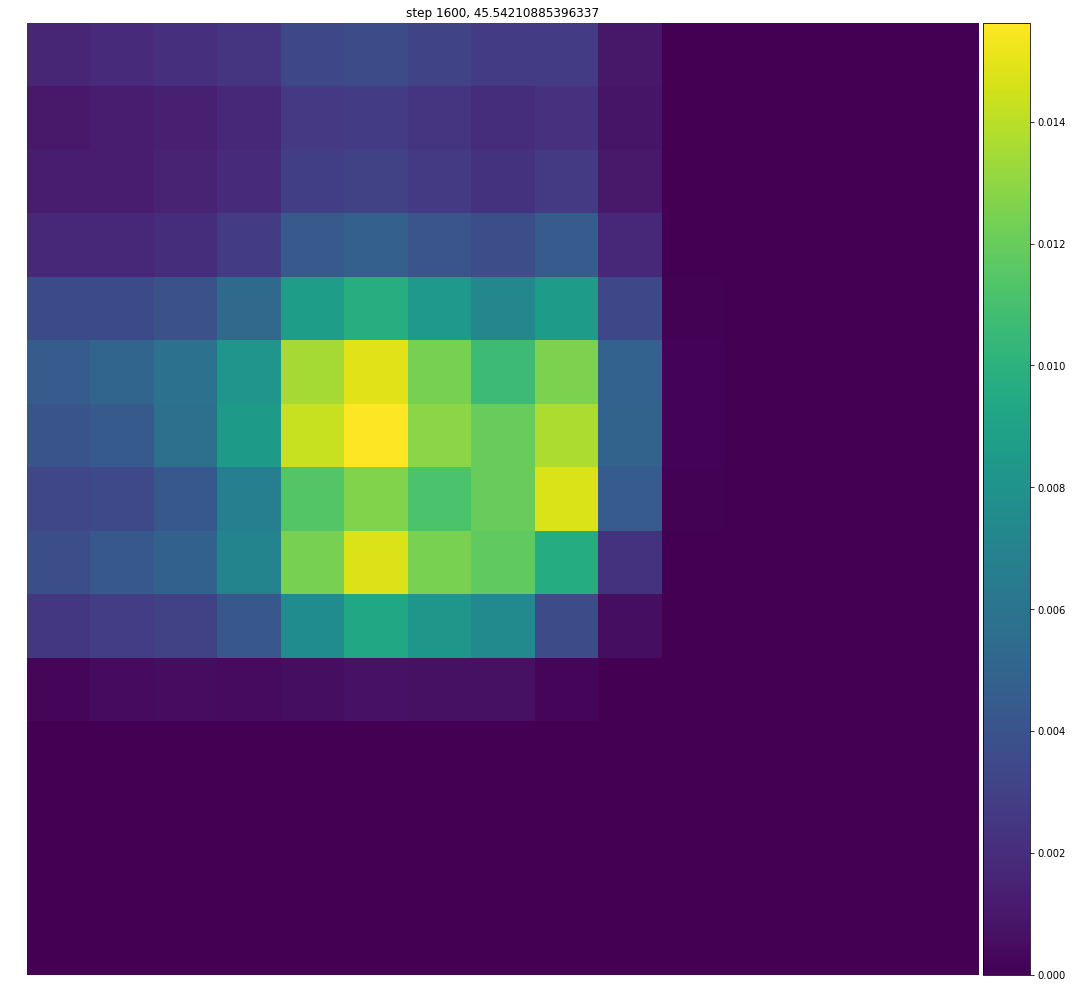

pab min max 0.07463084539420176 3.904347941089238e-38
1600,1,-0.006567192,-0.6958669,0.03914769
1601,1,-0.006520204,-0.69113934,0.03911894
1602,1,-0.006468036,-0.6861876,0.039383993
1603,1,-0.006494293,-0.69134533,0.041916035
1604,1,-0.006419317,-0.6857764,0.043844722
1605,1,-0.006485382,-0.68777245,0.03923423
1606,1,-0.006210995,-0.6670252,0.04592569
1607,1,-0.00648129,-0.6862842,0.03815515
1608,1,-0.006552569,-0.6891042,0.03384728
1609,1,-0.006468489,-0.68383867,0.036989775
1610,1,-0.006577785,-0.6928001,0.03502158
1611,1,-0.0065325415,-0.6918565,0.03860234
1612,1,-0.0063046236,-0.6738686,0.04340626
1613,1,-0.0064354655,-0.68406296,0.040516406
1614,1,-0.006543129,-0.6943825,0.04006953
1615,1,-0.0063560796,-0.67750365,0.041895695
1616,1,-0.006453042,-0.68473357,0.039429374
1617,1,-0.006496277,-0.6864131,0.036785398
1618,1,-0.006500303,-0.6875469,0.0375166
1619,1,-0.006253804,-0.6666594,0.041279025
1620,1,-0.0063764947,-0.6792896,0.041640077
1621,1,-0.0065673287,-0.6944047,0.03767184
1

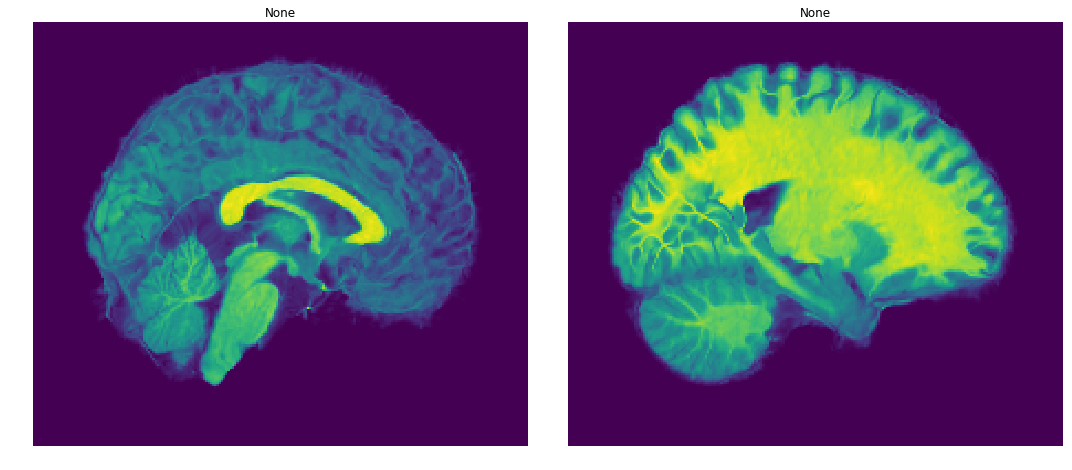

img shape (1, 160, 192, 224, 1)
atlas shape (1, 160, 192, 224, 1)
(1, 2187658, 1)
I_a max 0.9985304905622919
I_b max 0.9820078648594118
(1, 2493231, 1)
I_a max 0.9985304905622919
I_b max 0.9820078648594118
original image min max 0.8274509803921568 0.0
img min max 0.7176031 0.0
flow min max 12.073411 -13.155134


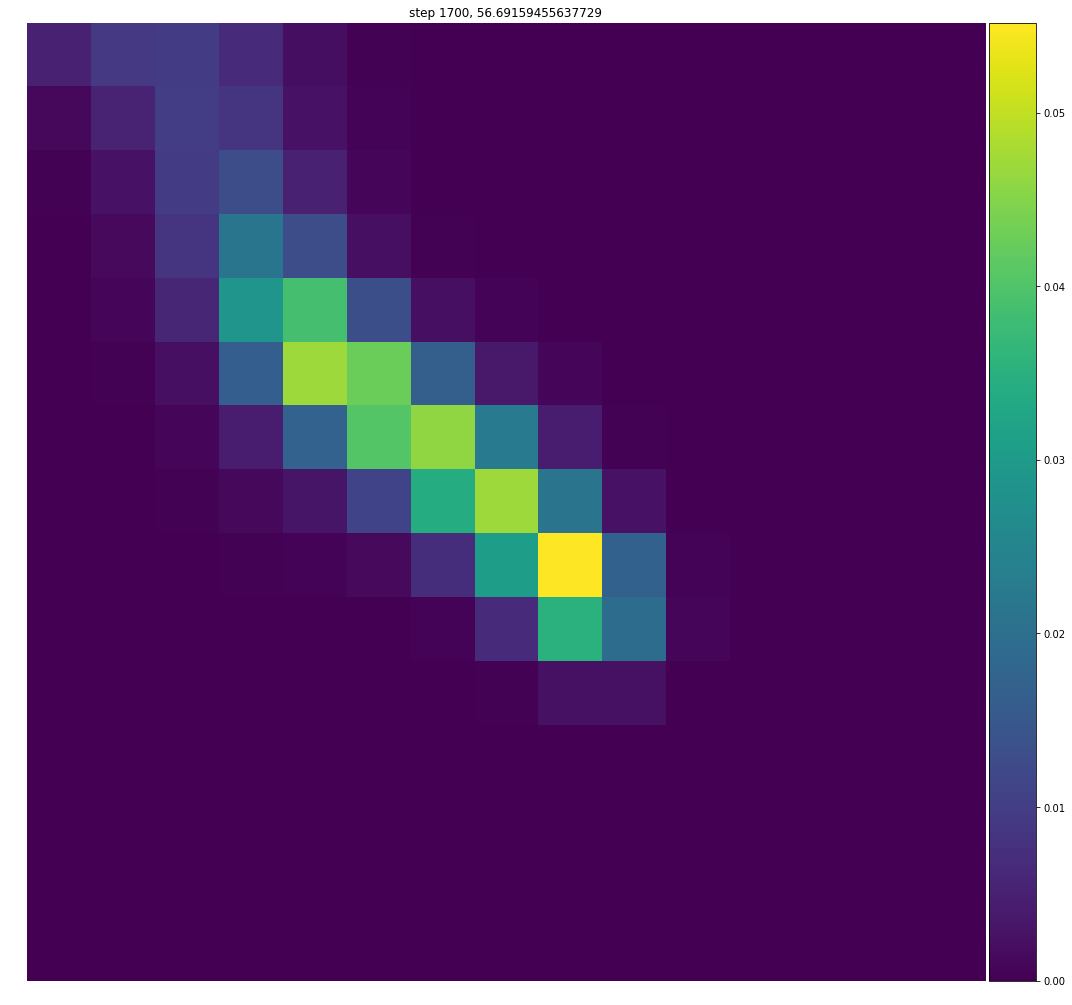

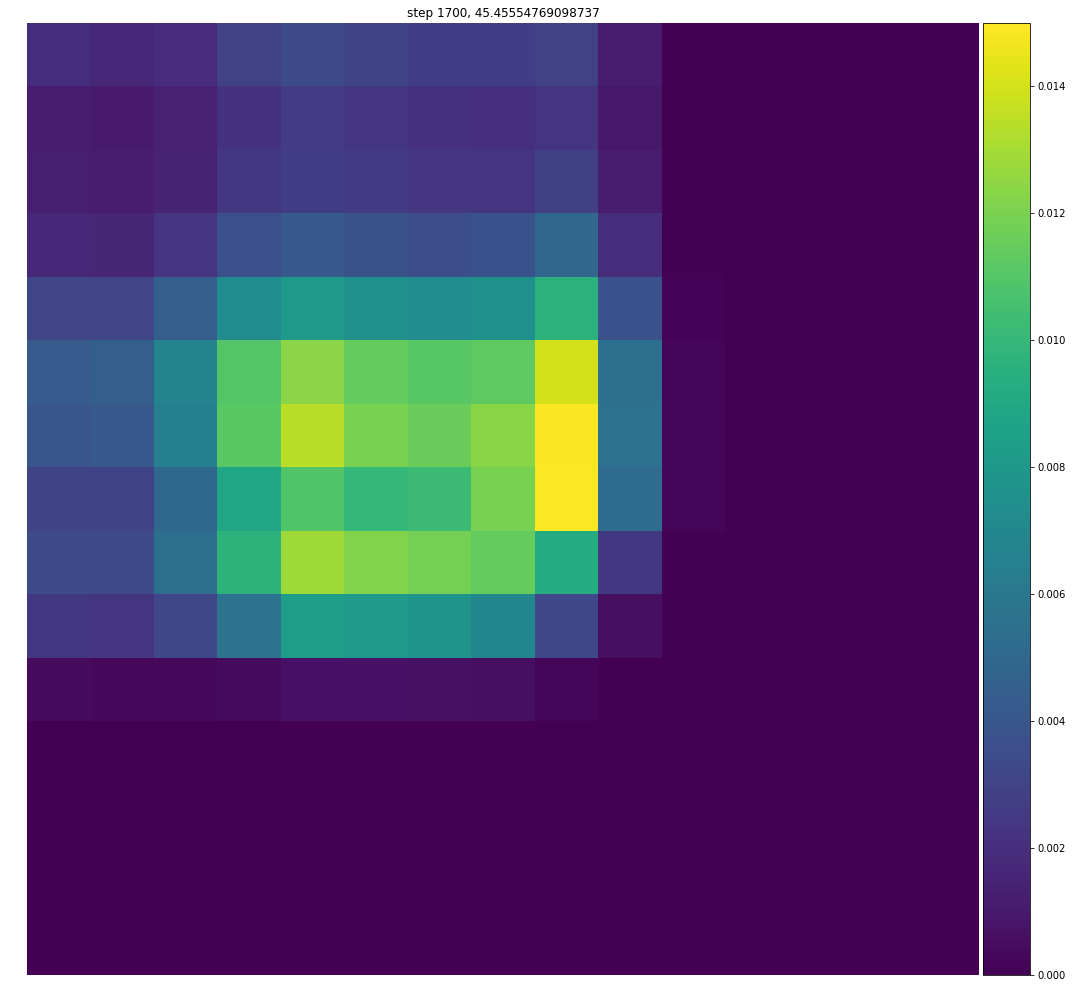

pab min max 0.08445119399457472 2.1121399256376093e-35
1700,1,-0.0063393903,-0.6824428,0.048503727
1701,1,-0.0065052775,-0.69231236,0.041784585
1702,1,-0.0062410436,-0.6700369,0.045932546
1703,1,-0.006220599,-0.66438854,0.04232861
1704,1,-0.006431291,-0.68191534,0.038786247
1705,1,-0.0061937375,-0.667443,0.048069175
1706,1,-0.0062898505,-0.67146176,0.042476714
1707,1,-0.006490317,-0.68803114,0.03899941
1708,1,-0.0062919836,-0.6736759,0.044477478
1709,1,-0.00657021,-0.6968713,0.039850213
1710,1,-0.006428275,-0.6821209,0.039293446
1711,1,-0.006535253,-0.6926045,0.0390792
1712,1,-0.0065222215,-0.69183135,0.039609205
1713,1,-0.0065840175,-0.69651896,0.038117178
1714,1,-0.0064408197,-0.6864843,0.042402275
1715,1,-0.0064023333,-0.6787131,0.038479753
1716,1,-0.0065728566,-0.6949608,0.037675112
1717,1,-0.006570926,-0.6922926,0.035199933
1718,1,-0.006536848,-0.6892887,0.035603873
1719,1,-0.006517121,-0.68721557,0.035503447
1720,1,-0.006466597,-0.68590176,0.039242048
1721,1,-0.006493205,-0.68908

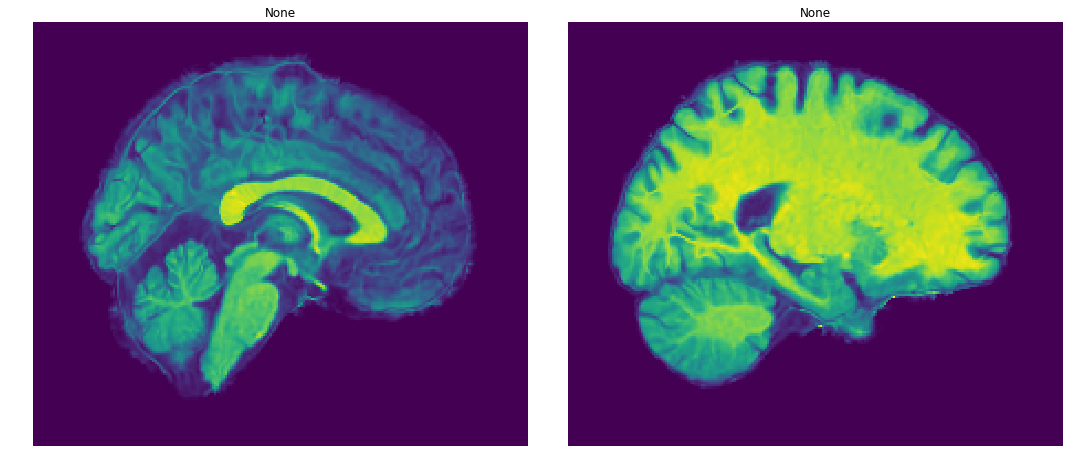

img shape (1, 160, 192, 224, 1)
atlas shape (1, 160, 192, 224, 1)
(1, 2157009, 1)
I_a max 0.9985304905622919
I_b max 0.9820078648594118
(1, 2494056, 1)
I_a max 0.9985304905622919
I_b max 0.9820078648594118
original image min max 0.7215686274509804 0.0
img min max 0.5105581 0.0
flow min max 10.441987 -12.160309


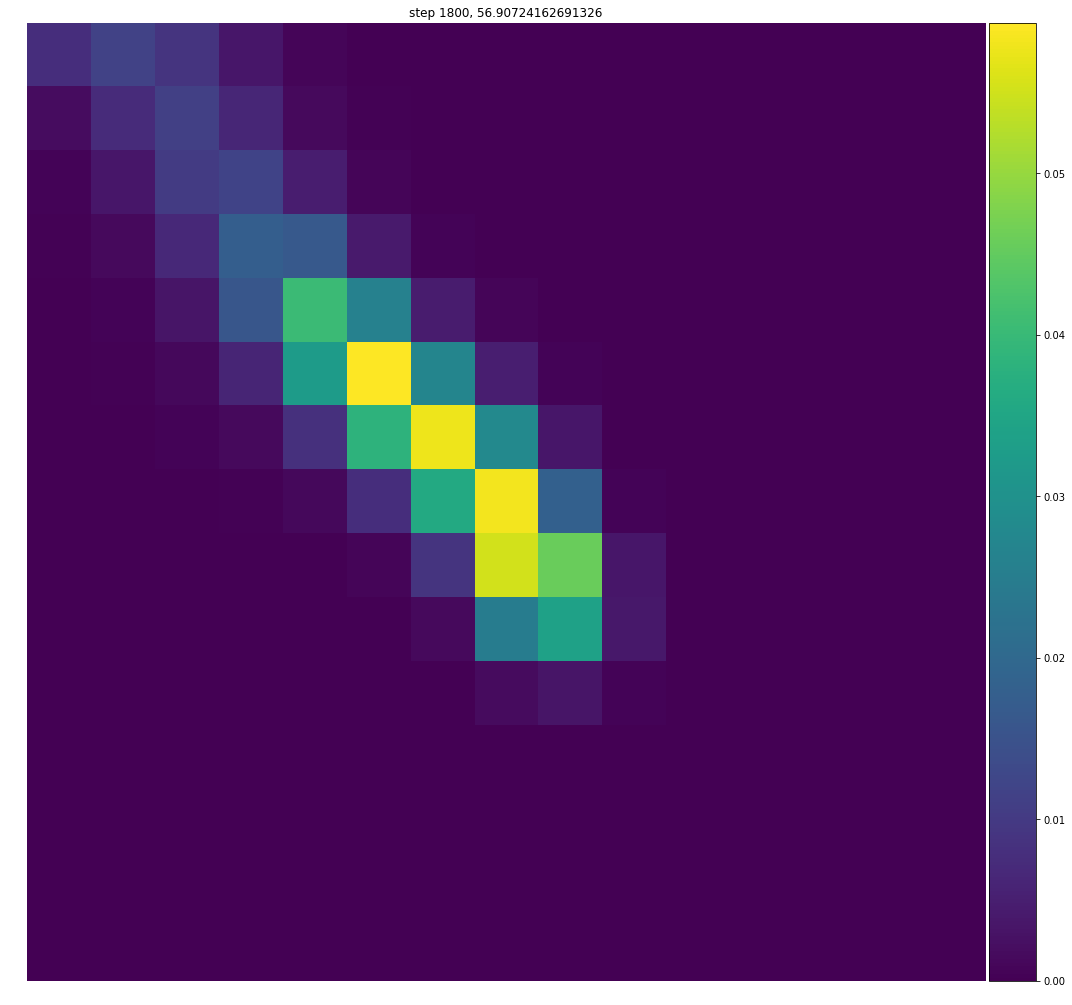

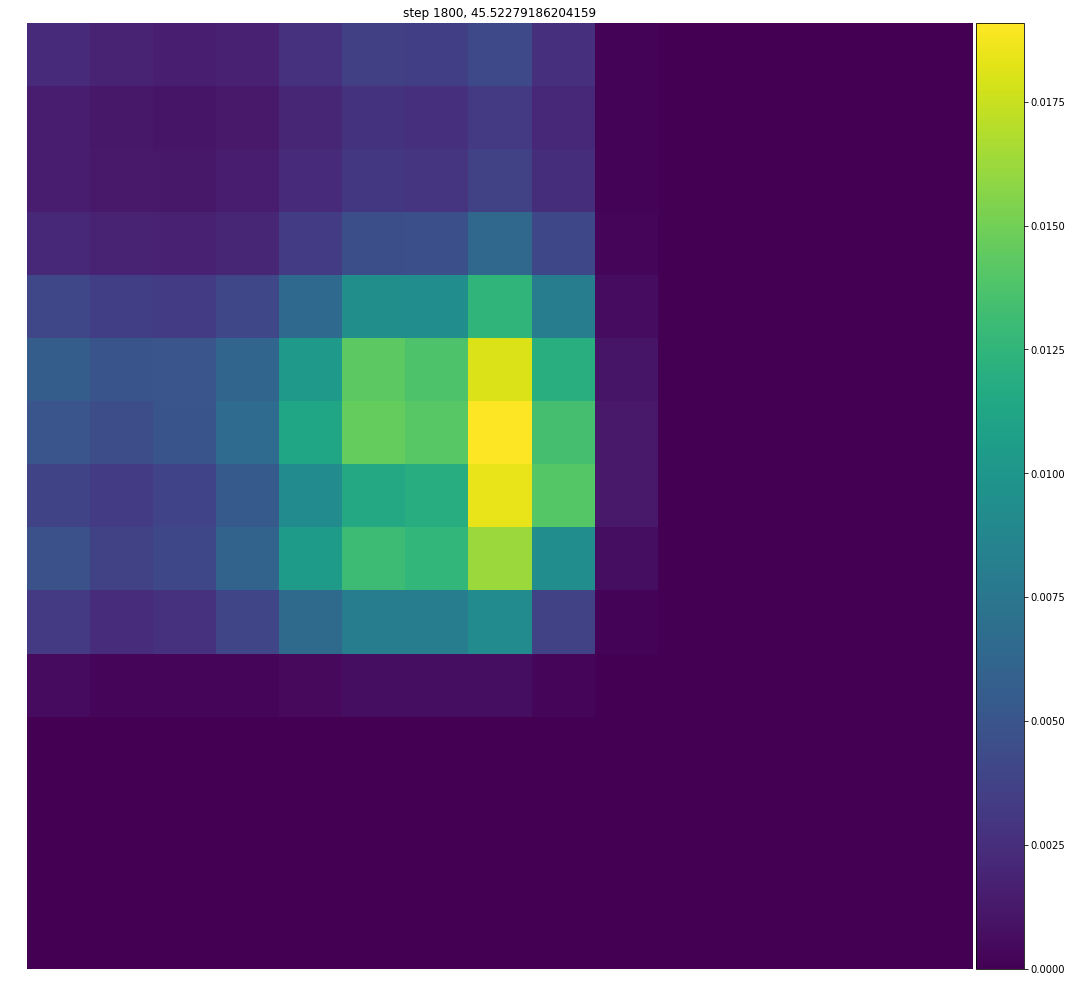

pab min max 0.07183179864811488 2.8052484511039302e-39
1800,1,-0.006573221,-0.69339484,0.036072686
1801,1,-0.0063372604,-0.6780193,0.044293236
1802,1,-0.0061649974,-0.66440713,0.047907367
1803,1,-0.005866516,-0.63731456,0.05066296
1804,1,-0.006449061,-0.6827462,0.037840042
1805,1,-0.0063674524,-0.6820054,0.045260143
1806,1,-0.0066907993,-0.70665413,0.037574194
1807,1,-0.006250763,-0.66985536,0.044779077
1808,1,-0.0062136613,-0.6702921,0.048925906
1809,1,-0.0065432857,-0.6936084,0.039279856
1810,1,-0.0065387026,-0.69282126,0.038950976
1811,1,-0.00623534,-0.67414296,0.050608903
1812,1,-0.006373884,-0.67880785,0.041419394
1813,1,-0.0064798314,-0.6854633,0.037480127
1814,1,-0.0065316726,-0.68745315,0.03428588
1815,1,-0.00647873,-0.6839771,0.036104135
1816,1,-0.0064891297,-0.68789256,0.038979597
1817,1,-0.006505501,-0.69109833,0.040548198
1818,1,-0.006296248,-0.68444645,0.054821588
1819,1,-0.0061074747,-0.6632161,0.05246864
1820,1,-0.0065704137,-0.6962057,0.039164316
1821,1,-0.006420146,-0.

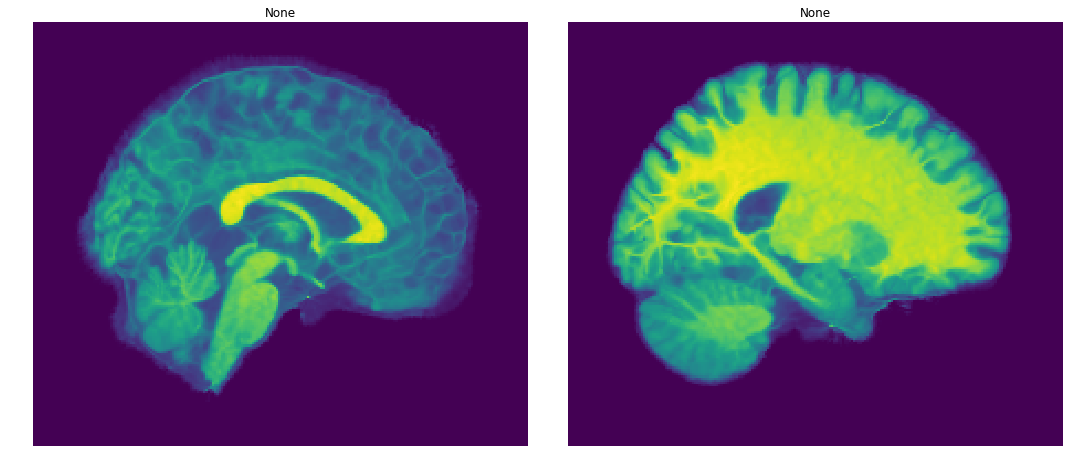

img shape (1, 160, 192, 224, 1)
atlas shape (1, 160, 192, 224, 1)
(1, 2174306, 1)
I_a max 0.9985304905622919
I_b max 0.9820078648594118
(1, 2492424, 1)
I_a max 0.9985304905622919
I_b max 0.9820078648594118
original image min max 0.5019607843137255 0.0
img min max 0.48215276 0.0
flow min max 13.249654 -11.099903


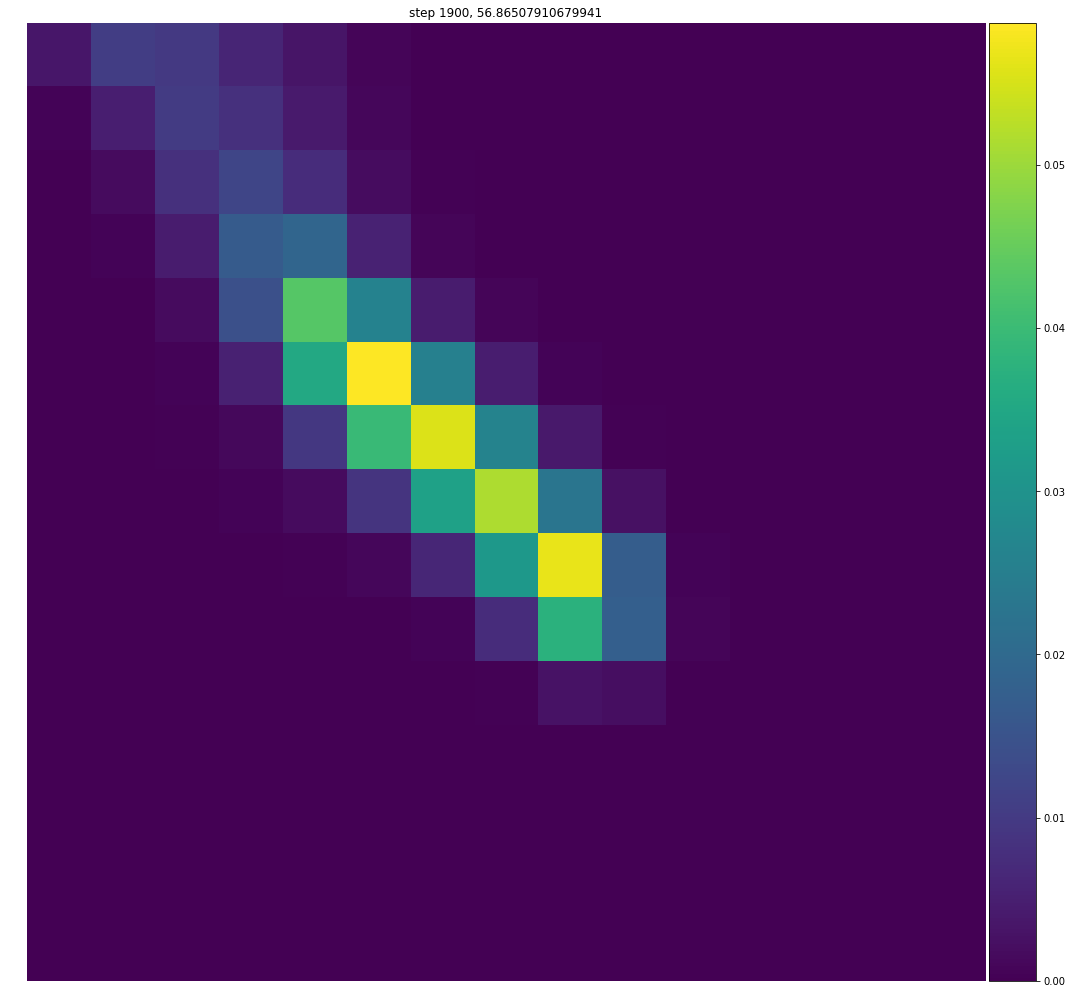

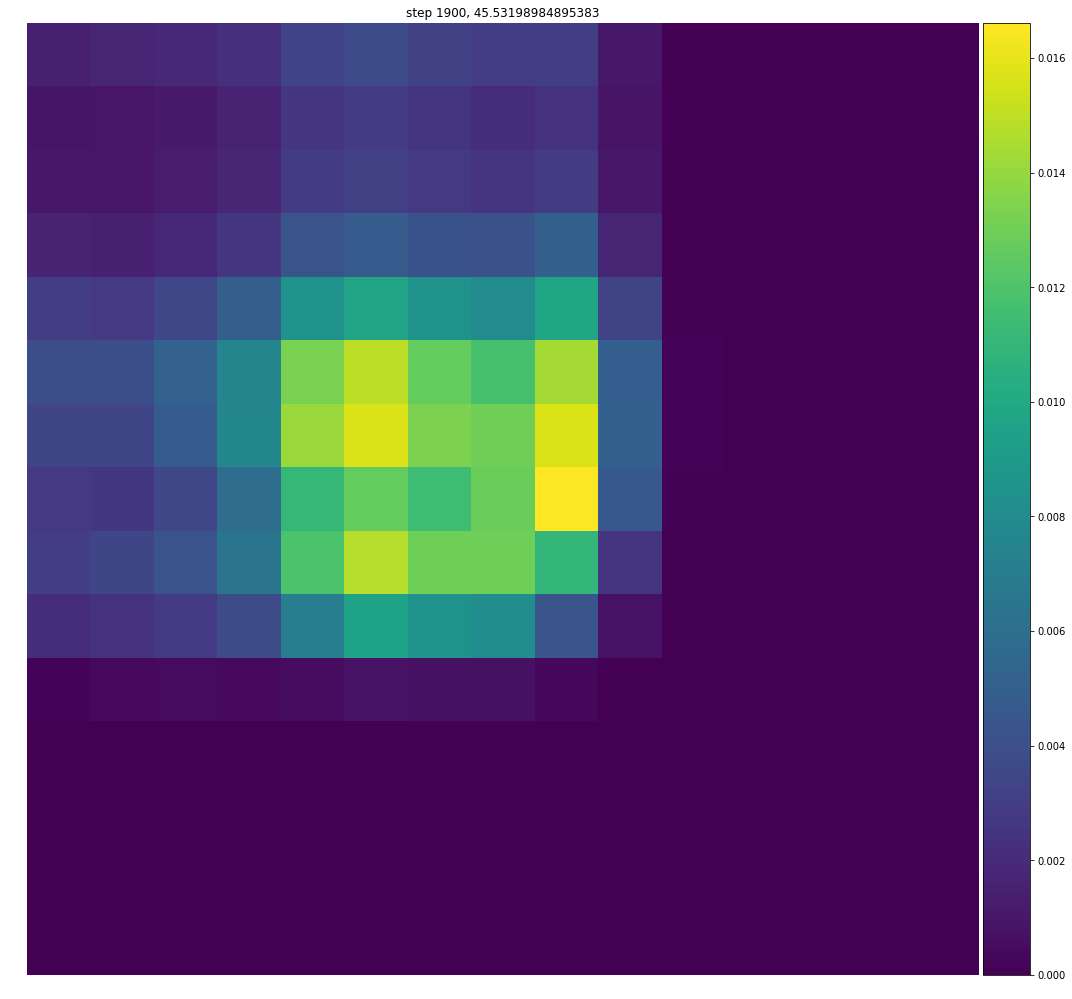

pab min max 0.06702184329154011 1.4654021367884642e-39
1900,1,-0.006517442,-0.6902155,0.038471326
1901,1,-0.004968267,-0.58706355,0.09023683
1902,1,-0.0063559175,-0.6753521,0.03976033
1941,1,-0.0064004464,-0.6810635,0.04101879
1942,1,-0.006563244,-0.694988,0.038663615
2080,1,-0.0064187706,-0.6831987,0.041321617
2081,1,-0.006393158,-0.68311316,0.043797366
2082,1,-0.0064918697,-0.68896496,0.03977798
2083,1,-0.006556285,-0.69186836,0.036239874
2084,1,-0.006482419,-0.6873131,0.039071154
2085,1,-0.006442489,-0.6823617,0.038112808
2086,1,-0.0065514874,-0.6907382,0.035589464
2087,1,-0.0064226766,-0.68134475,0.0390771
2088,1,-0.0064500617,-0.68469095,0.03968478
2089,1,-0.0065415096,-0.6933866,0.03923566
2090,1,-0.0062035597,-0.67195433,0.05159834
2091,1,-0.0063497196,-0.67774194,0.042769946
2092,1,-0.006271048,-0.67387015,0.046765327
2093,1,-0.0064574867,-0.6862508,0.040502157
2094,1,-0.0064232578,-0.68177295,0.03944715
2095,1,-0.0065034274,-0.6899041,0.03956131
2096,1,-0.0065297703,-0.6904888

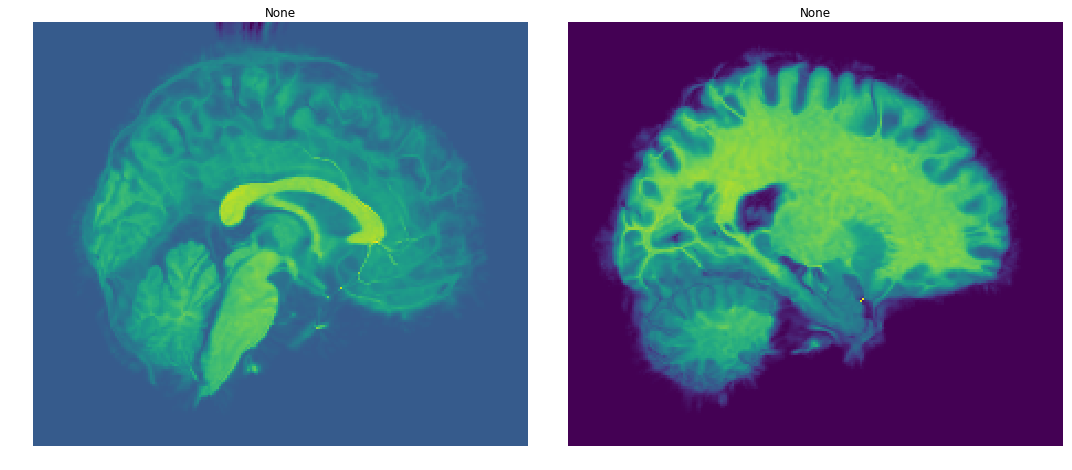

img shape (1, 160, 192, 224, 1)
atlas shape (1, 160, 192, 224, 1)
(1, 2535146, 1)
I_a max 0.9985304905622919
I_b max 0.9820078648594118
(1, 2746512, 1)
I_a max 0.9985304905622919
I_b max 0.9820078648594118
original image min max 0.8470588235294118 0.0
img min max 0.6821667 -1.8834462
flow min max 17.54824 -14.132906


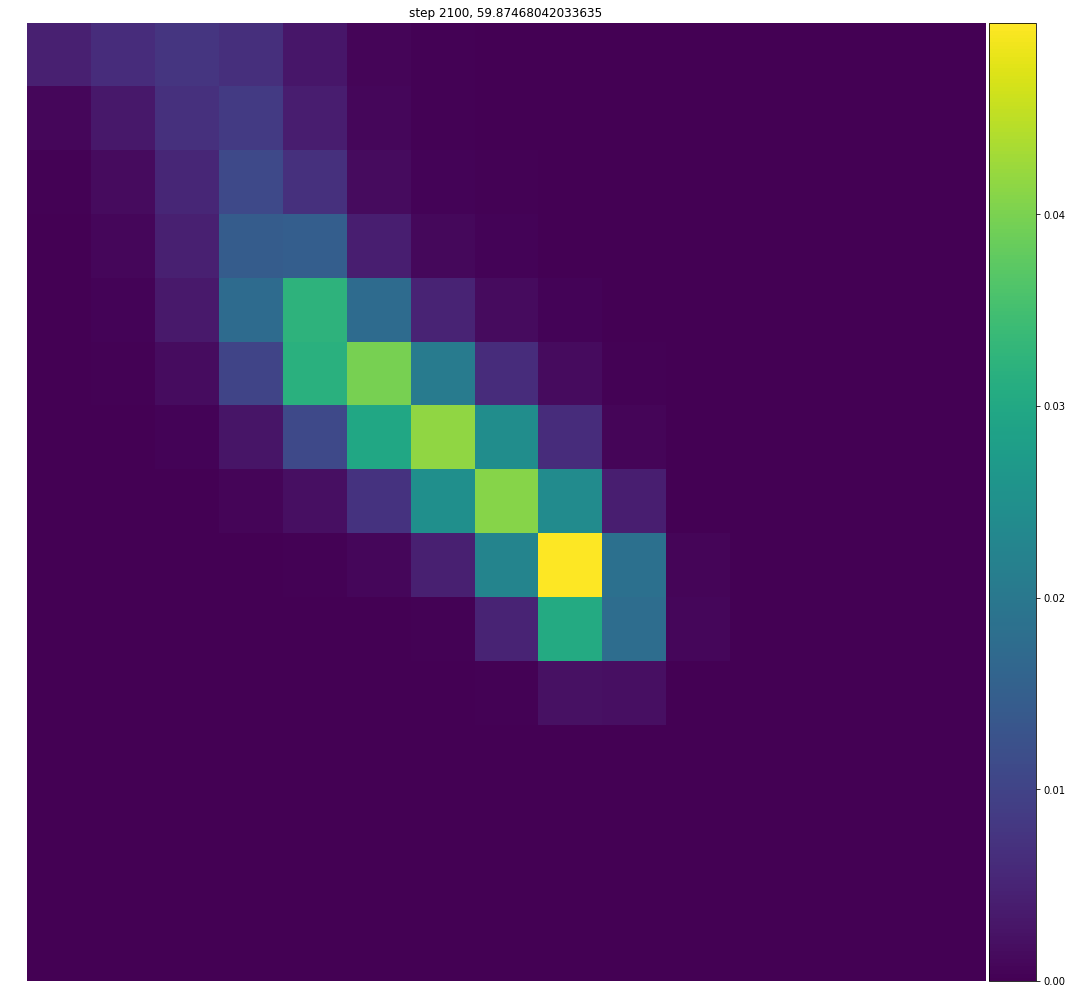

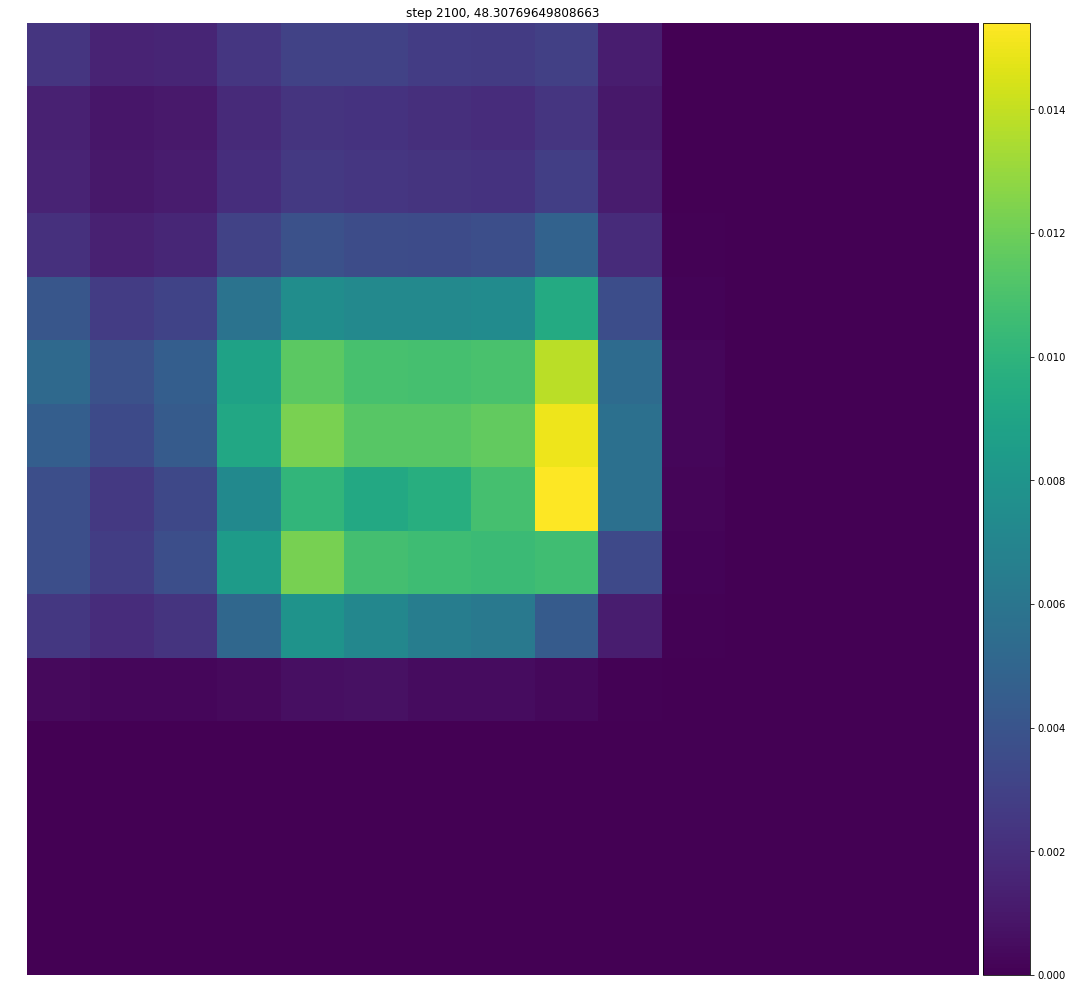

pab min max 0.14999593097289238 3.573652256625382e-35
2100,1,-0.0060299207,-0.65659165,0.053599592
2101,1,-0.0061676367,-0.6647513,0.047987603
2102,1,-0.0061829565,-0.66627693,0.047981273
2103,1,-0.0065604527,-0.69297945,0.036934137
2104,1,-0.006325529,-0.67556643,0.04301351
2105,1,-0.0064779455,-0.6880421,0.04024754
2106,1,-0.006132626,-0.6637726,0.050509956
2107,1,-0.0066233557,-0.6993911,0.037055567
2108,1,-0.006517342,-0.6905757,0.038841527
2109,1,-0.0065648365,-0.69725883,0.04077515
2110,1,-0.0065944954,-0.6965185,0.037068915
2111,1,-0.006573195,-0.6944177,0.0370982
2112,1,-0.0064997706,-0.6901845,0.040207393
2113,1,-0.0061476803,-0.66632265,0.051554635


In [ ]:
model='vm2'
pretrained_path='../models/cvpr_pretrained_vm2_l2/0.h5'
lr=1e-4
num_bins=16
reg_param=0.01
alpha=0.01
batch_size=1

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

restrict_GPU_tf(str(gpu_id))
restrict_GPU_keras(str(gpu_id))

# model_dir = "../models/" + model_name
# prepare model folder
# if not os.path.isdir(model_dir):
#     os.mkdir(model_dir)

# GPU handling
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement = True
set_session(tf.Session(config=config))

# UNET filters for voxelmorph-1 and voxelmorph-2,
# these are architectures presented in CVPR 2018
nf_enc = [16, 32, 32, 32]
if model == 'vm1':
    nf_dec = [32, 32, 32, 32, 8, 8]
else:
    nf_dec = [32, 32, 32, 32, 32, 16, 16]

# prepare the model
# in the CVPR layout, the model takes in [image_1, image_2] and outputs [warped_image_1, flow]
# in the experiments, we use image_2 as atlas

# autoencoder_path = '../models/%s/%s.h5' % (autoencoder_model, autoencoder_iters)

# bin_centers = np.linspace(0, 1, num_bins*2+1)[1::2]
# weights = np.ones((1, 16))
# weights[0] = 0.1
# loss_function = mutualInformation(bin_centers, weights=weights)
loss_function = mutualInformation(bin_centers)

model = networks.unet(vol_size, nf_enc, nf_dec)
model.compile(optimizer=Adam(lr=lr), 
              loss=[loss_function, losses.gradientLoss('l2')],
              loss_weights=[alpha, reg_param])

print('inputs', model.inputs)
# if you'd like to initialize the data, you can do it here:
if pretrained_path != None:
    model.load_weights(pretrained_path)

# prepare data for training
train_example_gen = datagenerators.example_gen(train_vol_names)
zero_flow = np.zeros([batch_size, *vol_size, 3])

# train. Note: we use train_on_batch and design out own print function as this has enabled 
# faster development and debugging, but one could also use fit_generator and Keras callbacks.
for step in range(0, 10000):

    # get data
    X = next(train_example_gen)[0]

    # train
    img, flow = model.predict([X, atlas_vol])
    train_loss = model.train_on_batch([X, atlas_vol], [atlas_vol, zero_flow])
    
    if step % 100 == 0:
        print('--------------step %d---------------' % step)

#         slices([flow[0,80,:,:,0], flow[0,100,:,:,0],])
        slices([img[0,80,:,:,0], img[0,100,:,:,0],])
#         slices([img[0,80,::-1,::-1,0], img[0,100,::-1,::-1,0],])

    #     pab = mi_test(img[:,80:90,:,:,:], atlas_vol[:,80:90,:,:,:])
        print('img shape', img.shape)
        print('atlas shape', atlas_vol.shape)
        mi, pab = mi_test(atlas_vol, img)
        mi2, pab2 = mi_test(atlas_vol, img[:, ::-1, ::-1, ::-1, :])

        print('original image min max', np.max(X), np.min(X))
        print('img min max', np.max(img), np.min(img))
        print('flow min max', np.max(flow), np.min(flow))

        slices([pab[1:,1:]], do_colorbars=True, cmaps=['viridis'], titles=[('step %d, ' % step) + str(mi)])
        slices([pab2[1:,1:]], do_colorbars=True, cmaps=['viridis'], titles=[('step %d, ' % step) + str(mi2)])

        print('pab min max', np.max(pab), np.min(pab))
        
    if not isinstance(train_loss, list):
        train_loss = [train_loss]

    # print the loss. 
    print_loss(step, 1, train_loss)

    # save model
#     if step % model_save_iter == 0:
#         model.save(os.path.join(model_dir, str(step) + '.h5'))